# TESS Atlas fit for TOI 429

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 429.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-429.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-429.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-429.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 429

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 429 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

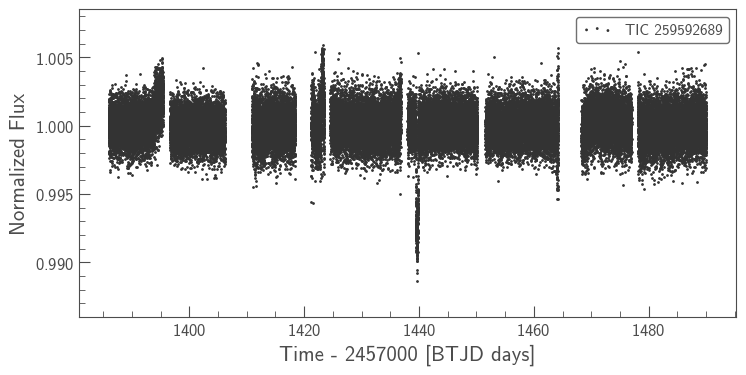

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -125118.57434329393 -> -124711.9415235743


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -108474.34931493142 -> -108045.52330497064


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -108045.52330497066 -> -100788.46454974196


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -100788.46454974196 -> -100654.53396686506


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -100654.53396686506 -> -100292.68621619348


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -100292.68621619348 -> -100221.40757888745


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -100221.40757888745 -> -98994.19807465178


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']
message: Optimization terminated successfully.
logp: -98994.19807465177 -> -98994.19807465177


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -98994.19807465178 -> -98994.19807465178


optimizing logp for variables: ['logg_star']
message: Optimization terminated successfully.
logp: -98994.19807465178 -> -98994.19807465178


optimizing logp for variables: ['mean', 't0', 'logP']
message: Optimization terminated successfully.
logp: -98994.19807465178 -> -98994.1980746517


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -98994.1980746517 -> -98994.1980746517


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']
message: Optimization terminated successfully.
logp: -98994.1980746517 -> -98994.1980746517


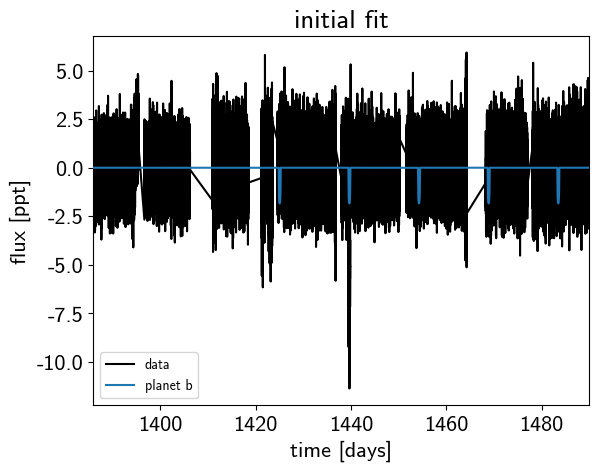

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:01<00:13,  7.10draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:02<00:25,  3.61draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:03<00:34,  2.67draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:04<00:39,  2.26draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:06<00:42,  2.04draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:07<00:44,  1.91draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:08<00:45,  1.83draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:09<00:46,  1.76draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:09<00:36,  2.21draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:10<00:49,  1.61draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:11<00:38,  2.03draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:12<00:52,  1.47draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:12<00:45,  1.66draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:13<00:54,  1.39draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:14<00:48,  1.52draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:15<00:56,  1.29draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:15<00:45,  1.57draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:16<00:55,  1.29draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:17<00:47,  1.48draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:18<00:53,  1.30draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:18<00:52,  1.29draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:19<00:48,  1.37draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:20<00:53,  1.24draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:20<00:45,  1.44draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:22<00:53,  1.19draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:22<00:41,  1.51draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:23<00:51,  1.21draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:23<00:38,  1.57draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:24<00:50,  1.20draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:25<00:37,  1.59draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:26<00:46,  1.25draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:26<00:34,  1.64draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:27<00:44,  1.27draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:28<00:39,  1.39draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:29<00:42,  1.28draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:29<00:35,  1.51draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:29<00:25,  2.01draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:31<00:38,  1.32draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:32<00:36,  1.32draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:33<00:34,  1.35draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:35<00:33,  1.35draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:36<00:31,  1.35draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:37<00:24,  1.71draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:38<00:32,  1.27draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:38<00:25,  1.57draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:39<00:32,  1.21draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:40<00:26,  1.42draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:41<00:30,  1.21draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:41<00:25,  1.43draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:43<00:29,  1.19draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:43<00:23,  1.43draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:44<00:27,  1.18draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:44<00:21,  1.48draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:46<00:28,  1.09draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:47<00:24,  1.17draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:49<00:22,  1.21draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:49<00:16,  1.59draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:50<00:21,  1.16draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:51<00:15,  1.56draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:52<00:20,  1.12draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:53<00:17,  1.19draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:54<00:14,  1.34draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:55<00:15,  1.20draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:56<00:15,  1.14draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:57<00:13,  1.28draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:57<00:12,  1.27draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:58<00:12,  1.24draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:59<00:10,  1.36draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [01:00<00:10,  1.21draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [01:00<00:08,  1.40draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [01:01<00:09,  1.20draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [01:02<00:06,  1.47draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [01:03<00:07,  1.18draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:03<00:05,  1.54draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:04<00:05,  1.20draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:05<00:03,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:06<00:04,  1.16draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:07<00:02,  1.21draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:08<00:01,  1.56draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:14<00:02,  2.22s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:14<00:00,  1.40draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 76.99draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:17,  5.20draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:37,  2.42draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:05<00:49,  1.77draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:07<01:11,  1.22draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:07<01:00,  1.43draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:08<01:14,  1.14draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:09<01:03,  1.33draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:10<01:12,  1.14draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:10<00:51,  1.57draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:12<01:14,  1.08draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:13<01:08,  1.13draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:13<00:52,  1.46draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:15<01:12,  1.05draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:15<00:53,  1.40draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:17<00:56,  1.29draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:19<00:58,  1.21draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:21<00:57,  1.21draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:21<00:43,  1.56draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:22<00:57,  1.16draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:23<00:48,  1.36draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:24<00:58,  1.12draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:24<00:49,  1.30draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:26<00:59,  1.06draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:26<00:52,  1.19draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:28<01:01,  1.02s/draws]

Sampling 2 chains:  43%|████▎     | 45/104 [00:28<00:48,  1.22draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:29<00:51,  1.13draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:31<00:55,  1.03draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:31<00:45,  1.23draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:32<00:52,  1.05draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:33<00:40,  1.33draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:34<00:47,  1.11draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:34<00:37,  1.37draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:35<00:43,  1.17draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:36<00:37,  1.34draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:37<00:43,  1.14draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:38<00:37,  1.28draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:39<00:41,  1.12draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:39<00:36,  1.26draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:40<00:31,  1.38draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:41<00:27,  1.59draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:41<00:20,  2.07draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:43<00:33,  1.24draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:44<00:31,  1.24draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:44<00:23,  1.65draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:46<00:34,  1.08draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:46<00:25,  1.41draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:47<00:30,  1.15draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:48<00:24,  1.40draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:49<00:27,  1.21draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:49<00:23,  1.34draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:50<00:24,  1.27draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:51<00:21,  1.39draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:52<00:21,  1.35draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:52<00:15,  1.75draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:53<00:23,  1.17draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:54<00:17,  1.46draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:55<00:22,  1.12draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:55<00:17,  1.35draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:57<00:23,  1.00s/draws]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:59<00:20,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [01:00<00:17,  1.09draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [01:01<00:12,  1.43draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [01:02<00:15,  1.09draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [01:02<00:11,  1.41draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [01:04<00:13,  1.11draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [01:04<00:08,  1.49draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [01:05<00:10,  1.16draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [01:05<00:07,  1.49draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [01:07<00:08,  1.15draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [01:07<00:06,  1.44draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:08<00:07,  1.10draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:09<00:05,  1.22draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:10<00:05,  1.13draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:11<00:03,  1.29draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:12<00:02,  1.35draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:13<00:01,  1.23draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:20<00:02,  2.62s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:20<00:00,  1.30draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:27,  1.37draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:49,  1.84draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:19,  2.51draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<02:49,  1.17draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:04<02:54,  1.13draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:04<02:09,  1.52draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:06<03:05,  1.05draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:06<02:15,  1.43draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:07<02:00,  1.60draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:07<01:31,  2.10draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:08<02:08,  1.49draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:08<02:02,  1.55draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:09<01:29,  2.11draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:10<02:26,  1.28draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:10<01:57,  1.59draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:12<02:44,  1.13draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:12<02:07,  1.45draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:14<03:05,  1.02s/draws]

Sampling 2 chains:  12%|█▏        | 24/204 [00:16<02:41,  1.11draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:16<02:11,  1.36draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:17<01:57,  1.52draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:17<01:53,  1.56draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:18<01:59,  1.47draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:19<01:56,  1.50draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:19<01:59,  1.46draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:21<02:29,  1.15draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:21<01:56,  1.47draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:21<01:44,  1.63draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:23<02:23,  1.18draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:23<02:07,  1.32draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:23<01:35,  1.77draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:24<01:37,  1.71draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:26<01:59,  1.38draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:26<01:34,  1.74draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:28<02:29,  1.09draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:28<01:49,  1.47draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:30<02:29,  1.07draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:30<02:05,  1.27draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:30<01:30,  1.73draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:31<01:13,  2.12draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:32<02:05,  1.24draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:33<01:43,  1.48draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:33<01:24,  1.79draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:34<01:17,  1.96draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:34<01:32,  1.63draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:35<01:46,  1.40draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:37<02:03,  1.20draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:37<02:01,  1.21draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:39<02:19,  1.05draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:39<01:56,  1.24draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:39<01:30,  1.59draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:41<01:42,  1.39draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:42<01:27,  1.61draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:42<01:30,  1.55draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:43<01:38,  1.42draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:44<01:59,  1.15draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:45<01:59,  1.14draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:46<02:05,  1.08draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:47<02:16,  1.01s/draws]

Sampling 2 chains:  34%|███▍      | 70/204 [00:48<02:05,  1.06draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:50<02:30,  1.13s/draws]

Sampling 2 chains:  35%|███▌      | 72/204 [00:51<02:11,  1.00draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:52<02:31,  1.16s/draws]

Sampling 2 chains:  36%|███▋      | 74/204 [00:53<02:11,  1.01s/draws]

Sampling 2 chains:  37%|███▋      | 75/204 [00:54<02:30,  1.17s/draws]

Sampling 2 chains:  37%|███▋      | 76/204 [00:55<02:02,  1.04draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:56<01:57,  1.07draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:57<01:36,  1.30draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:57<01:10,  1.75draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:59<01:54,  1.08draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:59<01:37,  1.25draws/s]

Sampling 2 chains:  41%|████      | 83/204 [01:00<01:18,  1.54draws/s]

Sampling 2 chains:  41%|████      | 84/204 [01:00<01:26,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [01:01<01:31,  1.29draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [01:02<01:15,  1.54draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [01:03<01:30,  1.29draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [01:04<01:22,  1.40draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [01:04<01:03,  1.81draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [01:05<01:22,  1.37draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [01:06<01:24,  1.33draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [01:07<01:32,  1.20draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [01:08<01:33,  1.18draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [01:09<01:42,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [01:10<01:37,  1.11draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [01:10<01:15,  1.42draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [01:10<01:08,  1.55draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [01:11<00:57,  1.81draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [01:13<01:42,  1.02draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [01:13<01:16,  1.34draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [01:15<01:49,  1.07s/draws]

Sampling 2 chains:  50%|█████     | 103/204 [01:15<01:23,  1.20draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [01:15<01:02,  1.61draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [01:16<00:54,  1.83draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [01:17<01:16,  1.29draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [01:18<01:12,  1.35draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [01:18<00:55,  1.73draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [01:19<01:10,  1.35draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [01:20<01:09,  1.36draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [01:21<01:26,  1.07draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [01:21<01:07,  1.36draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [01:22<01:01,  1.47draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [01:22<00:53,  1.69draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [01:23<01:01,  1.44draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [01:24<01:09,  1.27draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [01:25<01:20,  1.09draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [01:27<01:18,  1.08draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [01:27<00:59,  1.41draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [01:29<01:27,  1.05s/draws]

Sampling 2 chains:  60%|█████▉    | 122/204 [01:29<01:05,  1.25draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [01:30<00:51,  1.58draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [01:30<00:39,  2.02draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [01:32<01:11,  1.11draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [01:34<01:10,  1.10draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [01:36<01:09,  1.07draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [01:36<00:52,  1.40draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [01:37<00:44,  1.62draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [01:38<01:00,  1.17draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [01:38<00:50,  1.37draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [01:39<00:41,  1.65draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [01:40<00:51,  1.33draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [01:41<00:55,  1.20draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:42<00:55,  1.18draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [01:42<00:49,  1.31draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [01:44<01:03,  1.00draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [01:44<00:53,  1.19draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:44<00:38,  1.59draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [01:45<00:28,  2.12draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [01:46<00:40,  1.48draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [01:46<00:41,  1.42draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:48<00:50,  1.16draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:50<00:53,  1.04draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [01:50<00:39,  1.38draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [01:51<00:34,  1.58draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:51<00:26,  1.98draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:51<00:20,  2.43draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:52<00:19,  2.53draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:53<00:27,  1.81draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:53<00:25,  1.85draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:53<00:23,  1.99draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:54<00:24,  1.88draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:55<00:23,  1.89draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:55<00:25,  1.70draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:56<00:24,  1.74draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:56<00:18,  2.29draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:56<00:13,  2.95draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:56<00:13,  2.91draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:57<00:21,  1.83draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:58<00:15,  2.42draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:59<00:21,  1.74draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:59<00:22,  1.57draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [02:00<00:18,  1.85draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [02:00<00:19,  1.72draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [02:01<00:19,  1.70draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [02:01<00:16,  1.96draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [02:02<00:15,  2.01draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [02:02<00:15,  1.92draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [02:02<00:11,  2.44draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [02:03<00:12,  2.23draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [02:04<00:16,  1.61draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [02:05<00:15,  1.59draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [02:06<00:13,  1.77draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [02:07<00:16,  1.40draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [02:07<00:13,  1.62draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [02:08<00:15,  1.35draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [02:08<00:12,  1.58draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [02:09<00:10,  1.80draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [02:10<00:13,  1.36draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [02:10<00:10,  1.68draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [02:12<00:14,  1.10draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [02:12<00:10,  1.46draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [02:13<00:09,  1.47draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [02:14<00:10,  1.30draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [02:14<00:08,  1.44draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [02:15<00:09,  1.21draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [02:16<00:09,  1.09draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [02:17<00:06,  1.29draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [02:18<00:06,  1.15draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [02:19<00:07,  1.01s/draws]

Sampling 2 chains:  97%|█████████▋| 198/204 [02:21<00:07,  1.32s/draws]

Sampling 2 chains:  98%|█████████▊| 199/204 [02:22<00:04,  1.00draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [02:24<00:05,  1.31s/draws]

Sampling 2 chains:  99%|█████████▊| 201/204 [02:26<00:04,  1.52s/draws]

Sampling 2 chains:  99%|█████████▉| 202/204 [02:28<00:03,  1.64s/draws]

Sampling 2 chains: 100%|█████████▉| 203/204 [02:30<00:01,  1.86s/draws]

Sampling 2 chains: 100%|██████████| 204/204 [02:35<00:00,  2.73s/draws]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/404 [00:00<01:53,  3.57draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<01:29,  4.45draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:01<02:27,  2.70draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:02<03:15,  2.03draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:03<03:11,  2.06draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:03<02:27,  2.67draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:03<02:09,  3.03draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:03<01:59,  3.28draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:03<01:37,  4.03draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:04<02:01,  3.22draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:04<02:07,  3.04draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:05<01:51,  3.47draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:05<01:59,  3.22draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:05<01:43,  3.74draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:05<01:30,  4.25draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:06<01:33,  4.10draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:06<01:22,  4.60draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:06<01:41,  3.74draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:06<01:40,  3.79draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:07<02:20,  2.69draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:07<01:49,  3.44draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:08<02:13,  2.81draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:08<01:53,  3.30draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:08<01:40,  3.71draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:08<01:23,  4.46draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:09<01:48,  3.41draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:09<01:26,  4.27draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:09<01:37,  3.79draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:10<01:41,  3.61draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:10<01:35,  3.82draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:10<01:37,  3.72draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:11<01:47,  3.39draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:11<01:39,  3.63draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:11<01:35,  3.79draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:12<01:20,  4.45draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:12<02:03,  2.91draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:12<01:47,  3.31draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:13<01:29,  3.96draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:13<01:38,  3.60draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:13<02:00,  2.94draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:14<01:46,  3.31draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:14<01:55,  3.04draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:15<01:30,  3.84draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:15<01:35,  3.63draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:15<01:18,  4.45draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:15<01:16,  4.55draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:16<01:14,  4.61draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:16<01:07,  5.05draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:16<01:03,  5.40draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:16<00:55,  6.16draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:16<00:58,  5.77draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:17<01:12,  4.67draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:17<00:58,  5.77draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:17<00:56,  5.95draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:17<01:18,  4.25draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:18<01:10,  4.72draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:18<01:19,  4.16draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:18<01:10,  4.67draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:18<01:05,  5.06draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:18<01:00,  5.41draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:19<01:12,  4.50draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:19<01:21,  4.03draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:19<01:08,  4.76draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:19<01:03,  5.09draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:20<00:59,  5.44draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:20<00:56,  5.73draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:20<00:54,  5.88draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:20<00:48,  6.56draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:20<00:45,  7.02draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:20<00:46,  6.87draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:21<00:55,  5.69draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:21<00:50,  6.17draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:21<00:49,  6.32draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:22<01:03,  4.89draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:22<01:12,  4.24draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:23<01:19,  3.87draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:23<01:02,  4.89draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:23<01:11,  4.24draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:23<01:17,  3.89draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:24<01:08,  4.41draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:24<01:01,  4.88draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:24<01:12,  4.15draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:24<01:15,  3.93draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:25<01:29,  3.31draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:26<01:34,  3.12draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:26<01:19,  3.67draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:26<01:09,  4.18draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:26<01:02,  4.64draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:27<00:53,  5.39draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:27<00:58,  4.95draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:27<01:04,  4.46draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:27<00:58,  4.86draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:28<00:53,  5.24draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:28<00:50,  5.53draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:28<01:04,  4.38draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:28<00:57,  4.85draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:29<01:05,  4.23draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:29<01:11,  3.88draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:29<01:00,  4.58draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:30<00:57,  4.81draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:30<00:58,  4.70draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:30<01:05,  4.14draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:30<00:58,  4.68draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:31<01:05,  4.14draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:31<00:57,  4.64draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:31<01:05,  4.11draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:31<01:11,  3.76draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:32<00:56,  4.70draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:32<01:01,  4.29draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:32<00:58,  4.47draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:33<00:50,  5.14draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:33<01:01,  4.23draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:33<01:16,  3.36draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:34<01:08,  3.74draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:34<01:40,  2.53draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:34<01:28,  2.90draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:35<01:16,  3.32draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:35<01:26,  2.92draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:36<01:33,  2.71draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:36<01:17,  3.25draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:36<01:11,  3.46draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:36<00:58,  4.26draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:37<01:02,  3.93draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:37<01:01,  3.99draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:37<01:03,  3.87draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:37<00:55,  4.41draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:38<01:10,  3.45draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:38<01:00,  3.98draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:38<01:02,  3.89draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:38<01:04,  3.73draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:39<01:06,  3.59draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:39<01:05,  3.62draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:39<01:00,  3.92draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:40<00:52,  4.45draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:40<00:48,  4.84draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:40<00:48,  4.76draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:40<00:49,  4.67draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:41<00:40,  5.72draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:41<00:46,  4.92draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:41<00:47,  4.81draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:41<00:40,  5.52draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:41<00:35,  6.37draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:41<00:39,  5.70draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:42<00:48,  4.55draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:42<00:56,  3.96draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:42<00:53,  4.14draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:43<00:50,  4.35draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:43<00:42,  5.15draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:43<00:41,  5.17draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:43<00:45,  4.79draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:44<00:42,  5.01draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:44<00:48,  4.35draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:44<00:47,  4.51draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:45<00:45,  4.65draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:45<00:40,  5.10draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:45<00:37,  5.48draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:45<00:42,  4.85draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:46<00:42,  4.79draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:46<00:44,  4.54draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:47<01:26,  2.31draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:47<01:07,  2.94draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:47<01:00,  3.32draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:48<00:58,  3.36draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:48<01:03,  3.10draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:48<01:04,  3.06draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:49<01:15,  2.58draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:49<01:13,  2.63draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:50<01:04,  2.99draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:50<01:01,  3.12draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:50<01:17,  2.47draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:51<01:08,  2.77draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:51<00:58,  3.22draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:51<00:57,  3.28draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:51<00:54,  3.44draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:52<00:49,  3.73draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:52<00:50,  3.66draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:52<01:02,  2.95draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:53<00:55,  3.30draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:53<00:58,  3.12draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:54<00:52,  3.41draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:54<00:54,  3.24draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:55<00:46,  3.75draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:55<00:42,  4.13draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:55<00:38,  4.55draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:55<00:35,  4.94draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:55<00:29,  5.75draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:56<00:31,  5.48draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:56<00:26,  6.46draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:56<00:29,  5.57draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:56<00:26,  6.23draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:56<00:31,  5.17draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:57<00:27,  5.92draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:57<00:35,  4.53draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:57<00:37,  4.29draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:58<00:42,  3.73draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:58<00:36,  4.37draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:58<00:41,  3.78draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:58<00:35,  4.44draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:59<00:39,  3.97draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:59<00:35,  4.38draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:59<00:30,  4.97draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:59<00:35,  4.30draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [01:00<00:31,  4.74draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [01:00<00:27,  5.49draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [01:00<00:28,  5.18draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [01:00<00:32,  4.50draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [01:01<00:39,  3.65draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [01:01<00:37,  3.89draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [01:01<00:32,  4.34draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [01:02<00:36,  3.92draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [01:02<00:31,  4.43draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [01:02<00:34,  3.98draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [01:03<00:37,  3.73draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [01:03<00:38,  3.56draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [01:04<00:37,  3.58draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [01:04<00:39,  3.33draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [01:05<00:53,  2.46draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [01:05<00:54,  2.43draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [01:06<00:45,  2.87draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [01:06<00:41,  3.08draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [01:06<00:42,  2.99draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [01:06<00:33,  3.77draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [01:07<00:41,  3.05draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [01:07<00:35,  3.53draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [01:07<00:33,  3.72draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [01:08<00:31,  3.79draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [01:08<00:28,  4.20draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [01:08<00:25,  4.68draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [01:09<00:25,  4.57draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [01:09<00:24,  4.70draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [01:09<00:27,  4.13draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [01:10<00:28,  4.00draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [01:10<00:36,  3.11draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [01:11<00:41,  2.67draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [01:11<00:43,  2.53draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [01:11<00:46,  2.34draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [01:12<00:42,  2.54draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [01:12<00:39,  2.70draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [01:13<00:43,  2.43draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [01:13<00:33,  3.10draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [01:14<00:51,  2.02draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [01:14<00:40,  2.52draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [01:14<00:33,  3.03draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [01:15<00:36,  2.77draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [01:15<00:29,  3.36draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [01:15<00:35,  2.73draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [01:16<00:30,  3.15draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [01:16<00:25,  3.69draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [01:16<00:24,  3.69draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [01:17<00:21,  4.15draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [01:17<00:19,  4.61draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [01:17<00:17,  5.11draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [01:17<00:19,  4.36draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [01:18<00:15,  5.44draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [01:18<00:15,  5.35draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [01:18<00:15,  5.39draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [01:19<00:26,  3.07draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [01:19<00:22,  3.66draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [01:19<00:18,  4.22draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [01:19<00:18,  4.37draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:19<00:17,  4.42draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [01:20<00:18,  4.11draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:20<00:16,  4.59draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [01:20<00:14,  5.02draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [01:20<00:13,  5.36draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:21<00:12,  5.65draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [01:21<00:14,  4.71draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:21<00:16,  4.10draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [01:21<00:15,  4.41draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:22<00:12,  5.15draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [01:22<00:14,  4.39draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [01:22<00:12,  4.88draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:22<00:14,  4.26draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [01:23<00:14,  4.13draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [01:23<00:13,  4.30draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [01:23<00:13,  4.54draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:23<00:12,  4.64draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [01:24<00:13,  4.29draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [01:25<00:25,  2.16draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [01:26<00:33,  1.60draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [01:26<00:31,  1.71draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:27<00:36,  1.42draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [01:29<00:49,  1.03draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [01:30<00:48,  1.02draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [01:30<00:40,  1.21draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [01:31<00:34,  1.38draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [01:33<00:51,  1.09s/draws]

Sampling 2 chains:  89%|████████▊ | 358/404 [01:33<00:41,  1.10draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [01:34<00:35,  1.28draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [01:34<00:30,  1.45draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [01:35<00:26,  1.60draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [01:35<00:24,  1.72draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [01:35<00:18,  2.25draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [01:36<00:18,  2.19draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [01:37<00:23,  1.67draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [01:37<00:21,  1.80draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [01:38<00:24,  1.51draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [01:40<00:31,  1.15draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [01:40<00:28,  1.23draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [01:41<00:24,  1.41draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:41<00:21,  1.54draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [01:42<00:18,  1.69draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:42<00:17,  1.81draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [01:43<00:15,  1.91draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:43<00:14,  1.99draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [01:44<00:17,  1.61draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:45<00:19,  1.42draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [01:45<00:16,  1.59draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:46<00:14,  1.75draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [01:47<00:16,  1.50draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:47<00:16,  1.37draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [01:48<00:17,  1.28draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:49<00:17,  1.23draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:50<00:13,  1.53draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:50<00:10,  1.90draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:50<00:09,  1.99draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:51<00:08,  2.07draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:51<00:07,  2.10draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:52<00:06,  2.15draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:52<00:08,  1.70draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:53<00:06,  1.91draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:54<00:05,  2.01draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:54<00:05,  1.90draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:54<00:03,  2.31draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:55<00:03,  2.30draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:56<00:03,  1.96draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:56<00:02,  2.05draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:56<00:02,  2.12draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:57<00:01,  2.21draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:58<00:01,  1.73draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:58<00:00,  2.13draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:58<00:00,  2.19draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:59<00:00,  2.23draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/804 [00:00<02:38,  5.07draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<01:56,  6.85draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<02:42,  4.90draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:01<02:39,  4.99draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:01<03:18,  4.01draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:01<03:03,  4.33draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:02<03:37,  3.65draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:02<03:16,  4.03draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:02<02:51,  4.60draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:03<03:30,  3.73draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:03<03:01,  4.33draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:03<02:52,  4.54draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:04<02:23,  5.47draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:04<02:24,  5.40draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:04<02:26,  5.34draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:04<02:32,  5.09draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:05<03:55,  3.31draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:05<03:29,  3.72draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:05<03:55,  3.29draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:05<03:29,  3.70draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:06<03:10,  4.07draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:06<02:38,  4.88draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:06<04:25,  2.90draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:07<03:51,  3.32draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:07<03:25,  3.73draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:07<02:45,  4.63draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:07<02:40,  4.78draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:08<02:13,  5.71draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:08<03:02,  4.19draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:08<02:51,  4.44draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:08<02:21,  5.37draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:09<02:22,  5.33draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:09<02:01,  6.25draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:09<02:08,  5.90draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:09<02:11,  5.75draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:09<02:27,  5.10draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:09<02:14,  5.60draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:10<01:47,  6.95draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:10<01:39,  7.54draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:10<01:35,  7.81draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:10<01:42,  7.24draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:11<02:13,  5.58draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:11<01:59,  6.23draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:11<02:34,  4.80draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:12<03:00,  4.10draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:12<02:49,  4.36draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:12<03:25,  3.60draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:12<02:45,  4.46draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:13<02:38,  4.64draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:13<02:12,  5.55draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:13<02:14,  5.42draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:13<02:06,  5.77draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:13<01:52,  6.50draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:14<01:41,  7.14draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:14<01:22,  8.82draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:14<01:33,  7.76draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:14<02:39,  4.53draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:15<02:13,  5.38draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:15<02:57,  4.05draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:15<02:59,  4.00draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:15<02:34,  4.65draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:16<03:11,  3.74draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:16<03:27,  3.45draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:16<02:47,  4.25draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:17<02:46,  4.28draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:17<02:38,  4.49draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:17<02:11,  5.40draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:17<02:22,  4.95draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:17<02:26,  4.84draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:18<02:51,  4.12draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:18<03:22,  3.48draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:18<02:52,  4.08draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:19<02:52,  4.08draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:19<03:22,  3.46draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:19<03:09,  3.70draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:19<02:46,  4.20draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:20<03:18,  3.51draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:20<02:59,  3.88draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:20<02:30,  4.65draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:20<02:13,  5.21draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:20<01:54,  6.08draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:21<02:00,  5.76draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:21<01:45,  6.52draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:21<01:59,  5.79draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:21<01:45,  6.52draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:21<01:24,  8.10draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:22<01:20,  8.45draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:22<01:18,  8.73draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:22<01:23,  8.11draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:22<01:26,  7.84draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:23<01:44,  6.51draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:23<01:34,  7.17draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:23<01:16,  8.81draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:23<01:14,  8.98draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:23<01:19,  8.41draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:24<01:25,  7.81draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:24<01:21,  8.22draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:24<01:17,  8.53draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:24<01:14,  8.91draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:24<01:30,  7.34draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:25<01:22,  8.04draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:25<01:35,  6.91draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:25<01:25,  7.67draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:25<01:59,  5.48draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:25<01:44,  6.25draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:26<02:04,  5.23draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:26<01:57,  5.53draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:26<02:06,  5.17draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:26<02:06,  5.13draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:26<02:04,  5.23draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:27<01:49,  5.88draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:27<01:44,  6.17draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:27<01:31,  7.03draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:27<01:33,  6.90draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:27<01:15,  8.52draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:28<01:26,  7.34draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:28<01:28,  7.15draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:28<01:23,  7.60draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:28<01:22,  7.71draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:29<01:40,  6.31draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:29<01:39,  6.37draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:29<02:00,  5.24draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:29<02:06,  4.99draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:30<01:53,  5.51draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:30<01:43,  6.08draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:30<01:47,  5.81draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:30<01:55,  5.40draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:31<01:46,  5.85draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:31<01:34,  6.59draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:31<01:30,  6.83draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:31<01:25,  7.20draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:31<01:38,  6.31draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:31<01:46,  5.79draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:31<01:46,  5.76draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:32<01:37,  6.27draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:32<01:44,  5.85draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:32<01:48,  5.63draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:32<01:43,  5.89draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:32<01:56,  5.26draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:33<01:48,  5.59draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:33<01:38,  6.18draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:33<01:27,  6.92draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:33<01:18,  7.67draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:33<01:16,  7.86draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:34<01:15,  7.98draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:34<01:05,  9.12draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:34<01:07,  8.86draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:34<00:54, 10.89draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:35<01:04,  9.12draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:35<01:19,  7.41draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:35<02:01,  4.82draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:36<01:59,  4.91draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:36<01:41,  5.74draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:36<01:29,  6.54draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:36<01:19,  7.34draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:36<01:29,  6.48draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:37<01:18,  7.39draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:37<01:23,  6.91draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:37<01:31,  6.26draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:37<01:23,  6.85draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:37<01:26,  6.59draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:38<01:17,  7.37draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:38<01:13,  7.76draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:38<01:19,  7.15draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:38<01:12,  7.84draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:38<01:09,  8.07draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:39<01:02,  8.98draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:39<01:05,  8.57draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:39<01:31,  6.14draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:39<01:24,  6.58draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:39<01:32,  6.04draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:40<01:48,  5.12draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:40<01:37,  5.68draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:40<01:41,  5.48draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:40<02:16,  4.06draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:41<02:07,  4.31draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:41<02:47,  3.29draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:41<02:17,  4.00draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:41<02:08,  4.26draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:42<02:02,  4.47draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:42<01:57,  4.63draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:42<01:46,  5.10draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [00:42<01:41,  5.37draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:43<01:27,  6.18draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:43<01:18,  6.91draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:43<01:16,  7.04draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:43<01:10,  7.64draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:43<01:23,  6.40draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:43<01:17,  6.94draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:44<01:42,  5.23draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:44<01:31,  5.82draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:44<01:21,  6.54draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:44<01:30,  5.89draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:44<01:23,  6.37draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:44<01:03,  8.25draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:45<01:19,  6.58draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:45<01:31,  5.75draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:45<01:24,  6.17draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:46<01:18,  6.59draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:46<01:14,  6.95draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:46<01:30,  5.75draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:46<01:21,  6.33draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:46<01:34,  5.44draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:46<01:15,  6.84draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:47<01:32,  5.57draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:47<01:43,  4.93draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:47<01:31,  5.55draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:47<01:39,  5.12draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:48<01:38,  5.13draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:48<01:32,  5.47draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:48<01:53,  4.45draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:48<01:47,  4.68draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:49<01:53,  4.45draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:49<01:40,  4.97draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:49<01:41,  4.94draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:49<01:27,  5.72draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:50<01:41,  4.92draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:50<01:34,  5.26draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:50<01:26,  5.69draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:50<01:21,  6.03draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:51<01:23,  5.90draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:51<01:16,  6.37draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:51<01:18,  6.18draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:51<01:13,  6.62draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:51<00:59,  8.15draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:52<01:03,  7.62draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:52<01:15,  6.40draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:52<01:26,  5.55draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:53<02:07,  3.76draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:53<02:36,  3.05draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:53<02:10,  3.67draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:53<02:02,  3.89draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:54<02:23,  3.30draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:54<02:09,  3.67draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:55<02:01,  3.87draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:55<01:57,  4.01draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:55<02:26,  3.21draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:56<02:10,  3.57draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:56<01:46,  4.36draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:56<01:47,  4.32draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:57<01:51,  4.15draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:57<01:46,  4.32draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:57<01:31,  5.05draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:57<02:03,  3.71draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:58<01:44,  4.36draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:58<01:36,  4.71draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:58<01:23,  5.44draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:58<01:34,  4.82draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:59<01:19,  5.66draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:59<01:29,  5.02draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:59<01:20,  5.56draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:59<01:27,  5.14draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [01:00<01:29,  4.97draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [01:00<01:20,  5.52draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [01:00<01:32,  4.81draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [01:01<01:14,  5.91draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [01:01<01:21,  5.37draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [01:01<01:10,  6.19draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [01:01<01:19,  5.50draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [01:01<01:25,  5.11draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [01:02<01:46,  4.08draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [01:02<01:31,  4.72draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [01:02<01:33,  4.63draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [01:03<01:32,  4.65draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [01:03<01:19,  5.43draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [01:03<01:34,  4.53draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [01:03<01:23,  5.10draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [01:03<01:26,  4.92draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [01:04<01:14,  5.70draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [01:04<01:23,  5.10draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [01:04<01:08,  6.12draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [01:04<01:03,  6.60draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [01:05<01:12,  5.72draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [01:05<00:57,  7.19draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [01:05<01:07,  6.13draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [01:05<01:01,  6.63draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [01:06<01:06,  6.13draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [01:06<00:58,  6.92draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [01:06<00:50,  8.11draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [01:06<01:13,  5.50draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [01:06<00:57,  7.04draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [01:07<00:45,  8.79draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [01:07<00:44,  8.89draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [01:07<00:45,  8.59draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [01:07<00:44,  8.89draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [01:08<01:09,  5.64draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [01:08<01:14,  5.23draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [01:08<01:17,  5.00draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [01:09<01:19,  4.86draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [01:09<01:08,  5.66draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [01:09<01:13,  5.23draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [01:09<01:18,  4.89draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [01:09<01:07,  5.69draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [01:10<01:14,  5.11draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [01:10<01:25,  4.46draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [01:10<01:30,  4.21draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [01:10<01:18,  4.85draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [01:11<01:30,  4.19draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [01:11<01:27,  4.29draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [01:11<01:54,  3.27draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [01:12<01:58,  3.18draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [01:12<01:57,  3.18draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [01:12<01:45,  3.52draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [01:12<01:25,  4.37draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [01:13<01:14,  4.95draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [01:13<01:59,  3.10draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [01:14<02:19,  2.64draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [01:14<02:32,  2.42draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [01:15<02:31,  2.43draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [01:15<02:15,  2.68draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [01:15<01:59,  3.05draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [01:16<02:16,  2.66draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [01:16<02:01,  2.98draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [01:16<01:49,  3.29draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [01:16<01:30,  3.97draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [01:17<01:16,  4.68draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [01:17<01:25,  4.19draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [01:17<01:25,  4.17draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [01:17<01:26,  4.11draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [01:18<01:12,  4.85draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [01:18<01:15,  4.67draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [01:18<01:16,  4.58draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [01:18<01:17,  4.50draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [01:19<01:17,  4.52draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [01:19<01:17,  4.49draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [01:19<01:18,  4.42draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [01:19<01:27,  3.96draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [01:19<01:15,  4.56draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [01:20<01:21,  4.25draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [01:20<01:43,  3.32draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [01:21<01:35,  3.56draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [01:21<01:56,  2.93draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [01:22<01:45,  3.21draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [01:22<01:37,  3.47draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [01:22<01:30,  3.70draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [01:22<01:15,  4.46draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [01:23<01:16,  4.34draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [01:23<01:16,  4.38draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [01:23<01:16,  4.36draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [01:23<01:14,  4.42draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [01:23<01:13,  4.47draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [01:24<01:02,  5.25draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [01:24<01:08,  4.76draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [01:24<01:09,  4.70draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [01:24<00:59,  5.43draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [01:25<01:04,  5.01draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [01:25<01:06,  4.85draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [01:25<01:09,  4.63draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [01:25<00:58,  5.44draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [01:25<00:57,  5.54draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [01:26<00:59,  5.35draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [01:26<00:50,  6.18draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [01:26<00:46,  6.81draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [01:26<00:54,  5.78draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [01:27<00:59,  5.20draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [01:27<01:03,  4.92draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [01:27<01:05,  4.71draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [01:27<00:51,  6.04draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [01:27<00:56,  5.43draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [01:28<00:59,  5.15draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [01:28<01:15,  4.01draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [01:28<01:06,  4.55draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [01:29<01:15,  4.02draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [01:29<01:05,  4.60draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [01:29<01:06,  4.51draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [01:29<00:55,  5.38draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [01:29<00:51,  5.74draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [01:30<01:07,  4.41draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [01:30<01:13,  4.01draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [01:31<01:12,  4.06draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [01:31<01:10,  4.10draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [01:31<00:58,  4.90draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [01:32<01:01,  4.66draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [01:32<01:02,  4.62draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [01:32<01:02,  4.55draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [01:32<00:54,  5.26draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [01:33<00:57,  4.95draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [01:33<01:00,  4.63draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [01:33<01:05,  4.28draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [01:33<01:00,  4.62draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [01:34<01:02,  4.42draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [01:34<00:54,  5.08draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [01:34<00:53,  5.18draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [01:34<00:47,  5.70draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [01:35<00:49,  5.48draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [01:35<00:41,  6.53draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [01:35<00:45,  5.88draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [01:35<00:40,  6.64draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [01:36<00:36,  7.31draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [01:36<00:29,  8.94draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [01:36<00:34,  7.49draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [01:36<00:34,  7.51draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [01:36<00:36,  7.09draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [01:37<00:35,  7.18draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [01:37<00:40,  6.27draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [01:37<00:44,  5.74draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [01:37<00:39,  6.44draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [01:38<00:44,  5.66draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [01:38<00:38,  6.37draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [01:38<00:46,  5.31draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [01:38<00:47,  5.21draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [01:39<00:47,  5.12draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [01:39<00:51,  4.74draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [01:39<00:51,  4.75draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [01:39<00:43,  5.51draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [01:39<00:42,  5.63draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [01:40<00:46,  5.16draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [01:40<00:38,  6.10draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [01:40<00:35,  6.57draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [01:40<00:31,  7.39draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [01:40<00:33,  6.89draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [01:41<00:31,  7.31draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [01:41<00:30,  7.54draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [01:41<00:38,  5.90draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [01:42<00:35,  6.38draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [01:42<00:38,  5.77draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [01:42<00:32,  6.90draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [01:42<00:37,  5.80draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [01:42<00:33,  6.50draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [01:43<00:41,  5.25draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [01:43<00:38,  5.59draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [01:43<00:41,  5.21draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [01:43<00:43,  4.96draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [01:44<00:44,  4.79draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [01:44<00:37,  5.62draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [01:44<00:41,  5.14draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [01:44<00:36,  5.68draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [01:44<00:48,  4.31draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [01:45<00:40,  5.09draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [01:45<00:35,  5.89draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [01:45<00:32,  6.38draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [01:45<00:30,  6.74draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [01:45<00:29,  6.93draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [01:45<00:36,  5.55draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [01:46<00:45,  4.46draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [01:46<00:43,  4.61draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [01:46<00:44,  4.48draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [01:46<00:45,  4.33draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [01:47<00:46,  4.25draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [01:47<00:37,  5.18draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [01:47<00:30,  6.31draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [01:47<00:27,  6.93draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [01:47<00:23,  8.01draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [01:48<00:20,  8.97draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [01:48<00:18,  9.86draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [01:48<00:15, 11.48draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [01:48<00:15, 11.40draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [01:48<00:15, 11.54draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [01:48<00:14, 11.79draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [01:49<00:14, 12.12draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [01:49<00:12, 13.70draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [01:49<00:14, 11.44draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [01:49<00:17,  9.50draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [01:50<00:21,  7.73draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [01:50<00:20,  8.13draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [01:50<00:18,  8.48draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [01:50<00:23,  6.84draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [01:50<00:21,  7.44draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [01:51<00:19,  7.92draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [01:51<00:23,  6.57draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [01:51<00:18,  8.15draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [01:51<00:17,  8.47draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [01:51<00:17,  8.65draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [01:52<00:19,  7.72draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [01:52<00:24,  6.11draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [01:52<00:21,  6.70draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [01:52<00:19,  7.23draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [01:53<00:18,  7.67draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [01:53<00:21,  6.44draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [01:53<00:17,  8.02draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [01:53<00:16,  8.37draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [01:53<00:17,  7.60draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [01:53<00:14,  9.18draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [01:54<00:21,  6.19draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [01:54<00:30,  4.16draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [01:55<00:37,  3.38draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [01:55<00:34,  3.69draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [01:55<00:32,  3.87draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [01:56<00:39,  3.20draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [01:56<00:35,  3.53draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [01:56<00:40,  3.05draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [01:57<00:35,  3.40draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [01:57<00:32,  3.71draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [01:57<00:30,  3.95draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [01:57<00:30,  3.92draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [01:58<00:36,  3.23draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [01:58<00:40,  2.88draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [01:59<00:44,  2.63draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [01:59<00:47,  2.43draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [02:00<00:48,  2.34draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [02:00<00:48,  2.31draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [02:00<00:48,  2.30draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [02:01<00:44,  2.48draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [02:01<00:38,  2.88draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [02:01<00:33,  3.25draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [02:02<00:37,  2.90draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [02:02<00:39,  2.69draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [02:02<00:34,  3.08draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [02:03<00:30,  3.42draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [02:03<00:31,  3.32draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [02:03<00:28,  3.63draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [02:03<00:26,  3.89draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [02:04<00:24,  4.09draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [02:04<00:30,  3.33draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [02:04<00:33,  2.94draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [02:05<00:35,  2.74draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [02:05<00:37,  2.59draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [02:06<00:38,  2.51draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [02:06<00:38,  2.45draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [02:06<00:32,  2.86draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [02:07<00:34,  2.67draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [02:07<00:35,  2.56draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [02:08<00:36,  2.49draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [02:08<00:36,  2.43draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [02:08<00:36,  2.41draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [02:09<00:31,  2.82draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [02:09<00:27,  3.19draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [02:09<00:23,  3.60draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [02:10<00:45,  1.86draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [02:10<00:37,  2.27draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [02:11<00:36,  2.28draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [02:11<00:30,  2.69draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [02:12<00:31,  2.57draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [02:12<00:26,  2.97draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [02:12<00:23,  3.33draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [02:12<00:21,  3.64draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [02:13<00:24,  3.11draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [02:13<00:22,  3.45draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [02:13<00:20,  3.74draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [02:13<00:16,  4.56draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [02:13<00:15,  4.70draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [02:14<00:15,  4.69draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [02:14<00:19,  3.61draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [02:14<00:15,  4.42draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [02:14<00:13,  5.25draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [02:14<00:13,  5.08draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [02:15<00:13,  4.97draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [02:15<00:17,  3.73draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [02:15<00:16,  3.98draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [02:16<00:19,  3.28draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [02:16<00:21,  2.92draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [02:17<00:22,  2.72draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [02:17<00:19,  3.17draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [02:17<00:20,  2.86draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [02:18<00:22,  2.67draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [02:18<00:18,  3.06draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [02:18<00:16,  3.41draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [02:18<00:15,  3.70draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [02:18<00:13,  3.94draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [02:19<00:13,  4.13draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [02:19<00:12,  4.28draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [02:19<00:11,  4.39draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [02:19<00:09,  5.23draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [02:19<00:09,  5.07draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [02:20<00:09,  4.95draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [02:20<00:09,  4.87draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [02:20<00:09,  4.78draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [02:20<00:09,  4.75draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [02:20<00:09,  4.73draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [02:21<00:09,  4.69draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [02:21<00:09,  4.67draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [02:21<00:08,  4.68draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [02:21<00:08,  4.67draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [02:22<00:08,  4.67draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [02:22<00:10,  3.59draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [02:22<00:09,  3.87draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [02:23<00:11,  3.24draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [02:23<00:08,  4.02draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [02:23<00:08,  4.19draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [02:23<00:10,  3.21draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [02:24<00:12,  2.54draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [02:24<00:11,  2.87draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [02:24<00:08,  3.62draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [02:25<00:07,  3.87draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [02:25<00:07,  4.07draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [02:25<00:06,  4.23draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [02:25<00:06,  4.36draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [02:25<00:05,  4.45draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [02:26<00:05,  4.19draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [02:26<00:04,  5.03draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [02:26<00:04,  4.92draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [02:26<00:04,  4.83draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [02:26<00:03,  5.63draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [02:27<00:03,  5.30draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [02:27<00:03,  5.08draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [02:27<00:03,  4.80draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [02:27<00:03,  4.52draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [02:27<00:03,  4.49draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [02:28<00:03,  4.53draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [02:28<00:04,  3.46draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [02:28<00:03,  3.77draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [02:29<00:03,  3.58draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [02:29<00:03,  3.05draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [02:29<00:03,  3.31draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [02:30<00:02,  3.44draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [02:30<00:02,  3.69draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [02:30<00:01,  3.85draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [02:30<00:01,  4.66draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [02:30<00:01,  4.67draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [02:31<00:00,  4.66draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [02:31<00:00,  4.94draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [02:31<00:00,  4.82draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [02:31<00:00,  3.92draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [02:31<00:00,  5.29draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<20:56,  3.50draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<15:27,  4.74draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<12:02,  6.08draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:01<14:40,  4.99draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:01<17:56,  4.08draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:01<16:25,  4.46draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:02<24:28,  2.99draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:02<21:36,  3.39draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:02<22:57,  3.19draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:04<44:27,  1.65draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:05<41:42,  1.75draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:05<39:25,  1.85draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:05<37:42,  1.94draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:06<36:37,  2.00draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:06<35:44,  2.04draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:07<27:47,  2.63draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:07<29:32,  2.47draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:07<24:37,  2.96draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:08<23:20,  3.13draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:08<21:26,  3.40draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:08<19:41,  3.70draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:08<16:19,  4.47draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:08<13:57,  5.22draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:09<17:25,  4.18draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:09<17:26,  4.18draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:09<16:50,  4.33draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:10<16:51,  4.32draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:10<17:12,  4.23draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:10<17:03,  4.27draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:10<16:54,  4.30draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:11<16:52,  4.31draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:11<15:17,  4.75draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:11<13:22,  5.43draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:12<16:28,  4.41draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:12<14:17,  5.08draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:12<12:15,  5.92draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:12<12:17,  5.90draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:13<17:44,  4.09draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:13<16:47,  4.32draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:13<14:25,  5.03draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:13<14:41,  4.93draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:14<15:10,  4.78draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:14<12:36,  5.74draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:14<14:59,  4.83draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:15<15:33,  4.65draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:15<15:07,  4.79draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:15<13:27,  5.37draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:15<13:45,  5.26draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:15<14:26,  5.01draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:16<13:19,  5.42draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:16<12:35,  5.74draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:16<14:11,  5.09draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:16<12:29,  5.78draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:17<13:52,  5.21draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:17<12:21,  5.84draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:17<12:12,  5.91draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:17<11:19,  6.37draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:17<10:09,  7.10draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:18<15:04,  4.78draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:18<17:13,  4.18draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:18<15:12,  4.74draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:19<17:35,  4.10draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:19<14:55,  4.82draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:19<15:21,  4.69draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:19<13:33,  5.31draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:19<16:32,  4.35draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:20<15:18,  4.70draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:20<15:42,  4.58draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:20<14:07,  5.09draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:20<14:12,  5.06draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:21<22:47,  3.15draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:21<27:12,  2.64draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:22<29:08,  2.46draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:22<28:24,  2.53draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:23<42:37,  1.68draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:24<38:35,  1.86draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:24<29:11,  2.46draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:24<31:01,  2.31draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:25<29:41,  2.42draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:25<23:45,  3.02draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:25<25:53,  2.77draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:25<24:17,  2.95draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:26<21:48,  3.29draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:26<18:18,  3.91draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:26<15:57,  4.49draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:27<16:16,  4.40draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:27<16:25,  4.36draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:28<14:00,  5.11draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:28<16:05,  4.44draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:28<14:57,  4.78draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:28<14:55,  4.79draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:28<13:47,  5.18draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:29<12:31,  5.70draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:29<12:33,  5.68draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:30<23:17,  3.06draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:30<21:04,  3.38draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:30<19:51,  3.59draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:31<24:20,  2.93draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:31<26:56,  2.65draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:31<23:49,  2.99draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:32<20:02,  3.55draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:32<17:14,  4.13draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:32<16:02,  4.44draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:32<13:43,  5.19draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:33<17:36,  4.04draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:33<17:13,  4.13draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:33<17:01,  4.17draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:34<14:30,  4.90draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:34<15:12,  4.67draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:35<20:52,  3.40draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:35<20:10,  3.52draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:35<22:47,  3.11draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:36<18:08,  3.91draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:36<22:50,  3.10draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:36<22:45,  3.12draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:36<18:52,  3.76draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:37<20:14,  3.50draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:37<25:44,  2.75draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:38<23:11,  3.05draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:38<22:05,  3.21draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:38<18:20,  3.86draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:38<15:40,  4.52draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:39<16:46,  4.22draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:39<17:24,  4.06draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:39<15:35,  4.53draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:40<15:26,  4.58draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:40<13:51,  5.10draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:40<13:41,  5.16draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:40<11:57,  5.91draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:40<11:12,  6.30draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:41<13:41,  5.15draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:41<14:49,  4.76draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:41<17:17,  4.08draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:41<15:33,  4.53draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:41<15:33,  4.54draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:42<21:21,  3.30draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:42<23:45,  2.97draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:43<21:56,  3.21draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:43<24:22,  2.89draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:44<22:22,  3.15draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:44<17:53,  3.94draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:44<17:57,  3.92draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:45<22:54,  3.07draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:45<20:46,  3.39draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:45<17:04,  4.12draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:45<21:35,  3.26draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:46<22:29,  3.13draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:46<18:35,  3.78draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:46<18:16,  3.85draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:46<15:18,  4.59draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:47<17:14,  4.07draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:47<16:58,  4.14draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:47<14:30,  4.84draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:48<12:40,  5.53draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:48<18:37,  3.76draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:48<17:37,  3.98draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:49<17:44,  3.95draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:49<17:38,  3.97draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:49<17:35,  3.98draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:50<13:35,  5.15draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:50<14:25,  4.85draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:50<20:23,  3.43draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:50<18:10,  3.85draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:51<19:31,  3.58draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:51<19:10,  3.64draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:51<18:23,  3.80draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:52<17:51,  3.91draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:52<23:06,  3.02draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:53<19:23,  3.60draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:53<17:04,  4.09draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:53<17:59,  3.88draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:53<16:49,  4.15draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:54<19:00,  3.67draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:54<16:05,  4.33draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:54<13:42,  5.09draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:54<14:30,  4.80draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:54<14:19,  4.87draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:55<16:02,  4.34draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:55<19:17,  3.61draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:55<15:44,  4.42draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:55<13:28,  5.17draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:55<14:40,  4.74draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:56<14:22,  4.84draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:56<13:25,  5.18draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:56<12:51,  5.41draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:56<15:59,  4.34draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:57<16:37,  4.18draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:57<14:26,  4.81draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:58<15:15,  4.55draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:58<13:23,  5.18draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:58<16:48,  4.13draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:59<21:36,  3.21draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:59<21:02,  3.30draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:59<19:07,  3.62draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [01:00<21:09,  3.28draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [01:00<17:15,  4.01draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [01:00<21:08,  3.28draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [01:01<19:14,  3.60draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [01:01<16:36,  4.17draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [01:01<14:19,  4.83draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [01:01<16:42,  4.14draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [01:02<16:28,  4.20draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [01:02<16:14,  4.25draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [01:02<16:02,  4.31draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [01:03<16:13,  4.26draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [01:03<15:48,  4.37draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [01:03<13:30,  5.11draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [01:03<14:30,  4.75draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [01:03<12:36,  5.47draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [01:04<10:09,  6.79draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [01:04<11:21,  6.07draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [01:04<13:58,  4.93draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [01:05<14:52,  4.63draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [01:05<13:24,  5.14draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [01:05<13:42,  5.02draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [01:05<14:31,  4.74draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [01:06<12:50,  5.36draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [01:06<14:02,  4.90draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [01:06<12:15,  5.60draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [01:06<14:23,  4.78draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [01:06<14:28,  4.75draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [01:07<19:25,  3.53draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [01:07<19:25,  3.53draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [01:07<17:18,  3.97draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [01:08<18:19,  3.74draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [01:08<17:17,  3.97draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [01:08<17:38,  3.89draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [01:08<16:28,  4.16draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [01:09<16:58,  4.04draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [01:09<21:42,  3.16draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [01:09<19:58,  3.43draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [01:09<16:08,  4.25draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [01:10<18:53,  3.63draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [01:10<18:03,  3.79draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [01:10<17:31,  3.91draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [01:11<16:55,  4.05draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [01:11<16:32,  4.13draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [01:11<21:11,  3.23draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [01:12<18:23,  3.72draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [01:12<19:02,  3.59draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [01:12<17:04,  4.00draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [01:13<21:20,  3.20draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [01:13<20:43,  3.30draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [01:13<18:05,  3.77draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [01:13<18:44,  3.64draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [01:13<16:30,  4.13draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [01:14<16:14,  4.20draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [01:14<16:47,  4.06draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [01:15<19:30,  3.50draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [01:15<15:58,  4.27draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [01:15<18:01,  3.78draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [01:15<14:42,  4.63draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [01:16<19:36,  3.47draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [01:16<18:12,  3.74draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [01:16<16:28,  4.13draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [01:17<15:31,  4.38draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [01:17<13:03,  5.21draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [01:17<18:25,  3.69draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [01:17<19:18,  3.52draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [01:18<16:33,  4.10draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [01:18<17:19,  3.92draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [01:18<15:48,  4.30draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [01:19<15:55,  4.26draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [01:19<13:45,  4.93draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [01:19<13:10,  5.15draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [01:19<11:19,  5.99draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [01:19<09:35,  7.07draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [01:20<12:50,  5.28draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [01:20<15:04,  4.49draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [01:20<15:28,  4.38draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [01:21<13:07,  5.16draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [01:21<15:48,  4.28draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [01:21<16:11,  4.18draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [01:21<14:22,  4.71draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [01:22<16:36,  4.07draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [01:22<15:21,  4.40draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [01:22<16:33,  4.08draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [01:23<16:12,  4.17draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [01:23<12:28,  5.41draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [01:23<13:46,  4.90draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [01:23<12:24,  5.44draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [01:23<13:48,  4.89draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [01:24<12:08,  5.56draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [01:24<11:18,  5.96draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [01:24<13:13,  5.09draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [01:24<11:37,  5.80draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [01:25<11:27,  5.87draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [01:25<10:51,  6.20draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [01:25<09:53,  6.81draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [01:25<12:28,  5.40draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [01:25<11:42,  5.75draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [01:26<10:45,  6.25draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [01:26<10:00,  6.72draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [01:26<09:36,  7.00draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [01:26<13:57,  4.81draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [01:26<12:59,  5.17draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [01:27<15:24,  4.36draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [01:27<15:24,  4.36draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [01:27<13:13,  5.07draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [01:27<13:59,  4.80draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [01:28<19:18,  3.47draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [01:28<18:18,  3.66draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [01:29<17:34,  3.81draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [01:29<16:35,  4.04draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [01:29<15:52,  4.22draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [01:30<14:15,  4.70draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [01:30<14:26,  4.63draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [01:30<17:19,  3.86draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [01:31<16:42,  4.00draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [01:31<15:01,  4.45draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [01:31<12:41,  5.26draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [01:31<12:40,  5.27draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [01:32<13:39,  4.89draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [01:32<11:55,  5.60draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [01:32<12:52,  5.19draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [01:32<13:31,  4.93draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [01:33<12:19,  5.41draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [01:33<12:10,  5.47draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [01:33<13:09,  5.06draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [01:34<11:28,  5.81draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [01:34<12:52,  5.17draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [01:34<11:28,  5.80draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [01:35<12:10,  5.46draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [01:35<12:48,  5.19draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [01:35<13:45,  4.83draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [01:35<13:52,  4.79draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [01:35<14:47,  4.49draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [01:36<13:00,  5.10draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [01:36<12:55,  5.14draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [01:36<15:21,  4.32draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [01:36<13:04,  5.08draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [01:36<11:23,  5.82draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [01:37<12:50,  5.16draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [01:37<11:03,  5.99draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [01:37<15:06,  4.39draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [01:37<12:57,  5.11draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [01:38<14:51,  4.46draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [01:38<13:18,  4.98draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [01:38<18:03,  3.67draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [01:39<16:07,  4.10draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [01:39<16:01,  4.13draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [01:39<15:37,  4.23draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [01:40<15:34,  4.24draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [01:40<15:52,  4.16draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [01:41<16:48,  3.93draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [01:41<16:56,  3.90draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [01:42<17:10,  3.84draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [01:42<14:21,  4.59draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [01:42<12:50,  5.14draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [01:42<19:20,  3.41draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [01:42<15:44,  4.19draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [01:43<17:49,  3.70draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [01:43<17:22,  3.79draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [01:44<17:11,  3.83draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [01:44<15:20,  4.29draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [01:44<15:54,  4.14draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [01:44<13:59,  4.70draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [01:44<13:21,  4.92draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [01:45<15:09,  4.34draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [01:45<20:41,  3.18draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [01:45<16:45,  3.92draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [01:45<13:47,  4.77draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [01:46<20:43,  3.17draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [01:46<19:29,  3.37draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [01:47<25:22,  2.59draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [01:47<21:59,  2.98draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [01:48<20:14,  3.24draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [01:48<18:22,  3.57draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [01:48<15:03,  4.35draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [01:49<17:06,  3.83draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [01:49<14:19,  4.57draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [01:49<12:32,  5.22draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [01:49<12:50,  5.09draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [01:49<11:02,  5.92draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [01:50<09:48,  6.67draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [01:50<11:01,  5.93draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [01:50<09:42,  6.73draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [01:50<13:01,  5.02draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [01:50<12:17,  5.32draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [01:51<13:10,  4.96draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [01:51<11:15,  5.79draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [01:51<09:55,  6.57draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [01:52<12:55,  5.05draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [01:52<11:12,  5.81draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [01:52<13:19,  4.89draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [01:52<10:34,  6.16draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [01:53<14:14,  4.57draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [01:53<11:59,  5.42draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [01:53<13:21,  4.87draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [01:53<12:41,  5.12draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [01:53<13:21,  4.87draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [01:54<12:55,  5.03draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [01:54<17:28,  3.72draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [01:54<15:42,  4.13draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [01:55<14:57,  4.34draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [01:55<12:48,  5.07draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [01:55<12:15,  5.30draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [01:55<13:37,  4.76draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [01:55<12:24,  5.23draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [01:56<13:47,  4.70draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [01:56<12:28,  5.19draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [01:56<12:41,  5.10draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [01:56<12:50,  5.04draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [01:57<16:57,  3.82draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [01:57<16:35,  3.90draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [01:58<19:37,  3.30draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [01:58<18:24,  3.51draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [01:59<21:46,  2.97draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [01:59<19:06,  3.38draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [01:59<17:54,  3.61draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [01:59<16:34,  3.90draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [02:00<15:35,  4.14draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [02:00<14:53,  4.33draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [02:00<13:13,  4.88draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [02:00<12:08,  5.31draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [02:01<14:41,  4.39draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [02:01<14:49,  4.35draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [02:01<12:04,  5.33draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [02:02<13:00,  4.95draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [02:02<13:27,  4.78draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [02:03<12:03,  5.33draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [02:03<11:14,  5.72draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [02:03<12:03,  5.33draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [02:03<11:23,  5.64draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [02:03<10:27,  6.14draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [02:04<10:14,  6.26draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [02:04<11:23,  5.63draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [02:04<10:02,  6.39draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [02:04<11:18,  5.67draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [02:05<09:55,  6.46draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [02:05<13:25,  4.77draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [02:05<11:44,  5.45draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [02:05<09:23,  6.81draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [02:05<09:31,  6.72draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [02:06<12:47,  5.00draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [02:06<13:33,  4.72draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [02:06<12:03,  5.30draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [02:07<13:04,  4.89draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [02:07<12:24,  5.15draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [02:07<12:39,  5.04draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [02:08<12:48,  4.98draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [02:08<11:58,  5.33draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [02:08<10:06,  6.31draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [02:08<15:32,  4.10draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [02:09<16:13,  3.93draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [02:09<14:33,  4.38draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [02:09<14:14,  4.47draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [02:09<12:41,  5.02draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [02:10<13:51,  4.59draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [02:10<14:03,  4.52draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [02:11<11:57,  5.32draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [02:11<15:49,  4.02draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [02:11<15:42,  4.04draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [02:12<15:10,  4.18draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [02:12<15:39,  4.05draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [02:13<13:48,  4.59draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [02:13<14:53,  4.26draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [02:13<14:13,  4.45draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [02:13<14:27,  4.38draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [02:14<14:17,  4.43draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [02:14<14:26,  4.39draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [02:14<13:56,  4.54draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [02:14<14:43,  4.30draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [02:14<14:03,  4.50draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [02:15<14:26,  4.38draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [02:15<14:21,  4.40draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [02:15<18:27,  3.43draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [02:16<15:28,  4.09draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [02:16<20:03,  3.15draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [02:16<19:10,  3.29draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [02:17<17:37,  3.58draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [02:17<14:16,  4.42draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [02:17<16:43,  3.78draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [02:17<16:45,  3.77draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [02:18<15:27,  4.08draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [02:18<16:38,  3.79draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [02:18<14:31,  4.34draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [02:18<17:26,  3.61draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [02:19<17:02,  3.70draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [02:19<20:14,  3.11draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [02:20<18:22,  3.43draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [02:21<21:28,  2.93draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [02:21<20:01,  3.14draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [02:22<20:25,  3.08draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [02:22<16:22,  3.84draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [02:22<18:06,  3.47draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [02:23<17:02,  3.68draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [02:23<16:57,  3.70draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [02:23<16:38,  3.77draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [02:23<13:47,  4.55draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [02:24<13:44,  4.56draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [02:24<14:07,  4.44draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [02:25<11:56,  5.25draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [02:25<12:49,  4.88draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [02:25<14:31,  4.31draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [02:25<12:11,  5.13draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [02:26<17:15,  3.63draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [02:26<14:09,  4.42draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [02:26<13:54,  4.50draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [02:26<11:44,  5.33draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [02:27<12:21,  5.05draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [02:27<10:58,  5.69draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [02:27<11:17,  5.53draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [02:27<13:21,  4.67draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [02:27<12:07,  5.15draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [02:28<11:37,  5.37draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [02:28<10:28,  5.95draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [02:28<12:14,  5.09draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [02:29<11:15,  5.53draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [02:29<12:12,  5.10draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [02:29<18:20,  3.39draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [02:29<15:21,  4.05draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [02:30<11:48,  5.27draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [02:30<09:03,  6.86draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [02:30<11:38,  5.34draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [02:31<17:51,  3.48draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [02:32<16:56,  3.66draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [02:32<16:39,  3.72draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [02:32<15:26,  4.01draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [02:32<12:59,  4.77draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [02:33<17:51,  3.47draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [02:33<20:15,  3.06draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [02:34<18:58,  3.26draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [02:34<22:21,  2.77draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [02:35<19:58,  3.10draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [02:35<22:54,  2.70draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [02:35<19:32,  3.16draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [02:36<19:38,  3.15draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [02:36<18:13,  3.39draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [02:36<16:53,  3.66draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [02:37<16:34,  3.73draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [02:37<14:24,  4.28draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [02:37<16:14,  3.80draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [02:38<14:26,  4.27draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [02:38<13:06,  4.70draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [02:38<13:43,  4.49draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [02:38<14:24,  4.28draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [02:38<11:26,  5.38draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [02:39<12:24,  4.96draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [02:39<12:46,  4.82draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [02:39<13:29,  4.56draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [02:39<13:16,  4.64draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [02:39<13:31,  4.55draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [02:40<13:10,  4.67draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [02:40<11:45,  5.23draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [02:40<12:55,  4.76draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [02:41<15:04,  4.08draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [02:41<12:16,  5.00draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [02:41<10:59,  5.59draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [02:41<10:18,  5.95draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [02:41<09:09,  6.70draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [02:42<08:22,  7.32draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [02:42<07:42,  7.95draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [02:42<09:21,  6.54draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [02:42<08:45,  7.00draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [02:42<08:08,  7.52draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [02:42<10:04,  6.07draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [02:43<08:54,  6.87draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [02:43<08:39,  7.07draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [02:43<10:37,  5.76draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [02:43<11:19,  5.40draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [02:43<08:53,  6.87draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [02:44<08:10,  7.48draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [02:44<11:02,  5.53draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [02:44<10:10,  6.00draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [02:44<11:02,  5.53draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [02:44<09:38,  6.33draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [02:45<12:11,  5.00draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [02:45<10:47,  5.65draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [02:45<11:24,  5.34draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [02:46<12:14,  4.98draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [02:46<12:35,  4.83draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [02:46<10:48,  5.63draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [02:46<11:45,  5.17draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [02:47<10:04,  6.04draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [02:47<09:20,  6.51draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [02:47<08:34,  7.08draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [02:47<08:09,  7.44draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [02:47<10:06,  6.01draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [02:48<15:21,  3.95draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [02:48<13:09,  4.61draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [02:48<11:40,  5.20draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [02:48<12:25,  4.88draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [02:48<11:06,  5.45draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [02:49<16:29,  3.68draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [02:49<14:30,  4.17draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [02:49<12:29,  4.85draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [02:50<16:08,  3.75draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [02:50<14:04,  4.30draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [02:50<12:00,  5.03draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [02:51<10:20,  5.85draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [02:51<09:15,  6.53draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [02:51<08:43,  6.92draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [02:51<07:58,  7.57draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [02:51<12:07,  4.98draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [02:52<12:49,  4.70draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [02:52<13:38,  4.42draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [02:52<11:47,  5.11draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [02:53<12:28,  4.83draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [02:53<13:39,  4.41draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [02:53<12:58,  4.64draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [02:53<10:09,  5.92draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [02:53<08:55,  6.75draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [02:54<08:20,  7.21draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [02:54<07:49,  7.68draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [02:54<10:20,  5.81draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [02:54<09:26,  6.36draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [02:54<10:59,  5.47draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [02:55<11:31,  5.21draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [02:55<10:06,  5.93draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [02:55<09:02,  6.63draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [02:55<08:39,  6.93draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [02:55<11:49,  5.07draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [02:56<10:57,  5.47draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [02:56<13:41,  4.38draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [02:56<11:31,  5.20draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [02:56<12:17,  4.87draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [02:56<10:51,  5.51draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [02:57<13:38,  4.38draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [02:57<11:47,  5.07draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [02:57<10:38,  5.62draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [02:57<13:28,  4.44draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [02:58<11:51,  5.04draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [02:58<14:20,  4.16draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [02:58<12:19,  4.85draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [02:58<14:49,  4.03draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [02:58<12:27,  4.80draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [02:59<15:07,  3.95draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [02:59<12:40,  4.71draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [02:59<15:18,  3.90draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [02:59<12:40,  4.71draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [03:00<14:51,  4.01draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [03:00<12:52,  4.63draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [03:00<10:58,  5.43draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [03:00<15:00,  3.97draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [03:01<15:21,  3.88draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [03:01<15:25,  3.86draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [03:01<16:01,  3.71draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [03:02<14:03,  4.23draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [03:02<16:25,  3.62draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [03:02<14:03,  4.23draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [03:02<13:21,  4.45draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [03:03<13:26,  4.42draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [03:03<13:14,  4.48draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [03:03<13:04,  4.54draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [03:03<11:04,  5.36draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [03:04<09:36,  6.18draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [03:04<10:28,  5.67draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [03:04<11:03,  5.36draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [03:04<09:35,  6.18draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [03:04<08:36,  6.89draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [03:05<11:27,  5.17draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [03:05<10:20,  5.72draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [03:05<13:40,  4.33draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [03:05<11:32,  5.13draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [03:06<11:36,  5.09draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [03:06<13:02,  4.53draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [03:06<09:52,  5.98draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [03:07<12:35,  4.69draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [03:07<11:00,  5.36draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [03:07<11:20,  5.21draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [03:07<09:38,  6.11draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [03:08<13:25,  4.39draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [03:08<13:23,  4.40draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [03:08<14:07,  4.17draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [03:08<13:10,  4.47draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [03:09<16:33,  3.56draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [03:09<15:42,  3.75draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [03:09<15:00,  3.92draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [03:10<14:23,  4.09draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [03:10<13:59,  4.20draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [03:11<13:55,  4.22draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [03:11<11:46,  4.99draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [03:11<12:08,  4.83draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [03:12<12:37,  4.65draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [03:12<10:03,  5.83draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [03:12<13:54,  4.21draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [03:13<14:14,  4.11draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [03:13<12:08,  4.82draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [03:13<12:01,  4.87draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [03:13<13:03,  4.48draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [03:14<12:51,  4.55draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [03:14<13:32,  4.32draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [03:14<13:06,  4.46draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [03:14<13:16,  4.40draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [03:15<13:17,  4.40draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [03:15<11:16,  5.18draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [03:15<13:01,  4.48draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [03:16<11:58,  4.87draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [03:16<15:14,  3.83draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [03:16<12:49,  4.54draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [03:16<12:43,  4.58draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [03:17<11:02,  5.27draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [03:17<12:29,  4.66draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [03:17<12:21,  4.71draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [03:18<12:40,  4.59draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [03:18<14:33,  3.99draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [03:19<15:35,  3.73draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [03:19<14:36,  3.97draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [03:19<14:32,  3.99draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [03:19<14:21,  4.04draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [03:19<13:43,  4.23draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [03:20<14:05,  4.11draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [03:20<13:13,  4.38draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [03:20<13:43,  4.22draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [03:20<12:56,  4.48draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [03:21<13:44,  4.22draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [03:21<13:33,  4.27draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [03:21<16:21,  3.54draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [03:22<15:56,  3.63draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [03:22<13:06,  4.41draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [03:22<11:10,  5.17draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [03:22<09:40,  5.97draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [03:23<11:59,  4.82draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [03:23<10:27,  5.52draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [03:23<13:10,  4.38draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [03:23<11:14,  5.13draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [03:24<14:27,  3.99draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [03:24<14:31,  3.97draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [03:24<12:19,  4.68draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [03:25<11:28,  5.02draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [03:25<10:45,  5.35draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [03:25<08:33,  6.72draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [03:25<12:51,  4.48draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [03:26<10:56,  5.25draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [03:26<11:39,  4.93draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [03:27<10:55,  5.26draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [03:27<16:33,  3.47draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [03:27<13:54,  4.13draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [03:28<18:24,  3.12draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [03:28<14:12,  4.04draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [03:28<16:50,  3.41draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [03:28<13:35,  4.22draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [03:28<11:26,  5.00draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [03:29<11:50,  4.84draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [03:29<10:33,  5.42draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [03:29<10:44,  5.32draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [03:30<11:31,  4.96draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [03:30<09:56,  5.75draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [03:30<12:31,  4.56draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [03:30<10:57,  5.21draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [03:30<11:53,  4.80draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [03:31<12:11,  4.68draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [03:31<12:30,  4.57draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [03:31<10:44,  5.31draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [03:31<09:32,  5.98draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [03:32<12:46,  4.46draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [03:32<11:36,  4.91draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [03:32<11:17,  5.04draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [03:32<12:56,  4.40draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [03:33<12:51,  4.43draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [03:33<16:35,  3.43draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [03:33<15:44,  3.61draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [03:34<15:02,  3.78draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [03:34<12:33,  4.52draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [03:34<12:37,  4.50draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [03:35<12:45,  4.45draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [03:35<12:57,  4.38draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [03:35<13:00,  4.36draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [03:35<12:52,  4.41draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [03:36<13:33,  4.18draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [03:36<12:58,  4.37draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [03:36<13:03,  4.34draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [03:36<11:10,  5.07draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [03:37<12:20,  4.59draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [03:37<10:32,  5.37draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [03:37<11:25,  4.96draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [03:37<12:00,  4.71draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [03:38<16:21,  3.46draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [03:38<15:18,  3.69draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [03:38<12:14,  4.62draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [03:39<14:00,  4.03draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [03:39<12:29,  4.52draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [03:39<12:51,  4.39draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [03:39<10:58,  5.14draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [03:40<13:33,  4.16draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [03:40<11:42,  4.82draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [03:40<13:37,  4.14draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [03:40<13:22,  4.21draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [03:41<13:44,  4.10draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [03:41<13:27,  4.18draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [03:41<11:28,  4.90draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [03:41<09:54,  5.68draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [03:42<13:08,  4.28draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [03:42<12:13,  4.60draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [03:42<10:39,  5.27draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [03:42<08:33,  6.56draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [03:43<10:29,  5.35draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [03:43<09:56,  5.65draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [03:43<10:29,  5.34draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [03:43<09:13,  6.08draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [03:44<10:31,  5.32draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [03:44<09:26,  5.93draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [03:44<13:36,  4.11draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [03:45<14:08,  3.96draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [03:45<12:19,  4.54draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [03:45<14:56,  3.74draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [03:46<14:56,  3.74draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [03:46<18:15,  3.06draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [03:46<15:41,  3.56draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [03:47<12:47,  4.37draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [03:47<16:12,  3.45draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [03:47<15:36,  3.57draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [03:48<14:44,  3.78draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [03:48<14:11,  3.92draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [03:48<11:49,  4.71draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [03:49<14:03,  3.96draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [03:49<12:40,  4.39draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [03:49<13:35,  4.09draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [03:50<13:44,  4.05draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [03:50<19:03,  2.92draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [03:50<15:25,  3.60draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [03:50<13:30,  4.11draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [03:51<12:47,  4.34draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [03:51<13:12,  4.20draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [03:52<12:49,  4.33draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [03:52<12:28,  4.45draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [03:52<15:43,  3.52draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [03:53<13:49,  4.01draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [03:53<13:49,  4.01draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [03:53<13:30,  4.10draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [03:53<12:37,  4.39draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [03:54<16:28,  3.36draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [03:54<17:22,  3.18draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [03:54<13:57,  3.96draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [03:55<15:45,  3.51draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [03:55<14:51,  3.72draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [03:55<13:52,  3.98draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [03:56<13:11,  4.19draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [03:56<14:53,  3.71draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [03:56<14:26,  3.82draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [03:57<13:43,  4.02draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [03:57<16:33,  3.33draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [03:57<13:19,  4.14draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [03:57<11:03,  4.98draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [03:58<11:14,  4.90draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [03:58<10:36,  5.19draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [03:58<11:37,  4.73draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [03:58<11:52,  4.63draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [03:59<11:29,  4.79draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [03:59<12:47,  4.30draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [03:59<11:28,  4.79draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [03:59<13:33,  4.06draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [04:00<13:44,  4.00draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [04:00<13:09,  4.17draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [04:00<12:40,  4.33draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [04:01<13:24,  4.09draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [04:01<11:48,  4.64draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [04:01<11:44,  4.67draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [04:01<10:47,  5.08draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [04:02<11:34,  4.74draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [04:02<10:01,  5.46draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [04:02<11:09,  4.90draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [04:02<10:39,  5.14draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [04:03<10:57,  4.99draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [04:03<09:50,  5.56draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [04:03<11:40,  4.68draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [04:03<11:20,  4.82draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [04:03<11:45,  4.65draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [04:04<11:42,  4.66draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [04:04<11:40,  4.67draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [04:04<10:17,  5.30draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [04:05<12:01,  4.54draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [04:05<11:35,  4.70draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [04:05<09:58,  5.46draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [04:05<10:26,  5.22draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [04:06<10:45,  5.06draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [04:06<09:22,  5.81draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [04:06<09:56,  5.47draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [04:06<09:15,  5.87draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [04:07<08:35,  6.33draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [04:07<09:13,  5.88draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [04:07<08:52,  6.11draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [04:08<10:20,  5.25draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [04:08<11:05,  4.89draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [04:08<09:37,  5.63draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [04:09<09:32,  5.68draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [04:09<09:25,  5.75draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [04:09<08:37,  6.28draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [04:09<09:48,  5.52draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [04:09<09:53,  5.47draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [04:10<11:47,  4.58draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [04:10<10:14,  5.28draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [04:10<12:57,  4.17draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [04:10<12:54,  4.19draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [04:11<12:52,  4.19draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [04:11<12:49,  4.21draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [04:11<11:48,  4.57draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [04:11<11:37,  4.64draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [04:12<10:45,  5.01draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [04:12<09:55,  5.43draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [04:12<09:48,  5.49draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [04:12<08:45,  6.14draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [04:13<09:05,  5.92draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [04:13<15:03,  3.57draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [04:13<12:22,  4.34draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [04:14<12:02,  4.46draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [04:14<11:52,  4.52draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [04:14<10:45,  4.99draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [04:14<11:47,  4.55draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [04:15<12:23,  4.33draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [04:15<12:08,  4.41draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [04:16<12:42,  4.22draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [04:16<14:02,  3.82draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [04:16<12:15,  4.37draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [04:17<14:02,  3.81draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [04:17<12:20,  4.34draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [04:17<10:37,  5.03draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [04:17<11:05,  4.82draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [04:17<10:13,  5.23draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [04:18<09:38,  5.54draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [04:18<11:55,  4.48draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [04:18<10:43,  4.98draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [04:18<11:15,  4.74draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [04:19<11:24,  4.68draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [04:19<09:46,  5.45draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [04:19<10:33,  5.04draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [04:19<09:05,  5.86draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [04:20<11:45,  4.53draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [04:20<09:50,  5.41draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [04:20<08:58,  5.92draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [04:20<10:28,  5.08draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [04:21<11:09,  4.77draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [04:21<09:40,  5.49draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [04:21<11:22,  4.67draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [04:21<10:46,  4.92draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [04:22<12:20,  4.30draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [04:22<11:09,  4.76draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [04:22<12:32,  4.23draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [04:22<11:21,  4.67draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [04:23<12:34,  4.22draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [04:23<11:41,  4.54draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [04:23<12:31,  4.23draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [04:23<11:33,  4.59draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [04:23<12:34,  4.21draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [04:24<11:55,  4.44draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [04:24<13:20,  3.96draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [04:24<12:13,  4.33draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [04:24<13:20,  3.96draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [04:25<11:53,  4.45draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [04:25<15:37,  3.38draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [04:25<16:40,  3.17draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [04:26<13:27,  3.92draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [04:26<15:18,  3.45draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [04:26<14:23,  3.67draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [04:27<13:57,  3.78draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [04:27<12:19,  4.28draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [04:27<11:15,  4.68draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [04:28<12:18,  4.28draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [04:28<11:33,  4.55draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [04:28<12:34,  4.19draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [04:29<12:32,  4.20draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [04:29<11:36,  4.53draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [04:29<12:18,  4.27draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [04:30<12:27,  4.21draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [04:30<10:58,  4.79draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [04:30<10:41,  4.91draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [04:30<09:58,  5.26draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [04:30<09:41,  5.41draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [04:31<10:41,  4.90draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [04:31<11:09,  4.69draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [04:31<09:37,  5.44draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [04:31<08:19,  6.28draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [04:31<07:44,  6.76draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [04:32<08:55,  5.86draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [04:32<08:45,  5.97draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [04:32<10:02,  5.21draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [04:32<08:54,  5.87draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [04:32<07:59,  6.53draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [04:33<07:25,  7.02draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [04:33<08:33,  6.09draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [04:33<07:47,  6.69draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [04:33<08:52,  5.87draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [04:33<08:28,  6.14draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [04:34<10:07,  5.15draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [04:34<08:06,  6.42draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [04:34<07:47,  6.67draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [04:34<09:31,  5.46draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [04:34<08:35,  6.06draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [04:35<07:48,  6.65draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [04:35<07:55,  6.55draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [04:35<07:56,  6.54draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [04:36<11:28,  4.52draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [04:36<10:31,  4.93draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [04:36<13:06,  3.96draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [04:36<13:37,  3.80draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [04:37<13:24,  3.87draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [04:37<15:31,  3.34draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [04:37<13:26,  3.86draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [04:37<13:38,  3.79draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [04:38<12:30,  4.14draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [04:38<14:36,  3.54draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [04:38<14:52,  3.48draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [04:39<14:12,  3.64draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [04:39<14:10,  3.65draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [04:39<12:34,  4.11draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [04:40<14:20,  3.60draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [04:40<12:10,  4.24draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [04:40<12:37,  4.09draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [04:41<11:54,  4.33draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [04:41<10:16,  5.01draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [04:41<13:50,  3.72draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [04:41<10:39,  4.83draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [04:41<09:50,  5.23draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [04:42<10:38,  4.83draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [04:42<09:20,  5.51draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [04:42<08:21,  6.15draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [04:42<10:30,  4.89draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [04:42<09:41,  5.30draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [04:43<10:36,  4.85draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [04:43<09:51,  5.21draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [04:43<10:48,  4.75draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [04:44<09:42,  5.29draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [04:44<10:37,  4.83draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [04:44<11:03,  4.63draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [04:45<08:55,  5.73draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [04:45<09:48,  5.21draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [04:45<14:10,  3.61draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [04:46<12:04,  4.23draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [04:46<11:08,  4.59draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [04:46<11:48,  4.33draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [04:46<10:50,  4.71draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [04:46<11:36,  4.40draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [04:47<10:41,  4.77draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [04:47<11:48,  4.32draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [04:47<10:29,  4.87draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [04:47<12:04,  4.22draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [04:47<11:20,  4.49draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [04:48<12:10,  4.18draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [04:48<11:57,  4.26draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [04:48<09:36,  5.29draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [04:49<10:18,  4.94draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [04:49<10:39,  4.77draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [04:50<10:53,  4.66draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [04:50<09:29,  5.35draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [04:50<08:27,  6.00draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [04:50<07:48,  6.50draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [04:50<11:03,  4.58draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [04:50<09:20,  5.43draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [04:51<12:26,  4.08draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [04:51<11:31,  4.40draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [04:51<10:13,  4.95draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [04:52<10:23,  4.87draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [04:52<09:13,  5.49draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [04:52<09:46,  5.18draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [04:52<08:56,  5.65draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [04:52<08:13,  6.14draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [04:53<08:52,  5.69draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [04:53<08:48,  5.73draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [04:53<07:51,  6.42draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [04:54<12:28,  4.05draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [04:54<11:59,  4.21draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [04:54<10:01,  5.03draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [04:54<11:53,  4.24draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [04:55<10:04,  5.00draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [04:55<11:47,  4.27draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [04:55<10:02,  5.01draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [04:55<11:35,  4.34draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [04:56<11:22,  4.42draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [04:56<11:13,  4.47draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [04:57<11:08,  4.51draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [04:57<09:29,  5.29draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [04:57<13:03,  3.84draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [04:58<12:24,  4.04draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [04:58<10:21,  4.84draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [04:58<10:30,  4.76draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [04:58<10:36,  4.72draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [04:59<10:42,  4.68draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [04:59<10:46,  4.65draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [04:59<09:10,  5.45draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [04:59<09:41,  5.16draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [04:59<10:00,  4.99draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [05:00<10:26,  4.78draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [05:00<11:11,  4.46draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [05:00<12:14,  4.08draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [05:00<11:34,  4.31draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [05:01<12:16,  4.06draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [05:01<12:36,  3.96draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [05:01<12:13,  4.08draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [05:02<15:16,  3.26draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [05:02<18:17,  2.72draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [05:02<15:20,  3.25draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [05:03<15:43,  3.17draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [05:03<13:35,  3.66draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [05:03<11:09,  4.46draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [05:03<10:03,  4.94draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [05:04<11:45,  4.22draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [05:04<13:48,  3.60draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [05:04<15:12,  3.27draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [05:05<14:00,  3.54draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [05:05<11:33,  4.29draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [05:05<13:27,  3.69draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [05:05<11:19,  4.38draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [05:05<13:04,  3.79draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [05:06<13:58,  3.55draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [05:06<11:42,  4.23draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [05:06<15:14,  3.25draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [05:07<17:46,  2.79draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [05:07<16:28,  3.01draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [05:07<14:22,  3.44draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [05:08<15:34,  3.18draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [05:08<12:37,  3.92draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [05:08<14:08,  3.49draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [05:08<11:58,  4.12draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [05:09<13:08,  3.76draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [05:09<11:22,  4.34draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [05:09<11:21,  4.35draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [05:10<11:26,  4.31draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [05:10<10:22,  4.75draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [05:10<09:26,  5.22draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [05:10<11:51,  4.15draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [05:10<10:08,  4.86draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [05:11<10:48,  4.55draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [05:11<09:08,  5.38draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [05:11<09:45,  5.04draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [05:11<08:46,  5.60draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [05:12<11:17,  4.36draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [05:12<15:19,  3.21draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [05:12<12:24,  3.96draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [05:12<10:23,  4.73draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [05:12<10:50,  4.53draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [05:13<09:25,  5.20draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [05:13<11:52,  4.13draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [05:13<10:13,  4.80draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [05:13<10:57,  4.47draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [05:14<11:14,  4.36draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [05:14<11:22,  4.30draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [05:15<11:29,  4.26draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [05:15<11:25,  4.28draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [05:15<09:33,  5.12draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [05:16<12:18,  3.97draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [05:16<10:35,  4.61draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [05:16<10:48,  4.52draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [05:17<09:15,  5.27draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [05:17<08:14,  5.92draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [05:17<15:01,  3.24draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [05:18<12:53,  3.78draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [05:18<10:50,  4.49draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [05:18<11:34,  4.21draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [05:18<09:50,  4.94draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [05:18<08:36,  5.64draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [05:19<09:31,  5.11draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [05:19<08:17,  5.86draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [05:19<07:38,  6.35draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [05:19<10:35,  4.59draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [05:19<09:24,  5.15draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [05:20<09:07,  5.32draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [05:20<08:32,  5.67draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [05:20<07:29,  6.47draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [05:20<08:38,  5.61draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [05:20<08:15,  5.86draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [05:21<09:25,  5.13draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [05:21<08:17,  5.84draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [05:21<09:56,  4.86draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [05:22<09:34,  5.05draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [05:22<10:05,  4.79draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [05:22<09:18,  5.19draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [05:22<08:50,  5.46draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [05:23<09:33,  5.05draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [05:23<08:32,  5.64draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [05:23<07:36,  6.34draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [05:23<06:59,  6.89draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [05:23<11:11,  4.31draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [05:24<10:06,  4.76draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [05:24<09:01,  5.33draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [05:24<07:52,  6.11draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [05:24<07:06,  6.77draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [05:24<07:56,  6.05draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [05:25<09:05,  5.28draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [05:25<08:08,  5.89draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [05:25<09:20,  5.14draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [05:25<09:06,  5.27draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [05:26<07:46,  6.17draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [05:26<10:34,  4.53draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [05:26<14:02,  3.41draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [05:27<13:43,  3.49draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [05:27<12:52,  3.72draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [05:27<15:35,  3.07draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [05:28<16:29,  2.90draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [05:28<14:34,  3.28draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [05:28<13:37,  3.51draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [05:29<12:51,  3.71draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [05:29<12:27,  3.83draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [05:30<12:08,  3.93draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [05:30<11:43,  4.06draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [05:31<11:33,  4.12draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [05:31<11:29,  4.14draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [05:32<11:40,  4.07draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [05:32<11:33,  4.11draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [05:32<11:13,  4.23draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [05:33<11:09,  4.26draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [05:33<10:57,  4.33draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [05:33<11:30,  4.12draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [05:33<10:51,  4.37draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [05:34<11:46,  4.03draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [05:34<10:57,  4.33draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [05:34<10:21,  4.57draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [05:35<10:51,  4.36draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [05:35<09:45,  4.85draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [05:35<09:21,  5.06draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [05:35<10:47,  4.38draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [05:36<10:20,  4.57draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [05:36<11:14,  4.20draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [05:36<10:57,  4.31draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [05:36<09:32,  4.94draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [05:37<09:56,  4.74draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [05:37<08:43,  5.41draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [05:37<07:49,  6.02draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [05:37<07:12,  6.54draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [05:37<08:29,  5.55draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [05:37<07:31,  6.26draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [05:37<07:00,  6.71draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [05:38<10:04,  4.67draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [05:38<08:48,  5.34draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [05:38<10:56,  4.30draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [05:39<14:10,  3.32draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [05:39<11:50,  3.97draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [05:39<12:31,  3.75draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [05:39<10:41,  4.39draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [05:40<10:35,  4.43draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [05:40<10:28,  4.48draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [05:40<08:50,  5.30draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [05:41<08:13,  5.69draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [05:41<08:31,  5.49draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [05:41<07:45,  6.03draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [05:41<09:48,  4.77draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [05:42<08:34,  5.45draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [05:42<10:26,  4.48draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [05:42<09:02,  5.17draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [05:42<10:45,  4.34draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [05:42<09:15,  5.05draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [05:43<10:50,  4.30draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [05:43<09:18,  5.01draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [05:43<08:56,  5.22draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [05:43<08:20,  5.58draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [05:43<10:04,  4.62draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [05:44<08:58,  5.19draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [05:44<10:28,  4.45draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [05:44<09:20,  4.98draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [05:44<09:35,  4.85draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [05:44<08:12,  5.66draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [05:45<09:44,  4.77draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [05:45<08:47,  5.29draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [05:45<09:49,  4.73draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [05:45<08:34,  5.42draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [05:45<08:50,  5.25draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [05:46<09:10,  5.06draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [05:46<09:29,  4.89draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [05:47<09:41,  4.78draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [05:47<08:16,  5.59draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [05:47<09:46,  4.73draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [05:47<08:45,  5.28draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [05:48<10:04,  4.59draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [05:48<08:59,  5.14draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [05:48<10:20,  4.47draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [05:48<09:11,  5.02draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [05:49<09:25,  4.90draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [05:49<09:33,  4.83draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [05:49<08:12,  5.61draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [05:49<09:31,  4.84draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [05:50<08:47,  5.24draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [05:50<08:27,  5.44draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [05:50<08:02,  5.73draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [05:50<09:22,  4.91draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [05:50<08:40,  5.30draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [05:50<08:15,  5.56draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [05:51<07:18,  6.29draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [05:51<06:29,  7.08draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [05:51<07:26,  6.17draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [05:51<08:04,  5.68draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [05:52<07:31,  6.09draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [05:52<06:12,  7.39draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [05:52<10:50,  4.23draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [05:53<12:54,  3.55draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [05:53<11:58,  3.82draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [05:53<11:35,  3.95draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [05:54<10:23,  4.40draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [05:54<10:51,  4.21draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [05:54<09:56,  4.60draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [05:54<09:56,  4.59draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [05:55<09:52,  4.62draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [05:55<09:47,  4.65draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [05:55<08:35,  5.31draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [05:56<07:28,  6.10draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [05:56<06:37,  6.87draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [05:56<08:15,  5.51draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [05:56<07:42,  5.90draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [05:56<08:10,  5.56draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [05:57<08:35,  5.29draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [05:57<07:27,  6.09draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [05:57<09:01,  5.03draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [05:57<08:12,  5.53draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [05:58<08:20,  5.43draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [05:58<07:08,  6.34draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [05:58<07:36,  5.95draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [05:58<06:38,  6.82draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [05:58<07:14,  6.24draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [05:59<06:22,  7.09draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [05:59<07:44,  5.84draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [05:59<06:49,  6.61draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [05:59<08:49,  5.12draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [06:00<08:02,  5.61draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [06:00<07:27,  6.05draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [06:00<06:53,  6.54draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [06:00<06:12,  7.26draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [06:00<05:46,  7.79draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [06:00<05:27,  8.25draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [06:01<05:15,  8.56draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [06:01<06:32,  6.87draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [06:01<06:00,  7.47draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [06:01<07:11,  6.24draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [06:01<07:51,  5.71draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [06:02<11:28,  3.91draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [06:02<09:36,  4.67draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [06:03<09:48,  4.57draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [06:03<08:47,  5.09draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [06:03<08:16,  5.41draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [06:03<08:24,  5.32draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [06:03<08:57,  4.99draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [06:04<09:00,  4.96draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [06:04<09:13,  4.84draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [06:05<09:15,  4.82draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [06:05<08:14,  5.41draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [06:05<09:54,  4.50draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [06:05<08:23,  5.31draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [06:05<06:52,  6.48draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [06:06<08:37,  5.17draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [06:06<08:03,  5.52draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [06:06<09:22,  4.75draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [06:06<08:42,  5.11draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [06:06<07:32,  5.89draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [06:07<07:04,  6.28draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [06:07<07:09,  6.20draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [06:07<07:11,  6.17draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [06:07<06:59,  6.34draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [06:08<07:44,  5.72draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [06:08<06:47,  6.53draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [06:08<06:22,  6.95draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [06:08<08:33,  5.18draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [06:08<07:35,  5.83draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [06:09<08:49,  5.02draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [06:09<07:55,  5.58draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [06:09<08:19,  5.31draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [06:09<08:45,  5.04draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [06:09<08:53,  4.97draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [06:10<09:08,  4.83draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [06:10<09:09,  4.82draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [06:10<09:14,  4.77draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [06:10<07:55,  5.56draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [06:11<08:23,  5.25draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [06:11<07:17,  6.03draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [06:11<07:06,  6.19draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [06:11<08:55,  4.93draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [06:11<07:54,  5.56draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [06:12<09:30,  4.62draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [06:12<08:19,  5.28draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [06:12<08:38,  5.08draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [06:12<07:27,  5.88draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [06:13<09:10,  4.78draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [06:13<08:06,  5.41draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [06:13<08:29,  5.16draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [06:13<07:20,  5.96draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [06:13<07:55,  5.52draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [06:13<06:56,  6.31draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [06:14<07:38,  5.73draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [06:14<06:36,  6.62draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [06:14<07:46,  5.62draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [06:14<06:50,  6.38draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [06:15<07:34,  5.76draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [06:15<06:29,  6.72draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [06:15<06:13,  7.00draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [06:15<08:33,  5.09draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [06:15<07:23,  5.89draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [06:16<08:52,  4.91draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [06:16<11:42,  3.71draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [06:16<09:33,  4.55draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [06:17<11:28,  3.79draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [06:17<12:14,  3.55draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [06:17<13:28,  3.22draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [06:18<12:12,  3.56draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [06:18<10:23,  4.17draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [06:18<09:04,  4.78draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [06:19<10:17,  4.21draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [06:19<11:28,  3.78draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [06:19<10:48,  4.01draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [06:19<09:17,  4.66draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [06:20<11:15,  3.84draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [06:20<12:08,  3.56draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [06:20<09:46,  4.42draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [06:20<11:01,  3.92draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [06:21<09:11,  4.70draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [06:21<10:26,  4.13draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [06:21<08:13,  5.24draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [06:21<09:22,  4.60draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [06:21<08:31,  5.05draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [06:22<09:29,  4.54draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [06:22<08:43,  4.94draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [06:22<09:29,  4.54draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [06:22<08:56,  4.81draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [06:23<09:25,  4.56draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [06:23<09:02,  4.76draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [06:23<09:26,  4.55draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [06:23<09:08,  4.70draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [06:24<09:10,  4.68draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [06:24<09:12,  4.66draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [06:24<09:09,  4.68draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [06:25<07:05,  6.03draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [06:25<09:32,  4.49draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [06:25<08:32,  5.01draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [06:25<08:50,  4.84draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [06:26<07:35,  5.63draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [06:26<08:17,  5.15draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [06:26<08:16,  5.16draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [06:26<08:47,  4.85draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [06:27<08:37,  4.95draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [06:27<09:07,  4.67draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [06:27<08:44,  4.87draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [06:27<09:17,  4.59draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [06:27<08:47,  4.85draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [06:28<08:51,  4.80draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [06:28<08:55,  4.77draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [06:28<07:55,  5.37draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [06:29<07:36,  5.59draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [06:29<08:02,  5.28draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [06:29<07:41,  5.52draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [06:29<07:34,  5.61draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [06:30<07:58,  5.32draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [06:30<09:28,  4.47draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [06:31<10:03,  4.21draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [06:31<09:01,  4.69draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [06:31<11:42,  3.62draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [06:32<11:33,  3.66draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [06:32<10:06,  4.18draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [06:32<10:25,  4.05draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [06:32<08:40,  4.86draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [06:32<10:00,  4.22draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [06:32<08:35,  4.91draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [06:33<09:44,  4.33draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [06:33<08:28,  4.97draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [06:33<08:35,  4.91draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [06:34<08:41,  4.84draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [06:34<06:45,  6.23draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [06:34<06:57,  6.05draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [06:34<07:57,  5.28draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [06:34<07:50,  5.36draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [06:35<08:09,  5.15draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [06:35<08:20,  5.03draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [06:36<08:28,  4.95draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [06:36<07:27,  5.61draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [06:36<07:26,  5.62draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [06:36<08:15,  5.07draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [06:36<07:23,  5.66draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [06:37<07:45,  5.39draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [06:37<07:00,  5.96draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [06:37<06:55,  6.03draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [06:37<07:58,  5.23draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [06:38<07:37,  5.47draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [06:38<07:55,  5.26draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [06:38<08:10,  5.09draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [06:39<08:19,  5.01draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [06:39<08:24,  4.95draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [06:40<08:28,  4.91draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [06:40<08:30,  4.88draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [06:40<07:09,  5.79draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [06:40<06:23,  6.48draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [06:41<06:53,  6.01draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [06:41<07:23,  5.60draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [06:41<06:33,  6.30draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [06:42<07:07,  5.80draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [06:42<07:32,  5.49draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [06:42<06:31,  6.34draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [06:42<05:31,  7.47draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [06:42<08:06,  5.09draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [06:43<08:10,  5.04draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [06:43<06:58,  5.91draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [06:43<08:14,  5.00draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [06:43<06:35,  6.25draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [06:44<06:46,  6.07draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [06:44<07:16,  5.64draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [06:44<06:35,  6.23draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [06:44<06:44,  6.09draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [06:45<07:09,  5.73draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [06:45<06:18,  6.51draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [06:45<06:52,  5.95draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [06:45<07:23,  5.54draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [06:46<07:26,  5.50draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [06:46<07:43,  5.30draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [06:46<07:00,  5.84draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [06:46<06:22,  6.40draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [06:47<05:34,  7.33draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [06:47<08:58,  4.54draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [06:47<10:19,  3.95draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [06:48<10:13,  3.99draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [06:48<11:19,  3.60draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [06:49<10:29,  3.88draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [06:49<08:15,  4.92draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [06:49<07:20,  5.54draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [06:49<09:51,  4.12draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [06:49<09:12,  4.41draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [06:49<07:58,  5.09draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [06:50<07:06,  5.71draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [06:50<10:52,  3.73draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [06:50<09:41,  4.18draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [06:51<10:19,  3.92draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [06:51<11:09,  3.63draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [06:51<13:20,  3.03draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [06:52<11:16,  3.59draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [06:52<12:55,  3.13draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [06:53<14:42,  2.75draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [06:53<12:38,  3.20draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [06:53<15:13,  2.65draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [06:54<14:35,  2.77draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [06:54<11:30,  3.51draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [06:54<09:20,  4.32draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [06:54<10:36,  3.80draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [06:55<10:31,  3.83draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [06:55<11:31,  3.49draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [06:55<08:51,  4.54draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [06:55<06:32,  6.13draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [06:56<05:42,  7.02draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [06:56<07:01,  5.71draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [06:56<06:10,  6.49draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [06:57<08:10,  4.90draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [06:57<10:53,  3.67draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [06:58<12:49,  3.12draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [06:58<14:11,  2.82draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [06:59<15:08,  2.64draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [06:59<13:19,  3.00draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [06:59<10:46,  3.71draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [06:59<08:50,  4.51draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [06:59<07:37,  5.23draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [07:00<08:10,  4.87draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [07:00<08:21,  4.76draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [07:01<11:01,  3.61draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [07:01<12:50,  3.10draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [07:02<13:57,  2.85draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [07:02<12:22,  3.21draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [07:02<11:12,  3.54draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [07:03<10:23,  3.82draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [07:03<08:31,  4.65draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [07:03<08:30,  4.66draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [07:03<08:28,  4.67draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [07:03<07:11,  5.50draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [07:03<06:19,  6.26draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [07:04<09:29,  4.17draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [07:04<11:43,  3.37draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [07:05<11:58,  3.30draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [07:05<13:25,  2.94draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [07:06<14:25,  2.74draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [07:06<12:35,  3.13draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [07:06<11:19,  3.48draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [07:07<10:27,  3.77draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [07:07<09:49,  4.01draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [07:07<09:22,  4.20draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [07:08<10:58,  3.58draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [07:08<10:31,  3.74draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [07:08<09:54,  3.97draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [07:08<08:50,  4.45draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [07:09<08:40,  4.52draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [07:09<08:34,  4.58draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [07:09<08:30,  4.61draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [07:10<08:26,  4.64draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [07:10<08:23,  4.66draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [07:10<10:51,  3.61draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [07:10<08:50,  4.42draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [07:11<11:12,  3.49draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [07:11<10:20,  3.78draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [07:11<08:29,  4.60draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [07:11<08:27,  4.62draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [07:12<10:55,  3.57draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [07:12<10:08,  3.85draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [07:13<12:03,  3.23draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [07:13<10:55,  3.57draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [07:13<10:09,  3.83draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [07:14<09:37,  4.04draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [07:14<09:15,  4.20draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [07:14<08:55,  4.35draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [07:15<09:27,  4.11draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [07:15<08:23,  4.63draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [07:15<07:50,  4.95draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [07:15<08:27,  4.59draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [07:15<07:56,  4.88draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [07:16<08:27,  4.58draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [07:16<10:51,  3.57draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [07:16<09:37,  4.02draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [07:16<09:39,  4.01draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [07:17<09:13,  4.19draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [07:17<10:58,  3.53draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [07:17<10:24,  3.71draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [07:18<11:42,  3.30draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [07:18<10:40,  3.62draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [07:19<10:11,  3.79draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [07:19<08:21,  4.61draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [07:19<09:07,  4.22draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [07:19<08:04,  4.77draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [07:19<08:07,  4.74draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [07:20<10:42,  3.60draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [07:20<09:56,  3.87draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [07:21<09:24,  4.08draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [07:21<09:00,  4.26draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [07:22<08:43,  4.40draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [07:22<07:19,  5.23draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [07:22<08:24,  4.55draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [07:22<07:28,  5.13draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [07:23<08:32,  4.48draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [07:23<07:33,  5.06draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [07:23<07:47,  4.91draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [07:23<10:18,  3.71draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [07:24<09:37,  3.97draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [07:24<09:08,  4.17draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [07:24<08:52,  4.30draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [07:25<08:39,  4.41draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [07:25<07:16,  5.24draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [07:25<08:30,  4.47draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [07:25<07:23,  5.15draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [07:26<09:59,  3.80draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [07:26<09:28,  4.01draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [07:26<07:50,  4.85draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [07:26<07:53,  4.81draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [07:26<06:39,  5.69draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [07:27<07:07,  5.32draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [07:27<06:23,  5.93draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [07:27<06:30,  5.82draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [07:27<07:19,  5.17draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [07:28<07:14,  5.23draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [07:28<07:44,  4.89draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [07:28<07:35,  4.97draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [07:28<06:32,  5.77draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [07:29<07:55,  4.76draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [07:29<07:03,  5.34draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [07:29<07:04,  5.33draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [07:29<06:10,  6.11draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [07:29<07:55,  4.76draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [07:29<06:42,  5.61draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [07:30<08:22,  4.49draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [07:30<08:16,  4.54draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [07:31<08:11,  4.59draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [07:31<08:08,  4.61draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [07:31<06:54,  5.44draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [07:32<08:09,  4.60draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [07:32<07:12,  5.20draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [07:32<07:26,  5.03draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [07:32<05:48,  6.44draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [07:32<08:37,  4.34draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [07:33<08:25,  4.44draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [07:33<08:13,  4.54draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [07:34<08:06,  4.60draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [07:34<08:01,  4.65draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [07:35<07:58,  4.67draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [07:35<07:58,  4.67draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [07:35<06:58,  5.33draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [07:35<06:49,  5.45draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [07:36<07:07,  5.21draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [07:36<07:20,  5.05draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [07:37<07:29,  4.95draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [07:37<07:34,  4.89draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [07:37<06:28,  5.72draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [07:38<05:41,  6.49draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [07:38<05:27,  6.77draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [07:38<05:39,  6.53draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [07:38<06:17,  5.86draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [07:38<05:50,  6.32draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [07:39<05:52,  6.27draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [07:39<06:58,  5.28draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [07:39<06:42,  5.49draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [07:39<06:07,  6.00draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [07:39<05:29,  6.69draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [07:40<05:18,  6.91draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [07:40<05:28,  6.71draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [07:40<06:44,  5.45draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [07:40<06:28,  5.66draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [07:40<07:22,  4.97draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [07:41<06:58,  5.25draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [07:41<07:47,  4.70draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [07:41<06:36,  5.55draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [07:41<07:22,  4.96draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [07:42<07:02,  5.20draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [07:42<09:32,  3.83draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [07:42<09:00,  4.06draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [07:42<09:47,  3.73draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [07:43<08:27,  4.32draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [07:43<08:58,  4.07draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [07:43<07:52,  4.63draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [07:43<08:32,  4.26draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [07:43<07:35,  4.80draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [07:44<08:21,  4.36draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [07:44<07:25,  4.90draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [07:44<08:13,  4.43draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [07:44<07:21,  4.94draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [07:45<08:12,  4.43draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [07:45<08:03,  4.51draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [07:45<09:34,  3.80draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [07:46<09:00,  4.03draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [07:46<08:37,  4.20draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [07:46<08:20,  4.34draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [07:47<08:08,  4.44draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [07:47<07:03,  5.12draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [07:47<05:54,  6.12draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [07:48<06:27,  5.59draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [07:48<05:41,  6.34draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [07:48<05:08,  7.01draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [07:48<05:56,  6.06draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [07:48<05:19,  6.76draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [07:49<07:07,  5.05draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [07:49<06:13,  5.78draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [07:49<07:01,  5.12draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [07:49<06:56,  5.17draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [07:50<09:27,  3.80draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [07:50<09:02,  3.97draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [07:50<08:22,  4.28draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [07:50<08:08,  4.41draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [07:51<10:17,  3.48draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [07:51<08:20,  4.29draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [07:51<06:59,  5.12draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [07:51<06:03,  5.90draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [07:51<07:36,  4.70draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [07:52<06:26,  5.55draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [07:52<05:40,  6.30draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [07:52<06:15,  5.70draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [07:52<05:31,  6.46draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [07:53<08:25,  4.23draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [07:53<09:08,  3.90draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [07:53<07:40,  4.64draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [07:53<08:37,  4.13draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [07:53<07:21,  4.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [07:54<08:19,  4.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [07:54<07:10,  4.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [07:54<07:17,  4.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [07:54<06:14,  5.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [07:55<07:25,  4.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [07:55<06:40,  5.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [07:55<07:39,  4.63draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [07:55<06:54,  5.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [07:55<07:45,  4.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [07:56<07:22,  4.80draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [07:56<08:02,  4.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [07:56<07:18,  4.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [07:56<06:32,  5.40draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [07:57<07:44,  4.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [07:57<07:53,  4.47draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [07:57<07:51,  4.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [07:58<07:43,  4.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [07:58<06:40,  5.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [07:58<07:50,  4.49draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [07:58<07:24,  4.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [07:59<07:33,  4.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [07:59<06:07,  5.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [07:59<07:04,  4.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [08:00<07:15,  4.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [08:00<07:12,  4.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [08:00<07:51,  4.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [08:00<06:36,  5.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [08:00<06:40,  5.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [08:01<06:22,  5.49draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [08:01<05:42,  6.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [08:01<06:53,  5.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [08:02<07:01,  4.97draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [08:02<06:29,  5.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [08:02<07:24,  4.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [08:02<07:17,  4.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [08:03<06:14,  5.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [08:03<06:35,  5.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [08:03<05:27,  6.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [08:03<06:55,  5.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [08:03<06:11,  5.60draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [08:04<07:22,  4.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [08:04<07:06,  4.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [08:04<07:24,  4.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [08:04<06:27,  5.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [08:04<06:21,  5.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [08:05<06:37,  5.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [08:05<05:56,  5.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [08:05<07:17,  4.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [08:05<06:53,  5.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [08:06<07:24,  4.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [08:06<07:35,  4.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [08:06<07:28,  4.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [08:06<06:37,  5.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [08:07<08:25,  4.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [08:07<07:04,  4.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [08:07<07:25,  4.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [08:08<07:16,  4.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [08:08<06:20,  5.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [08:08<07:21,  4.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [08:09<09:32,  3.60draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [08:09<09:24,  3.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [08:09<08:15,  4.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [08:09<08:02,  4.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [08:10<07:08,  4.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [08:10<07:37,  4.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [08:10<06:39,  5.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [08:10<07:42,  4.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [08:11<07:43,  4.42draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [08:11<07:52,  4.33draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [08:11<08:24,  4.06draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [08:11<07:55,  4.30draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [08:12<08:50,  3.85draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [08:12<08:28,  4.02draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [08:12<08:15,  4.12draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [08:13<07:10,  4.73draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [08:13<08:11,  4.15draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [08:13<08:19,  4.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [08:13<08:01,  4.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [08:14<06:48,  4.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [08:14<07:31,  4.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [08:14<07:15,  4.66draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [08:14<07:54,  4.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [08:15<07:30,  4.51draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [08:15<08:12,  4.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [08:15<07:38,  4.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [08:15<07:54,  4.27draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [08:16<06:50,  4.93draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [08:16<07:35,  4.45draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [08:16<08:02,  4.19draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [08:16<07:52,  4.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [08:17<07:59,  4.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [08:17<07:52,  4.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [08:17<06:46,  4.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [08:17<06:58,  4.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [08:18<06:13,  5.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [08:18<06:40,  5.03draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [08:18<06:02,  5.56draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [08:18<06:29,  5.16draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [08:18<05:48,  5.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [08:19<05:16,  6.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [08:19<05:59,  5.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [08:19<05:45,  5.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [08:19<05:38,  5.92draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [08:20<05:16,  6.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [08:20<06:03,  5.50draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [08:20<05:23,  6.18draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [08:21<07:17,  4.56draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [08:21<06:33,  5.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [08:21<05:48,  5.72draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [08:21<05:20,  6.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [08:21<06:11,  5.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [08:21<05:59,  5.54draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [08:22<06:25,  5.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [08:22<06:49,  4.85draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [08:23<06:24,  5.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [08:23<06:40,  4.96draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [08:23<06:53,  4.80draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [08:23<06:02,  5.46draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [08:24<06:44,  4.90draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [08:24<07:09,  4.60draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [08:24<07:22,  4.47draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [08:24<06:20,  5.19draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [08:25<05:39,  5.81draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [08:25<06:20,  5.18draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [08:25<06:46,  4.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [08:25<05:53,  5.58draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [08:26<07:39,  4.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [08:26<06:23,  5.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [08:26<08:01,  4.09draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [08:26<06:43,  4.87draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [08:26<07:17,  4.49draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [08:27<06:06,  5.36draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [08:27<05:43,  5.72draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [08:27<07:00,  4.67draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [08:27<06:23,  5.11draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [08:27<06:51,  4.76draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [08:28<07:32,  4.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [08:29<08:15,  3.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [08:29<08:25,  3.87draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [08:29<07:51,  4.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [08:30<06:46,  4.80draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [08:30<06:21,  5.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [08:30<05:33,  5.84draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [08:30<05:10,  6.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [08:30<04:44,  6.84draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [08:30<05:28,  5.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [08:31<04:59,  6.49draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [08:31<05:36,  5.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [08:31<05:13,  6.20draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [08:31<05:56,  5.45draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [08:32<05:19,  6.07draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [08:32<06:30,  4.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [08:32<06:03,  5.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [08:32<06:45,  4.78draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [08:33<05:18,  6.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [08:33<06:03,  5.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [08:33<06:38,  4.85draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [08:33<05:18,  6.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [08:33<05:00,  6.41draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [08:34<04:47,  6.71draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [08:34<04:49,  6.64draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [08:34<04:41,  6.83draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [08:34<04:28,  7.16draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [08:35<04:18,  7.42draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [08:35<05:25,  5.88draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [08:35<04:56,  6.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [08:36<04:58,  6.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [08:36<04:27,  7.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [08:36<05:24,  5.89draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [08:36<06:03,  5.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [08:36<05:20,  5.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [08:37<05:58,  5.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [08:37<05:31,  5.75draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [08:37<06:41,  4.74draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [08:37<06:04,  5.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [08:38<07:26,  4.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [08:38<07:08,  4.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [08:38<07:46,  4.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [08:38<07:35,  4.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [08:39<07:30,  4.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [08:39<07:40,  4.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [08:39<06:27,  4.89draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [08:40<05:55,  5.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [08:40<05:37,  5.60draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [08:40<05:30,  5.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [08:40<05:06,  6.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [08:41<05:49,  5.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [08:41<05:02,  6.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [08:41<05:53,  5.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [08:41<05:05,  6.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [08:41<05:28,  5.74draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [08:41<04:53,  6.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [08:42<05:30,  5.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [08:42<05:19,  5.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [08:43<04:42,  6.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [08:43<06:43,  4.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [08:43<06:34,  4.75draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [08:43<07:11,  4.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [08:44<07:07,  4.37draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [08:44<05:57,  5.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [08:44<09:20,  3.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [08:45<09:13,  3.37draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [08:45<08:06,  3.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [08:45<07:00,  4.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [08:46<06:47,  4.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [08:46<09:03,  3.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [08:47<10:46,  2.88draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [08:47<08:51,  3.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [08:47<09:11,  3.37draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [08:47<08:40,  3.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [08:48<08:13,  3.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [08:48<07:06,  4.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [08:48<07:09,  4.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [08:49<07:01,  4.39draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [08:49<07:05,  4.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [08:49<07:41,  4.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [08:49<06:48,  4.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [08:50<06:49,  4.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [08:50<06:49,  4.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [08:50<05:49,  5.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [08:50<08:09,  3.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [08:51<07:06,  4.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [08:51<06:23,  4.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [08:51<08:44,  3.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [08:52<07:17,  4.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [08:52<07:06,  4.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [08:52<06:01,  5.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [08:52<06:25,  4.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [08:53<05:55,  5.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [08:53<05:32,  5.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [08:53<05:15,  5.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [08:53<06:15,  4.87draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [08:53<05:28,  5.56draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [08:54<05:52,  5.18draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [08:54<05:11,  5.86draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [08:54<05:47,  5.24draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [08:55<05:09,  5.88draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [08:55<07:58,  3.80draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [08:55<06:57,  4.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [08:56<06:51,  4.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [08:56<06:22,  4.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [08:56<08:24,  3.60draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [08:57<08:13,  3.67draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [08:57<06:45,  4.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [08:57<08:45,  3.44draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [08:58<08:53,  3.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [08:58<07:29,  4.02draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [08:58<08:34,  3.51draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [08:58<07:09,  4.20draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [08:59<08:25,  3.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [08:59<06:56,  4.32draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [08:59<07:45,  3.87draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [09:00<07:39,  3.92draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [09:00<07:03,  4.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [09:00<06:57,  4.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [09:00<06:11,  4.83draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [09:01<07:07,  4.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [09:01<06:09,  4.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [09:01<11:03,  2.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [09:02<08:58,  3.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [09:02<08:18,  3.59draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [09:02<07:38,  3.90draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [09:03<06:43,  4.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [09:03<05:47,  5.14draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [09:03<04:56,  6.01draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [09:03<06:44,  4.40draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [09:04<06:09,  4.82draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [09:04<05:26,  5.45draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [09:04<06:15,  4.74draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [09:05<07:44,  3.83draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [09:05<07:46,  3.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [09:05<06:24,  4.61draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [09:06<08:10,  3.61draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [09:06<07:33,  3.90draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [09:06<06:14,  4.73draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [09:07<08:10,  3.60draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [09:07<07:31,  3.91draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [09:08<07:04,  4.16draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [09:08<08:46,  3.35draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [09:08<08:18,  3.53draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [09:09<07:53,  3.71draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [09:09<06:44,  4.34draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [09:09<06:07,  4.78draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [09:10<05:35,  5.23draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [09:10<06:07,  4.77draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [09:11<06:13,  4.68draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [09:11<06:05,  4.78draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [09:11<05:18,  5.48draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [09:11<06:09,  4.73draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [09:12<05:48,  5.00draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [09:12<06:03,  4.80draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [09:12<06:14,  4.66draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [09:12<05:51,  4.95draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [09:13<06:34,  4.41draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [09:13<05:53,  4.92draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [09:13<06:45,  4.29draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [09:13<06:41,  4.32draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [09:14<06:19,  4.57draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [09:14<05:07,  5.64draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [09:14<05:10,  5.58draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [09:15<04:35,  6.28draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [09:15<05:07,  5.61draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [09:15<05:19,  5.40draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [09:16<04:55,  5.82draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [09:16<04:25,  6.48draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [09:16<06:14,  4.60draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [09:17<08:11,  3.50draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [09:17<07:36,  3.76draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [09:17<07:13,  3.96draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [09:18<06:03,  4.71draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [09:18<06:06,  4.68draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [09:18<05:13,  5.46draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [09:18<05:25,  5.26draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [09:19<05:32,  5.14draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [09:19<05:04,  5.61draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [09:19<04:24,  6.44draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [09:20<05:12,  5.45draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [09:20<05:33,  5.09draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [09:21<05:36,  5.05draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [09:21<05:07,  5.52draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [09:21<05:33,  5.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [09:21<05:44,  4.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [09:22<05:42,  4.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [09:22<04:51,  5.80draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [09:22<06:23,  4.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [09:23<05:31,  5.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [09:23<05:38,  4.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [09:23<05:35,  5.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [09:23<06:13,  4.51draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [09:23<05:29,  5.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [09:24<06:41,  4.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [09:24<05:37,  4.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [09:24<04:47,  5.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [09:24<05:11,  5.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [09:24<05:03,  5.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [09:25<05:22,  5.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [09:25<05:18,  5.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [09:25<04:43,  5.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [09:26<05:07,  5.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [09:26<05:09,  5.40draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [09:26<04:45,  5.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [09:26<05:00,  5.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [09:27<05:15,  5.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [09:27<05:14,  5.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [09:27<05:13,  5.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [09:28<04:50,  5.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [09:28<05:21,  5.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [09:28<04:44,  5.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [09:29<04:42,  5.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [09:29<04:56,  5.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [09:29<04:16,  6.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [09:29<04:51,  5.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [09:30<04:46,  5.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [09:30<04:58,  5.52draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [09:30<04:47,  5.72draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [09:30<04:15,  6.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [09:31<05:20,  5.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [09:31<04:39,  5.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [09:31<05:37,  4.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [09:31<04:51,  5.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [09:32<05:46,  4.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [09:32<05:02,  5.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [09:32<06:19,  4.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [09:32<05:40,  4.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [09:33<06:42,  4.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [09:33<05:52,  4.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [09:33<06:51,  3.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [09:33<06:15,  4.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [09:34<07:12,  3.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [09:34<06:04,  4.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [09:34<07:23,  3.67draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [09:34<06:56,  3.90draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [09:35<05:41,  4.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [09:35<04:48,  5.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [09:35<05:31,  4.89draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [09:35<05:00,  5.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [09:35<04:19,  6.23draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [09:36<05:08,  5.24draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [09:36<04:54,  5.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [09:36<05:25,  4.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [09:36<05:05,  5.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [09:36<04:23,  6.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [09:37<04:13,  6.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [09:37<05:47,  4.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [09:37<04:53,  5.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [09:37<05:59,  4.47draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [09:38<05:22,  4.98draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [09:38<04:41,  5.71draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [09:38<05:37,  4.76draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [09:38<05:34,  4.79draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [09:39<05:36,  4.76draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [09:39<05:34,  4.79draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [09:39<05:26,  4.90draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [09:40<05:28,  4.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [09:40<05:29,  4.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [09:40<04:41,  5.67draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [09:41<04:58,  5.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [09:41<05:04,  5.23draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [09:41<05:10,  5.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [09:42<05:14,  5.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [09:42<05:17,  4.98draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [09:42<04:30,  5.84draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [09:42<03:33,  7.39draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [09:43<03:53,  6.76draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [09:43<03:41,  7.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [09:43<03:04,  8.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [09:43<02:33, 10.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [09:43<02:10, 12.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [09:43<01:50, 14.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [09:44<01:59, 13.10draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [09:44<02:06, 12.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [09:44<01:50, 14.13draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [09:44<02:39,  9.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [09:45<02:57,  8.79draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [09:45<02:29, 10.41draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [09:45<02:11, 11.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [09:45<02:24, 10.75draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [09:45<01:57, 13.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [09:45<01:50, 13.98draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [09:45<01:41, 15.25draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [09:46<01:45, 14.57draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [09:46<01:54, 13.48draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [09:46<01:46, 14.43draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [09:46<01:35, 16.08draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [09:46<01:49, 13.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [09:46<01:57, 13.03draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [09:46<01:57, 12.98draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [09:47<01:41, 15.01draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [09:47<01:41, 15.03draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [09:47<02:25, 10.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [09:47<01:59, 12.71draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [09:47<01:46, 14.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [09:47<01:35, 15.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [09:48<01:31, 16.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [09:48<01:31, 16.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [09:48<01:41, 14.77draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [09:48<01:43, 14.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [09:48<02:01, 12.33draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [09:48<01:53, 13.25draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [09:49<01:45, 14.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [09:49<01:57, 12.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [09:49<01:53, 13.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [09:50<03:51,  6.41draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [09:50<05:14,  4.72draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [09:51<06:42,  3.69draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [09:51<07:44,  3.19draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [09:51<06:55,  3.56draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [09:52<05:36,  4.40draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [09:52<06:57,  3.55draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [09:52<05:30,  4.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [09:52<04:06,  5.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [09:52<03:05,  7.91draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [09:52<02:20, 10.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [09:56<11:02,  2.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [10:01<25:46,  1.06s/draws]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [10:03<25:14,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [10:05<30:55,  1.27s/draws]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [10:06<27:19,  1.12s/draws]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [10:08<33:10,  1.37s/draws]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [10:10<38:09,  1.57s/draws]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [10:10<29:34,  1.22s/draws]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [10:12<30:27,  1.26s/draws]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [10:12<27:30,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [10:14<31:05,  1.28s/draws]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [10:14<22:30,  1.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [10:16<28:13,  1.17s/draws]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [10:17<28:16,  1.17s/draws]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [10:18<26:01,  1.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [10:20<30:36,  1.27s/draws]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [10:20<22:11,  1.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [10:20<20:56,  1.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [10:22<28:21,  1.18s/draws]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [10:24<28:01,  1.17s/draws]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [10:24<24:48,  1.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [10:25<23:18,  1.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [10:26<22:10,  1.08draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [10:27<21:37,  1.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [10:28<18:13,  1.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [10:29<19:52,  1.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [10:30<22:47,  1.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [10:31<21:26,  1.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [10:31<16:13,  1.47draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [10:32<16:44,  1.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [10:32<16:49,  1.42draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [10:33<14:20,  1.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [10:34<15:42,  1.52draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [10:34<14:08,  1.68draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [10:34<11:22,  2.09draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [10:36<15:54,  1.49draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [10:36<13:40,  1.73draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [10:36<10:49,  2.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [10:37<10:51,  2.18draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [10:37<10:43,  2.21draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [10:37<10:48,  2.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [10:38<10:35,  2.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [10:38<10:24,  2.27draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [10:39<13:32,  1.74draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [10:40<12:46,  1.85draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [10:40<12:05,  1.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [10:40<10:35,  2.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [10:41<08:13,  2.86draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [10:41<07:16,  3.23draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [10:42<10:40,  2.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [10:42<09:32,  2.46draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [10:42<10:28,  2.24draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [10:43<09:11,  2.55draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [10:43<09:45,  2.40draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [10:44<10:00,  2.34draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [10:44<10:03,  2.33draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [10:44<09:47,  2.39draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [10:45<08:44,  2.67draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [10:45<09:18,  2.51draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [10:46<09:50,  2.37draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [10:46<09:58,  2.34draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [10:47<08:37,  2.70draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [10:47<09:20,  2.49draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [10:47<09:38,  2.41draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [10:48<09:53,  2.35draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [10:48<09:00,  2.58draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [10:48<07:30,  3.09draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [10:49<08:17,  2.80draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [10:49<08:42,  2.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [10:50<08:59,  2.58draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [10:50<09:12,  2.51draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [10:50<09:25,  2.45draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [10:51<09:34,  2.41draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [10:51<10:17,  2.24draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [10:52<10:00,  2.30draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [10:52<07:46,  2.96draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [10:52<07:13,  3.19draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [10:52<06:39,  3.45draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [10:53<06:06,  3.76draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [10:53<05:52,  3.91draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [10:53<05:31,  4.16draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [10:54<06:46,  3.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [10:54<07:34,  3.03draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [10:54<06:45,  3.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [10:55<07:35,  3.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [10:55<08:16,  2.76draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [10:55<07:20,  3.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [10:55<05:52,  3.89draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [10:56<07:06,  3.21draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [10:56<06:27,  3.53draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [10:57<07:26,  3.06draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [10:57<08:18,  2.74draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [10:57<07:18,  3.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [10:58<08:45,  2.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [10:58<07:53,  2.88draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [10:58<07:45,  2.92draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [10:59<08:50,  2.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [10:59<07:59,  2.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [10:59<07:24,  3.06draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [11:00<07:00,  3.23draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [11:00<06:37,  3.42draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [11:00<06:09,  3.67draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [11:01<07:38,  2.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [11:01<08:07,  2.77draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [11:02<08:28,  2.66draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [11:02<08:41,  2.59draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [11:02<08:51,  2.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [11:03<07:36,  2.96draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [11:03<06:41,  3.35draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [11:03<07:15,  3.09draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [11:04<07:48,  2.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [11:04<07:31,  2.98draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [11:04<05:59,  3.74draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [11:05<06:58,  3.21draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [11:05<07:40,  2.91draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [11:05<06:24,  3.49draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [11:06<07:16,  3.07draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [11:07<13:42,  1.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [11:07<12:01,  1.85draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [11:08<11:07,  2.00draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [11:08<10:28,  2.12draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [11:09<12:44,  1.75draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [11:09<11:37,  1.91draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [11:10<10:50,  2.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [11:10<10:12,  2.17draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [11:10<07:29,  2.96draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [11:11<06:58,  3.17draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [11:11<05:44,  3.85draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [11:11<04:43,  4.67draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [11:11<04:20,  5.08draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [11:11<04:22,  5.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [11:12<06:40,  3.30draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [11:12<07:47,  2.82draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [11:13<08:51,  2.48draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [11:14<08:43,  2.52draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [11:15<09:04,  2.42draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [11:15<08:32,  2.56draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [11:16<09:07,  2.40draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [11:16<07:18,  2.99draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [11:16<09:32,  2.29draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [11:17<12:19,  1.77draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [11:17<09:42,  2.25draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [11:18<10:36,  2.06draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [11:18<10:21,  2.10draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [11:19<10:13,  2.13draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [11:19<08:50,  2.46draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [11:20<10:30,  2.07draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [11:20<10:15,  2.12draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [11:21<09:56,  2.18draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [11:21<09:38,  2.25draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [11:22<08:18,  2.61draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [11:22<08:31,  2.54draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [11:22<08:46,  2.47draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [11:23<09:00,  2.40draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [11:23<07:00,  3.08draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [11:24<07:47,  2.77draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [11:24<08:25,  2.56draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [11:24<08:29,  2.54draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [11:25<08:31,  2.52draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [11:25<06:55,  3.10draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [11:26<07:25,  2.89draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [11:26<06:46,  3.16draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [11:26<05:46,  3.71draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [11:26<06:37,  3.23draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [11:27<06:53,  3.10draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [11:27<05:51,  3.64draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [11:27<07:10,  2.97draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [11:28<08:02,  2.65draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [11:28<08:26,  2.52draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [11:29<06:53,  3.09draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [11:29<06:30,  3.27draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [11:29<05:28,  3.88draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [11:29<04:13,  5.02draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [11:29<04:21,  4.87draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [11:29<03:53,  5.44draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [11:30<06:18,  3.36draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [11:31<12:10,  1.74draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [11:32<10:00,  2.11draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [11:33<12:42,  1.66draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [11:33<11:33,  1.83draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [11:33<09:20,  2.25draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [11:34<09:04,  2.32draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [11:34<07:36,  2.76draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [11:35<07:52,  2.67draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [11:35<06:08,  3.42draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [11:35<05:32,  3.78draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [11:35<06:37,  3.16draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [11:36<09:23,  2.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [11:37<09:04,  2.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [11:37<07:35,  2.74draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [11:38<05:56,  3.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [11:38<05:37,  3.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [11:38<04:57,  4.20draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [11:38<04:23,  4.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [11:39<04:19,  4.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [11:39<03:52,  5.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [11:39<04:08,  5.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [11:39<04:08,  5.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [11:39<03:44,  5.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [11:40<04:14,  4.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [11:40<03:48,  5.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [11:40<04:17,  4.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [11:41<05:27,  3.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [11:41<04:40,  4.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [11:41<05:01,  4.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [11:41<06:01,  3.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [11:41<04:50,  4.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [11:42<04:00,  5.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [11:42<04:33,  4.49draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [11:42<03:55,  5.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [11:42<04:28,  4.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [11:42<03:52,  5.28draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [11:43<04:26,  4.60draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [11:43<03:49,  5.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [11:43<04:44,  4.29draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [11:43<04:03,  5.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [11:44<05:52,  3.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [11:44<05:24,  3.76draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [11:44<04:36,  4.40draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [11:44<04:35,  4.42draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [11:45<04:08,  4.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [11:45<03:40,  5.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [11:45<04:26,  4.55draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [11:45<04:44,  4.26draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [11:46<04:26,  4.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [11:46<05:48,  3.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [11:47<05:25,  3.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [11:47<04:57,  4.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [11:47<04:13,  4.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [11:47<04:48,  4.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [11:47<04:26,  4.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [11:48<04:10,  4.80draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [11:48<03:32,  5.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [11:48<03:30,  5.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [11:48<04:48,  4.16draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [11:49<04:53,  4.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [11:49<04:45,  4.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [11:50<03:59,  4.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [11:50<03:34,  5.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [11:50<03:40,  5.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [11:50<03:58,  4.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [11:51<03:59,  4.95draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [11:51<04:19,  4.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [11:51<04:01,  4.92draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [11:51<04:35,  4.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [11:51<04:02,  4.87draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [11:52<04:15,  4.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [11:52<04:27,  4.42draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [11:52<03:58,  4.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [11:53<05:42,  3.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [11:53<05:21,  3.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [11:53<04:58,  3.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [11:54<04:30,  4.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [11:54<05:06,  3.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [11:54<04:22,  4.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [11:54<04:30,  4.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [11:55<03:51,  5.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [11:55<03:39,  5.31draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [11:55<03:27,  5.63draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [11:55<04:22,  4.44draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [11:55<04:10,  4.65draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [11:56<04:26,  4.37draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [11:56<04:30,  4.30draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [11:56<03:55,  4.92draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [11:57<04:02,  4.78draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [11:57<04:08,  4.66draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [11:57<04:13,  4.57draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [11:58<04:12,  4.58draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [11:58<04:11,  4.59draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [11:58<03:35,  5.33draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [11:58<03:16,  5.86draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [11:58<03:13,  5.93draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [11:59<03:51,  4.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [11:59<03:51,  4.95draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [11:59<04:05,  4.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [11:59<04:02,  4.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [12:00<04:07,  4.62draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [12:00<04:15,  4.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [12:01<04:23,  4.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [12:01<03:42,  5.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [12:01<03:58,  4.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [12:01<04:24,  4.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [12:01<03:57,  4.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [12:02<04:01,  4.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [12:02<03:40,  5.15draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [12:02<04:19,  4.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [12:02<04:06,  4.59draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [12:03<04:22,  4.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [12:03<04:25,  4.26draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [12:03<04:16,  4.40draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [12:03<04:41,  4.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [12:03<04:14,  4.43draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [12:04<03:33,  5.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [12:04<03:23,  5.53draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [12:04<03:04,  6.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [12:04<03:33,  5.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [12:05<03:56,  4.73draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [12:05<04:07,  4.51draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [12:06<03:45,  4.96draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [12:06<03:59,  4.66draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [12:06<03:51,  4.80draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [12:06<03:22,  5.49draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [12:07<03:10,  5.82draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [12:07<03:05,  5.97draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [12:07<04:00,  4.61draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [12:07<04:14,  4.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [12:08<03:42,  4.98draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [12:08<03:13,  5.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [12:08<04:11,  4.39draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [12:09<04:20,  4.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [12:09<04:15,  4.30draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [12:10<04:13,  4.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [12:10<04:08,  4.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [12:11<04:38,  3.93draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [12:11<04:38,  3.92draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [12:11<04:55,  3.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [12:11<04:08,  4.39draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [12:12<04:42,  3.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [12:12<03:52,  4.67draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [12:12<03:16,  5.54draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [12:12<03:15,  5.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [12:13<03:40,  4.91draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [12:13<03:25,  5.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [12:13<03:52,  4.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [12:13<03:06,  5.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [12:14<04:45,  3.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [12:14<04:11,  4.28draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [12:14<03:32,  5.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [12:15<03:38,  4.91draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [12:15<03:43,  4.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [12:15<04:46,  3.74draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [12:16<04:17,  4.16draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [12:16<03:40,  4.84draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [12:16<04:09,  4.28draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [12:16<04:14,  4.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [12:17<03:35,  4.94draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [12:17<03:38,  4.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [12:17<03:27,  5.11draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [12:18<03:06,  5.66draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [12:18<03:28,  5.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [12:19<03:35,  4.88draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [12:19<03:42,  4.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [12:19<03:46,  4.63draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [12:20<03:50,  4.55draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [12:20<03:49,  4.56draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [12:20<03:21,  5.18draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [12:21<04:07,  4.22draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [12:21<03:35,  4.83draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [12:21<03:40,  4.73draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [12:21<03:20,  5.18draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [12:22<03:20,  5.18draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [12:22<03:33,  4.87draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [12:22<03:37,  4.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [12:22<03:17,  5.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [12:22<03:17,  5.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [12:23<03:34,  4.82draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [12:23<03:38,  4.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [12:23<03:38,  4.72draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [12:24<03:43,  4.59draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [12:24<03:44,  4.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [12:24<03:33,  4.80draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [12:25<02:46,  6.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [12:25<04:01,  4.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [12:25<03:45,  4.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [12:26<03:14,  5.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [12:26<02:25,  6.95draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [12:26<01:58,  8.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [12:26<01:35, 10.61draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [12:26<01:46,  9.41draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [12:27<02:50,  5.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [12:27<03:17,  5.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [12:28<04:03,  4.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [12:28<04:13,  3.94draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [12:28<04:32,  3.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [12:29<04:13,  3.94draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [12:29<05:18,  3.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [12:30<06:13,  2.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [12:30<04:59,  3.32draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [12:30<05:45,  2.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [12:31<05:26,  3.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [12:31<06:14,  2.65draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [12:32<05:50,  2.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [12:32<06:11,  2.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [12:32<05:27,  3.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [12:33<05:56,  2.77draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [12:33<05:12,  3.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [12:33<04:22,  3.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [12:33<04:30,  3.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [12:34<05:24,  3.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [12:34<05:56,  2.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [12:35<05:10,  3.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [12:35<05:49,  2.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [12:35<05:08,  3.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [12:36<05:01,  3.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [12:36<04:39,  3.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [12:36<05:40,  2.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [12:37<06:18,  2.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [12:37<06:33,  2.47draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [12:38<06:29,  2.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [12:38<05:42,  2.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [12:38<04:58,  3.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [12:39<05:24,  2.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [12:39<05:42,  2.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [12:39<05:25,  2.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [12:39<04:17,  3.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [12:40<04:28,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [12:40<03:50,  4.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [12:40<03:12,  4.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [12:40<03:39,  4.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [12:41<04:28,  3.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [12:41<04:05,  3.90draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [12:41<04:46,  3.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [12:42<04:17,  3.71draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [12:42<03:40,  4.32draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [12:42<03:48,  4.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [12:42<03:36,  4.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [12:42<03:28,  4.56draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [12:43<03:10,  4.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [12:43<03:21,  4.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [12:43<03:18,  4.79draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [12:43<04:10,  3.78draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [12:44<04:47,  3.30draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [12:44<05:16,  2.99draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [12:44<04:23,  3.59draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [12:45<04:58,  3.16draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [12:45<04:45,  3.31draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [12:46<05:22,  2.92draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [12:46<04:49,  3.25draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [12:46<03:33,  4.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [12:46<02:44,  5.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [12:47<02:30,  6.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [12:47<02:23,  6.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [12:48<04:55,  3.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [12:49<07:34,  2.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [12:49<07:49,  1.98draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [12:50<07:31,  2.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [12:50<07:05,  2.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [12:51<05:55,  2.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [12:52<08:18,  1.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [12:52<06:25,  2.39draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [12:52<05:33,  2.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [12:52<06:01,  2.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [12:53<05:17,  2.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [12:53<05:10,  2.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [12:54<05:10,  2.94draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [12:54<05:03,  3.01draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [12:55<06:22,  2.39draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [12:55<06:44,  2.25draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [12:56<06:38,  2.29draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [12:56<05:53,  2.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [12:57<06:04,  2.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [12:57<04:48,  3.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [12:57<06:09,  2.45draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [12:58<05:38,  2.67draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [12:58<05:35,  2.69draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [12:59<06:55,  2.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [12:59<06:25,  2.34draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [13:00<06:54,  2.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [13:00<05:34,  2.69draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [13:00<05:32,  2.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [13:00<04:57,  3.02draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [13:01<04:33,  3.29draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [13:01<05:53,  2.54draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [13:01<04:48,  3.10draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [13:02<05:03,  2.94draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [13:02<04:00,  3.71draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [13:02<04:43,  3.15draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [13:03<04:43,  3.15draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [13:03<04:08,  3.58draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [13:03<05:10,  2.87draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [13:04<05:01,  2.95draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [13:04<04:30,  3.27draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [13:04<04:23,  3.36draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [13:04<04:33,  3.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [13:05<03:58,  3.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [13:05<04:04,  3.62draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [13:05<03:45,  3.91draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [13:05<03:45,  3.90draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [13:06<03:40,  4.00draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [13:06<03:35,  4.08draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [13:06<03:32,  4.12draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [13:06<03:32,  4.13draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [13:07<03:37,  4.04draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [13:07<03:28,  4.19draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [13:07<03:29,  4.17draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [13:07<02:54,  5.00draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [13:08<03:37,  4.01draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [13:08<05:09,  2.82draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [13:08<04:21,  3.33draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [13:08<03:32,  4.10draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [13:09<05:01,  2.88draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [13:09<04:56,  2.92draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [13:10<04:21,  3.31draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [13:10<03:32,  4.07draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [13:10<03:23,  4.25draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [13:10<03:31,  4.07draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [13:10<03:28,  4.13draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [13:11<03:24,  4.20draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [13:11<03:23,  4.22draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [13:11<02:52,  4.99draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [13:11<03:42,  3.86draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [13:12<03:10,  4.49draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [13:12<03:20,  4.27draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [13:12<03:33,  4.00draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [13:13<03:09,  4.48draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [13:13<03:08,  4.50draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [13:13<03:20,  4.22draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [13:14<03:25,  4.13draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [13:14<03:21,  4.20draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [13:14<02:52,  4.90draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [13:14<03:16,  4.31draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [13:14<02:59,  4.70draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [13:15<03:05,  4.55draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [13:15<02:25,  5.78draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [13:15<02:38,  5.30draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [13:16<02:45,  5.04draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [13:16<03:03,  4.56draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [13:16<02:44,  5.07draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [13:17<02:21,  5.86draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [13:17<02:45,  5.03draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [13:17<02:48,  4.92draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [13:17<03:08,  4.38draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [13:18<02:56,  4.69draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [13:18<02:29,  5.51draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [13:18<02:59,  4.59draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [13:18<02:34,  5.34draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [13:19<03:14,  4.22draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [13:19<03:10,  4.29draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [13:19<02:42,  5.05draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [13:20<02:56,  4.64draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [13:20<02:58,  4.58draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [13:20<03:12,  4.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [13:20<02:40,  5.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [13:21<02:54,  4.65draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [13:21<02:27,  5.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [13:21<02:15,  5.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [13:21<02:25,  5.55draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [13:21<02:22,  5.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [13:22<02:46,  4.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [13:22<02:59,  4.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [13:22<02:50,  4.73draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [13:22<03:29,  3.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [13:23<03:28,  3.85draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [13:23<02:54,  4.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [13:23<02:59,  4.44draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [13:24<02:36,  5.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [13:24<02:44,  4.84draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [13:24<02:27,  5.38draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [13:24<02:39,  4.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [13:25<02:47,  4.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [13:25<02:51,  4.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [13:26<03:49,  3.44draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [13:26<03:34,  3.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [13:26<03:15,  4.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [13:26<02:46,  4.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [13:27<02:47,  4.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [13:27<02:44,  4.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [13:27<02:23,  5.44draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [13:27<02:33,  5.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [13:28<02:30,  5.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [13:28<02:51,  4.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [13:28<02:48,  4.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [13:28<03:12,  4.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [13:28<02:46,  4.65draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [13:29<02:50,  4.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [13:29<02:33,  5.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [13:29<02:26,  5.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [13:30<02:37,  4.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [13:30<02:42,  4.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [13:31<02:22,  5.37draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [13:31<02:29,  5.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [13:31<02:41,  4.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [13:31<02:46,  4.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [13:32<02:46,  4.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [13:32<02:22,  5.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [13:32<02:32,  4.95draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [13:32<02:35,  4.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [13:32<02:40,  4.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [13:33<02:18,  5.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [13:33<02:31,  4.96draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [13:33<02:38,  4.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [13:33<02:14,  5.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [13:34<01:53,  6.59draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [13:34<02:08,  5.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [13:34<02:21,  5.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [13:35<02:22,  5.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [13:35<02:29,  4.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [13:35<02:10,  5.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [13:36<02:22,  5.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [13:36<02:04,  5.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [13:36<02:43,  4.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [13:36<02:32,  4.79draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [13:37<02:37,  4.64draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [13:37<02:43,  4.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [13:37<02:20,  5.16draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [13:38<02:41,  4.48draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [13:38<02:29,  4.87draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [13:38<02:38,  4.58draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [13:38<02:36,  4.61draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [13:39<02:25,  4.94draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [13:39<02:17,  5.22draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [13:39<02:23,  5.00draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [13:40<02:14,  5.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [13:40<02:10,  5.50draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [13:40<03:17,  3.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [13:40<03:21,  3.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [13:41<03:24,  3.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [13:41<03:02,  3.90draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [13:41<03:46,  3.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [13:42<03:28,  3.40draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [13:42<02:51,  4.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [13:42<02:42,  4.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [13:43<02:42,  4.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [13:43<02:20,  5.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [13:43<02:52,  4.07draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [13:43<02:27,  4.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [13:44<02:41,  4.34draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [13:44<02:16,  5.12draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [13:44<02:57,  3.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [13:44<02:27,  4.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [13:45<02:49,  4.09draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [13:45<02:29,  4.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [13:45<02:34,  4.49draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [13:45<02:09,  5.35draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [13:45<01:55,  6.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [13:46<02:08,  5.37draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [13:46<02:23,  4.80draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [13:46<02:17,  4.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [13:46<02:34,  4.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [13:47<02:25,  4.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [13:47<02:42,  4.22draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [13:47<02:26,  4.66draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [13:47<02:46,  4.09draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [13:47<02:27,  4.62draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [13:48<02:39,  4.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [13:48<02:17,  4.93draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [13:48<02:25,  4.65draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [13:49<02:06,  5.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [13:49<02:30,  4.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [13:49<02:20,  4.80draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [13:49<02:00,  5.55draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [13:50<02:13,  5.00draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [13:50<02:06,  5.28draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [13:50<01:53,  5.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [13:50<01:46,  6.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [13:51<02:10,  5.11draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [13:51<02:22,  4.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [13:51<02:08,  5.15draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [13:52<02:01,  5.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [13:52<02:09,  5.08draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [13:52<02:08,  5.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [13:52<01:53,  5.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [13:52<02:09,  5.06draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [13:53<02:12,  4.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [13:53<01:55,  5.64draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [13:53<02:04,  5.21draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [13:53<01:48,  5.97draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [13:54<01:58,  5.47draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [13:54<01:45,  6.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [13:54<01:56,  5.51draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [13:54<02:04,  5.14draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [13:55<01:48,  5.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [13:55<02:04,  5.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [13:55<02:05,  5.09draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [13:55<02:12,  4.79draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [13:56<02:19,  4.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [13:56<02:19,  4.54draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [13:56<02:34,  4.11draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [13:56<02:08,  4.91draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [13:57<02:18,  4.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [13:57<02:11,  4.79draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [13:57<02:24,  4.37draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [13:57<02:05,  5.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [13:58<02:48,  3.72draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [13:58<02:38,  3.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [13:58<02:10,  4.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [13:59<02:15,  4.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [13:59<01:48,  5.70draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [13:59<02:35,  3.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [14:00<02:43,  3.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [14:00<02:35,  3.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [14:00<02:14,  4.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [14:01<02:15,  4.51draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [14:01<02:14,  4.54draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [14:01<02:16,  4.47draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [14:01<02:11,  4.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [14:02<01:55,  5.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [14:02<02:44,  3.69draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [14:02<02:25,  4.16draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [14:03<02:21,  4.27draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [14:03<02:16,  4.42draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [14:04<02:15,  4.43draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [14:04<02:14,  4.42draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [14:04<02:15,  4.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [14:05<01:45,  5.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [14:05<02:15,  4.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [14:05<01:58,  4.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [14:05<02:27,  4.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [14:06<02:22,  4.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [14:06<02:17,  4.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [14:06<01:53,  5.15draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [14:06<01:40,  5.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [14:06<01:34,  6.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [14:07<01:42,  5.66draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [14:07<02:00,  4.81draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [14:08<02:03,  4.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [14:08<02:05,  4.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [14:08<01:59,  4.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [14:09<02:10,  4.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [14:09<02:10,  4.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [14:09<01:51,  5.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [14:09<02:02,  4.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [14:10<01:44,  5.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [14:10<02:24,  3.92draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [14:10<02:20,  4.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [14:11<02:00,  4.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [14:11<02:09,  4.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [14:11<02:12,  4.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [14:12<02:16,  4.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [14:12<01:59,  4.69draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [14:12<02:04,  4.47draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [14:12<02:03,  4.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [14:13<02:06,  4.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [14:13<02:07,  4.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [14:13<02:04,  4.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [14:13<02:02,  4.51draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [14:14<01:57,  4.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [14:14<01:47,  5.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [14:14<01:41,  5.41draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [14:15<01:46,  5.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [14:15<01:30,  5.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [14:15<02:00,  4.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [14:15<01:45,  5.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [14:15<02:03,  4.38draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [14:16<01:55,  4.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [14:16<01:55,  4.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [14:17<02:00,  4.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [14:17<02:04,  4.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [14:17<02:00,  4.42draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [14:18<02:07,  4.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [14:18<02:28,  3.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [14:18<02:09,  4.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [14:19<02:01,  4.34draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [14:19<01:44,  5.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [14:19<01:43,  5.06draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [14:19<01:51,  4.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [14:20<01:35,  5.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [14:20<01:40,  5.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [14:20<01:45,  4.92draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [14:21<01:51,  4.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [14:21<01:52,  4.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [14:21<01:36,  5.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [14:22<02:01,  4.23draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [14:22<02:03,  4.13draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [14:22<01:54,  4.48draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [14:22<02:28,  3.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [14:23<02:19,  3.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [14:23<02:05,  4.03draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [14:23<02:14,  3.76draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [14:24<02:01,  4.15draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [14:24<02:07,  3.94draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [14:24<02:03,  4.08draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [14:25<01:57,  4.25draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [14:25<01:59,  4.19draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [14:25<01:40,  4.94draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [14:26<01:42,  4.82draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [14:26<01:45,  4.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [14:26<01:31,  5.38draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [14:26<01:52,  4.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [14:27<01:40,  4.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [14:27<01:55,  4.24draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [14:27<01:43,  4.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [14:27<01:45,  4.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [14:28<01:49,  4.44draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [14:28<01:51,  4.31draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [14:29<01:36,  4.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [14:29<01:39,  4.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [14:29<01:40,  4.74draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [14:30<01:44,  4.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [14:30<01:29,  5.30draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [14:30<01:34,  5.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [14:30<01:21,  5.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [14:31<01:28,  5.30draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [14:31<01:33,  5.01draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [14:31<01:35,  4.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [14:31<01:40,  4.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [14:31<01:38,  4.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [14:32<01:51,  4.18draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [14:32<01:35,  4.86draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [14:32<01:22,  5.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [14:32<01:36,  4.79draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [14:32<01:23,  5.51draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [14:33<01:13,  6.22draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [14:33<01:30,  5.09draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [14:33<01:23,  5.48draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [14:33<01:26,  5.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [14:33<01:15,  6.07draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [14:34<01:07,  6.75draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [14:34<01:00,  7.46draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [14:34<00:59,  7.63draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [14:34<01:16,  5.85draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [14:35<01:08,  6.51draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [14:35<01:17,  5.79draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [14:35<01:12,  6.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [14:35<01:32,  4.81draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [14:36<01:31,  4.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [14:36<01:38,  4.51draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [14:36<01:39,  4.40draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [14:37<01:39,  4.41draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [14:37<01:26,  5.07draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [14:37<01:25,  5.11draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [14:38<01:31,  4.73draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [14:38<01:35,  4.54draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [14:38<01:32,  4.70draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [14:38<01:38,  4.39draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [14:38<01:31,  4.69draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [14:39<01:39,  4.33draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [14:39<01:30,  4.74draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [14:39<01:39,  4.28draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [14:39<01:31,  4.64draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [14:40<01:33,  4.55draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [14:40<01:21,  5.21draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [14:40<01:35,  4.40draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [14:40<01:27,  4.82draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [14:41<01:56,  3.60draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [14:41<01:37,  4.31draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [14:41<01:43,  4.05draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [14:41<01:38,  4.21draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [14:42<01:48,  3.83draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [14:42<01:35,  4.32draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [14:42<01:55,  3.56draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [14:43<01:39,  4.14draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [14:43<01:38,  4.15draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [14:43<01:36,  4.25draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [14:43<01:43,  3.96draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [14:44<01:32,  4.39draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [14:44<01:31,  4.42draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [14:44<01:18,  5.19draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [14:44<01:28,  4.57draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [14:44<01:18,  5.15draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [14:45<01:33,  4.30draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [14:45<01:27,  4.60draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [14:45<01:14,  5.34draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [14:45<01:05,  6.07draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [14:46<01:43,  3.85draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [14:46<01:40,  3.96draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [14:46<01:34,  4.18draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [14:46<01:37,  4.05draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [14:47<01:55,  3.40draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [14:47<01:51,  3.52draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [14:48<01:30,  4.29draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [14:48<01:16,  5.08draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [14:48<01:26,  4.45draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [14:48<01:20,  4.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [14:49<01:32,  4.15draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [14:49<01:28,  4.30draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [14:49<01:30,  4.22draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [14:49<01:34,  4.01draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [14:50<01:25,  4.42draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [14:50<01:26,  4.36draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [14:50<01:14,  5.10draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [14:50<01:32,  4.06draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [14:50<01:21,  4.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [14:51<01:26,  4.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [14:51<01:22,  4.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [14:52<01:25,  4.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [14:52<01:25,  4.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [14:53<01:25,  4.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [14:53<01:14,  4.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [14:53<01:26,  4.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [14:53<01:25,  4.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [14:54<01:22,  4.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [14:54<01:05,  5.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [14:54<00:54,  6.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [14:54<00:54,  6.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [14:54<01:02,  5.66draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [14:55<00:59,  6.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [14:55<01:17,  4.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [14:55<01:03,  5.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [14:55<01:18,  4.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [14:56<01:12,  4.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [14:56<01:24,  4.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [14:56<01:14,  4.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [14:56<01:27,  3.98draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [14:57<01:26,  3.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [14:57<01:24,  4.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [14:58<01:22,  4.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [14:58<01:19,  4.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [14:58<01:11,  4.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [14:59<01:15,  4.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [14:59<01:05,  5.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [14:59<00:58,  5.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [14:59<00:57,  5.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [15:00<00:57,  5.74draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [15:00<00:53,  6.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [15:00<00:51,  6.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [15:00<01:00,  5.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [15:01<01:07,  4.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [15:01<00:59,  5.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [15:01<00:59,  5.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [15:01<00:52,  6.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [15:02<00:59,  5.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [15:02<00:53,  5.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [15:02<00:47,  6.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [15:02<00:47,  6.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [15:02<01:02,  5.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [15:03<01:03,  4.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [15:03<01:05,  4.78draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [15:03<01:05,  4.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [15:04<01:06,  4.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [15:04<01:03,  4.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [15:04<01:09,  4.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [15:04<00:57,  5.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [15:05<01:13,  4.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [15:05<01:07,  4.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [15:05<01:22,  3.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [15:06<01:06,  4.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [15:06<01:06,  4.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [15:06<01:11,  4.14draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [15:06<01:06,  4.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [15:07<01:00,  4.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [15:07<00:53,  5.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [15:07<00:58,  4.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [15:08<01:00,  4.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [15:08<00:51,  5.56draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [15:08<00:58,  4.89draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [15:08<00:52,  5.41draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [15:09<00:47,  5.97draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [15:09<00:42,  6.63draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [15:09<00:48,  5.80draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [15:09<00:45,  6.11draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [15:10<00:48,  5.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [15:10<00:42,  6.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [15:10<00:45,  6.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [15:10<00:40,  6.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [15:10<00:43,  6.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [15:11<00:46,  5.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [15:11<00:48,  5.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [15:12<00:43,  6.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [15:12<00:43,  6.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [15:12<00:46,  5.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [15:12<00:41,  6.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [15:13<00:42,  6.11draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [15:13<00:34,  7.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [15:13<00:30,  8.26draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [15:13<00:37,  6.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [15:13<00:33,  7.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [15:14<00:38,  6.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [15:14<00:34,  7.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [15:14<00:39,  6.24draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [15:15<00:42,  5.76draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [15:15<00:44,  5.44draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [15:15<00:38,  6.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [15:16<00:41,  5.78draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [15:16<00:35,  6.60draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [15:16<00:34,  6.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [15:17<00:43,  5.31draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [15:17<00:42,  5.47draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [15:17<00:45,  5.08draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [15:18<00:46,  4.89draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [15:18<00:47,  4.77draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [15:18<00:40,  5.57draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [15:18<00:44,  5.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [15:19<00:37,  5.86draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [15:19<00:42,  5.20draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [15:19<00:43,  5.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [15:19<00:44,  4.86draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [15:20<00:45,  4.72draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [15:20<00:40,  5.25draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [15:20<00:40,  5.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [15:21<00:42,  5.02draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [15:21<00:37,  5.53draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [15:21<00:37,  5.57draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [15:22<00:38,  5.40draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [15:22<00:30,  6.72draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [15:22<00:40,  5.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [15:23<00:38,  5.18draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [15:23<00:42,  4.73draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [15:23<00:51,  3.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [15:24<00:48,  4.03draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [15:24<00:46,  4.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [15:25<00:49,  3.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [15:25<00:40,  4.64draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [15:26<00:51,  3.65draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [15:26<00:43,  4.28draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [15:26<00:43,  4.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [15:26<00:39,  4.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [15:26<00:42,  4.32draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [15:27<00:42,  4.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [15:27<00:35,  5.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [15:27<00:35,  5.07draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [15:28<00:37,  4.77draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [15:28<00:32,  5.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [15:28<00:40,  4.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [15:28<00:36,  4.84draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [15:29<00:39,  4.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [15:29<00:39,  4.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [15:29<00:34,  4.88draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [15:29<00:31,  5.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [15:30<00:32,  5.15draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [15:30<00:29,  5.65draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [15:30<00:32,  5.05draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [15:30<00:29,  5.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [15:31<00:32,  5.01draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [15:31<00:29,  5.46draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [15:31<00:28,  5.64draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [15:32<00:31,  5.06draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [15:32<00:28,  5.43draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [15:32<00:28,  5.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [15:32<00:25,  5.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [15:32<00:28,  5.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [15:33<00:23,  6.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [15:33<00:25,  5.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [15:33<00:26,  5.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [15:33<00:27,  5.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [15:34<00:28,  4.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [15:34<00:25,  5.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [15:34<00:25,  5.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [15:34<00:26,  5.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [15:35<00:27,  5.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [15:35<00:27,  5.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [15:36<00:24,  5.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [15:36<00:22,  5.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [15:36<00:39,  3.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [15:37<00:34,  3.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [15:37<00:39,  3.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [15:37<00:43,  2.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [15:38<00:45,  2.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [15:38<00:47,  2.69draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [15:39<00:48,  2.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [15:39<01:03,  1.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [15:40<00:59,  2.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [15:40<00:56,  2.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [15:40<00:46,  2.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [15:41<00:41,  2.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [15:41<00:43,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [15:42<00:47,  2.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [15:42<01:01,  1.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [15:43<00:49,  2.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [15:43<00:41,  2.78draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [15:43<00:43,  2.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [15:43<00:37,  3.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [15:44<00:41,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [15:44<00:43,  2.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [15:45<00:45,  2.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [15:45<00:38,  2.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [15:45<00:33,  3.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [15:46<00:50,  2.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [15:46<00:48,  2.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [15:47<00:40,  2.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [15:47<00:41,  2.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [15:47<00:41,  2.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [15:48<00:41,  2.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [15:48<00:40,  2.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [15:49<00:53,  1.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [15:50<00:59,  1.67draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [15:50<00:53,  1.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [15:51<00:49,  1.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [15:51<00:45,  2.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [15:52<00:43,  2.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [15:52<00:36,  2.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [15:52<00:37,  2.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [15:53<00:37,  2.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [15:53<00:34,  2.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [15:53<00:35,  2.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [15:53<00:29,  3.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [15:54<00:32,  2.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [15:54<00:33,  2.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [15:55<00:28,  3.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [15:55<00:30,  2.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [15:56<00:43,  1.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [15:56<00:35,  2.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [15:56<00:29,  2.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [15:57<00:28,  2.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [15:57<00:30,  2.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [15:57<00:30,  2.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [15:58<00:31,  2.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [15:58<00:31,  2.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [15:59<00:31,  2.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [15:59<00:26,  2.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [15:59<00:27,  2.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [16:00<00:28,  2.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [16:00<00:30,  2.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [16:01<00:26,  2.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [16:01<00:27,  2.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [16:01<00:27,  2.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [16:02<00:28,  2.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [16:02<00:28,  2.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [16:03<00:27,  2.40draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [16:03<00:27,  2.39draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [16:03<00:27,  2.36draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [16:04<00:23,  2.68draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [16:04<00:24,  2.57draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [16:05<00:23,  2.59draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [16:05<00:20,  3.05draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [16:05<00:20,  2.87draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [16:06<00:21,  2.71draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [16:06<00:22,  2.60draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [16:06<00:22,  2.51draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [16:07<00:22,  2.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [16:07<00:18,  2.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [16:07<00:16,  3.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [16:08<00:17,  2.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [16:08<00:18,  2.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [16:08<00:19,  2.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [16:09<00:19,  2.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [16:09<00:19,  2.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [16:10<00:19,  2.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [16:10<00:16,  2.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [16:10<00:17,  2.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [16:11<00:17,  2.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [16:11<00:17,  2.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [16:12<00:17,  2.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [16:12<00:14,  2.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [16:12<00:15,  2.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [16:13<00:15,  2.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [16:13<00:15,  2.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [16:14<00:15,  2.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [16:14<00:15,  2.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [16:14<00:14,  2.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [16:15<00:11,  2.98draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [16:15<00:12,  2.80draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [16:15<00:12,  2.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [16:16<00:12,  2.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [16:16<00:10,  3.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [16:16<00:08,  3.39draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [16:17<00:09,  2.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [16:17<00:08,  3.21draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [16:17<00:09,  2.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [16:18<00:09,  2.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [16:18<00:08,  2.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [16:18<00:08,  2.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [16:19<00:08,  2.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [16:19<00:08,  2.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [16:19<00:07,  2.98draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [16:20<00:07,  2.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [16:20<00:06,  3.10draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [16:20<00:05,  3.56draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [16:21<00:05,  3.13draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [16:21<00:05,  2.88draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [16:22<00:05,  2.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [16:22<00:05,  2.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [16:23<00:06,  1.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [16:23<00:05,  2.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [16:23<00:04,  2.51draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [16:24<00:03,  2.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [16:24<00:03,  2.78draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [16:24<00:02,  2.73draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [16:25<00:02,  2.65draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [16:25<00:02,  2.62draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [16:26<00:01,  2.59draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [16:26<00:01,  2.57draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [16:26<00:01,  2.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [16:27<00:00,  2.53draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [16:27<00:00,  2.51draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [16:28<00:00,  2.50draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<03:55,  4.26draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<03:18,  5.02draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:01<04:42,  3.53draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:01<04:39,  3.56draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:02<04:44,  3.49draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:02<04:02,  4.10draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:02<04:57,  3.33draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:02<04:16,  3.86draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:03<04:36,  3.58draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:03<05:15,  3.13draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:03<04:52,  3.38draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:04<04:13,  3.89draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:04<04:59,  3.29draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:04<04:30,  3.64draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:04<03:46,  4.35draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:05<03:19,  4.91draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:05<03:10,  5.14draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:05<03:20,  4.89draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:05<04:33,  3.58draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:06<05:23,  3.03draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:06<04:52,  3.34draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:07<04:30,  3.61draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:07<05:22,  3.02draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:07<05:58,  2.71draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:08<04:40,  3.47draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:08<03:52,  4.17draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:08<03:49,  4.24draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:08<04:56,  3.26draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:09<05:23,  2.99draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:09<04:41,  3.43draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:10<04:16,  3.76draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:10<04:01,  3.98draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:10<03:45,  4.27draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:10<03:17,  4.86draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:10<02:53,  5.51draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:11<02:29,  6.40draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:11<02:21,  6.75draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:11<01:57,  8.10draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:11<01:41,  9.39draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:11<01:25, 11.06draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:12<02:16,  6.96draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:12<02:08,  7.35draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:12<02:43,  5.78draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:12<02:49,  5.55draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:13<02:53,  5.44draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:13<02:37,  5.98draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:13<02:27,  6.36draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:13<02:26,  6.40draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:13<02:10,  7.19draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:14<02:03,  7.55draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:14<02:05,  7.44draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:14<02:18,  6.71draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:14<02:44,  5.65draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:15<02:50,  5.44draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:15<02:39,  5.82draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:15<03:04,  5.01draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:15<02:56,  5.25draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:15<02:30,  6.15draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:16<02:38,  5.82draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:16<02:17,  6.69draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:16<02:35,  5.90draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:16<02:27,  6.23draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:16<02:36,  5.86draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:17<02:17,  6.68draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:17<03:02,  5.02draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:17<04:08,  3.68draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:17<03:23,  4.49draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:18<03:49,  3.98draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:18<04:28,  3.40draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:18<03:34,  4.24draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:19<03:42,  4.08draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:19<04:04,  3.70draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:19<03:21,  4.49draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:19<03:32,  4.26draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:20<02:56,  5.11draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:20<02:32,  5.89draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:20<02:20,  6.38draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:20<02:16,  6.58draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:20<02:41,  5.56draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:21<02:33,  5.82draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:21<02:18,  6.46draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:21<02:20,  6.33draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:21<02:06,  7.01draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:21<02:17,  6.46draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:22<02:35,  5.71draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:22<03:44,  3.95draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:22<03:28,  4.26draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:22<02:50,  5.18draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:23<02:27,  5.99draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:23<02:35,  5.67draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:23<02:17,  6.39draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:24<02:30,  5.81draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:24<02:37,  5.56draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:24<02:50,  5.13draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:25<03:02,  4.78draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:25<03:34,  4.07draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:25<03:22,  4.29draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:25<02:52,  5.03draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:26<02:32,  5.67draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:26<02:14,  6.45draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:26<01:51,  7.72draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:26<01:31,  9.45draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:26<01:36,  8.92draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:27<01:33,  9.13draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:27<01:59,  7.12draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:27<01:51,  7.64draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:28<02:30,  5.65draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:28<02:28,  5.74draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:28<02:55,  4.83draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:28<02:35,  5.46draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:28<02:29,  5.66draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:29<02:34,  5.46draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:29<02:39,  5.31draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:29<02:42,  5.20draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:29<03:33,  3.94draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:30<03:20,  4.20draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:30<02:54,  4.80draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:30<02:29,  5.63draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:30<02:34,  5.44draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:31<04:13,  3.30draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:31<04:45,  2.93draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:32<04:37,  3.01draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:32<04:29,  3.10draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:32<03:54,  3.55draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:32<03:43,  3.73draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:33<03:00,  4.60draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:33<03:29,  3.96draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:34<04:38,  2.97draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:34<03:45,  3.66draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:34<03:39,  3.76draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:34<02:59,  4.58draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:34<02:45,  4.98draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:35<02:53,  4.72draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:35<02:30,  5.44draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:35<02:36,  5.23draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:35<02:20,  5.79draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:35<02:06,  6.43draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:36<01:56,  6.98draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:36<02:10,  6.23draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:36<02:02,  6.63draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:36<01:57,  6.85draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:36<02:10,  6.20draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:37<01:55,  6.99draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:37<01:44,  7.68draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:37<02:00,  6.63draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:37<01:48,  7.40draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:37<01:39,  8.00draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:38<01:33,  8.48draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:38<01:31,  8.65draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:38<02:14,  5.90draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:38<02:07,  6.23draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:38<01:53,  6.97draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:39<01:48,  7.27draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:39<02:10,  6.05draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:39<01:58,  6.63draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:39<02:12,  5.91draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:40<02:28,  5.29draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:40<02:10,  6.00draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:40<03:04,  4.23draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:41<02:41,  4.82draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:41<02:49,  4.58draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:41<02:48,  4.59draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:42<02:23,  5.40draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:42<02:30,  5.11draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:43<03:32,  3.62draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:43<03:17,  3.90draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:43<03:58,  3.22draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:44<03:10,  4.01draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:44<03:27,  3.68draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:44<02:59,  4.24draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:44<02:54,  4.38draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:44<02:30,  5.06draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:45<02:29,  5.07draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:45<02:06,  5.98draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:45<02:31,  5.00draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:45<02:12,  5.72draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:46<01:54,  6.59draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:46<01:50,  6.77draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:46<01:43,  7.25draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:46<01:49,  6.80draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:47<01:39,  7.46draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:47<01:21,  9.18draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:47<01:37,  7.62draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:47<01:39,  7.46draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:47<01:23,  8.79draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:48<01:39,  7.37draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:48<01:32,  7.93draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:48<01:40,  7.28draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:48<01:32,  7.86draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:49<01:50,  6.62draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:49<01:57,  6.21draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:49<02:08,  5.67draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:49<02:33,  4.73draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:49<02:14,  5.40draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:50<02:20,  5.16draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:50<02:20,  5.14draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:50<02:00,  6.00draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:50<02:08,  5.62draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:50<01:52,  6.43draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:51<01:40,  7.14draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:51<01:36,  7.40draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:51<01:23,  8.52draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:51<01:32,  7.70draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:51<01:19,  8.94draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:51<01:10, 10.09draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:52<01:13,  9.64draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:52<01:04, 10.96draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:52<01:13,  9.50draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:52<01:16,  9.19draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:53<01:56,  6.02draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:53<02:13,  5.24draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:53<02:03,  5.64draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:54<02:48,  4.14draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:54<03:22,  3.44draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:54<03:49,  3.02draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:55<03:24,  3.39draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:55<03:01,  3.80draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:55<03:29,  3.30draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:55<03:06,  3.69draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:56<02:52,  3.98draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:56<02:41,  4.27draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:56<02:35,  4.43draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:56<02:26,  4.68draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:57<02:25,  4.70draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:57<02:11,  5.20draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:57<02:24,  4.72draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:57<02:01,  5.59draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:57<01:47,  6.33draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:58<01:29,  7.54draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:58<01:32,  7.32draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:58<01:47,  6.29draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:58<01:53,  5.91draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:59<01:48,  6.18draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:59<01:51,  5.98draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:59<01:33,  7.14draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:59<02:17,  4.85draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [01:00<02:07,  5.22draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [01:00<01:50,  6.01draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [01:00<01:40,  6.56draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [01:00<01:35,  6.94draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [01:00<01:32,  7.14draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [01:00<01:30,  7.29draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [01:01<01:56,  5.63draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [01:01<01:41,  6.43draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [01:01<01:29,  7.26draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [01:01<02:10,  5.00draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [01:02<01:51,  5.82draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [01:02<02:03,  5.27draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [01:02<01:49,  5.89draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [01:02<02:15,  4.76draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:03<02:04,  5.19draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [01:03<01:53,  5.66draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:03<01:48,  5.90draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [01:03<02:14,  4.77draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [01:04<01:54,  5.58draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [01:04<01:42,  6.19draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [01:04<01:24,  7.53draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [01:04<01:27,  7.20draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [01:04<01:14,  8.50draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [01:05<01:16,  8.23draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [01:05<01:38,  6.35draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [01:05<01:30,  6.90draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [01:05<01:23,  7.45draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [01:05<01:21,  7.69draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:06<01:30,  6.87draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:06<01:48,  5.71draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:06<01:36,  6.40draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:06<01:34,  6.57draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [01:06<01:47,  5.77draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [01:07<01:36,  6.37draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:07<01:32,  6.69draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:07<01:43,  5.96draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:07<01:31,  6.69draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:07<01:51,  5.50draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:08<01:45,  5.77draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [01:08<01:39,  6.09draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:08<01:28,  6.89draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:08<01:45,  5.77draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:08<01:53,  5.32draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [01:09<02:00,  5.02draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:09<01:42,  5.86draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:09<01:52,  5.36draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:10<01:54,  5.23draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:10<01:40,  5.96draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:10<01:50,  5.40draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [01:10<01:58,  5.02draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [01:10<02:02,  4.85draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [01:11<02:07,  4.67draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [01:11<01:59,  4.96draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [01:11<01:46,  5.53draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [01:11<01:24,  6.97draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [01:11<01:18,  7.53draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [01:11<01:17,  7.57draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [01:12<01:28,  6.65draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [01:12<01:31,  6.38draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [01:12<01:23,  6.99draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [01:12<01:22,  7.08draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [01:12<01:18,  7.42draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [01:13<01:15,  7.69draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [01:13<01:12,  7.91draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [01:13<01:24,  6.83draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [01:13<01:53,  5.06draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [01:14<01:40,  5.71draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [01:14<01:35,  5.99draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [01:14<01:51,  5.12draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [01:14<01:40,  5.67draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [01:14<01:52,  5.05draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [01:15<01:36,  5.85draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [01:15<01:34,  5.97draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [01:15<01:26,  6.54draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [01:15<01:21,  6.90draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [01:16<01:18,  7.18draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [01:16<01:36,  5.81draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [01:16<01:32,  6.05draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [01:16<01:31,  6.05draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [01:16<01:24,  6.57draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [01:17<01:35,  5.80draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [01:17<01:35,  5.77draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [01:17<01:36,  5.73draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [01:17<01:37,  5.65draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [01:17<01:33,  5.86draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [01:18<01:59,  4.58draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [01:18<01:50,  4.95draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [01:18<01:47,  5.09draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [01:18<01:38,  5.53draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [01:19<01:48,  5.02draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [01:19<01:35,  5.69draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [01:19<01:32,  5.84draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [01:19<01:39,  5.44draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [01:20<01:27,  6.12draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [01:20<01:20,  6.65draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [01:20<01:17,  6.87draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [01:20<01:27,  6.09draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [01:21<01:37,  5.44draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [01:21<01:29,  5.94draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [01:21<01:33,  5.65draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [01:21<01:27,  6.03draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [01:21<01:27,  5.98draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [01:22<01:19,  6.62draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [01:22<01:11,  7.24draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [01:22<01:29,  5.83draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [01:22<01:33,  5.58draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [01:23<01:45,  4.91draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [01:23<01:46,  4.86draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [01:23<01:48,  4.74draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [01:23<01:32,  5.55draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [01:23<01:12,  7.04draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [01:24<01:08,  7.48draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [01:24<01:04,  7.94draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [01:24<01:18,  6.42draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [01:24<01:12,  7.00draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [01:24<01:24,  5.95draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [01:25<01:15,  6.65draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [01:25<01:10,  7.09draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [01:25<01:18,  6.35draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [01:25<01:38,  5.06draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [01:25<01:28,  5.60draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [01:26<01:50,  4.49draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [01:26<01:40,  4.95draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [01:26<01:44,  4.73draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [01:26<01:36,  5.12draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:27<01:28,  5.53draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [01:27<01:36,  5.07draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [01:27<01:40,  4.86draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [01:28<01:46,  4.60draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [01:28<01:34,  5.15draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [01:28<01:17,  6.23draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [01:28<01:10,  6.87draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [01:28<01:20,  6.00draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [01:29<01:16,  6.27draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [01:29<01:10,  6.81draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [01:29<01:23,  5.66draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:30<01:17,  6.13draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [01:30<01:23,  5.68draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [01:30<01:51,  4.22draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:30<01:33,  5.05draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [01:31<02:11,  3.57draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [01:31<01:50,  4.24draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:31<01:29,  5.17draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [01:32<01:44,  4.45draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [01:32<01:43,  4.45draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [01:32<01:44,  4.39draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [01:33<01:32,  4.98draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [01:33<01:28,  5.15draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [01:33<01:35,  4.80draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [01:33<01:24,  5.39draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [01:34<01:16,  5.88draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [01:34<01:15,  5.98draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [01:34<01:08,  6.56draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [01:34<01:04,  6.94draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [01:35<01:03,  7.06draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [01:35<01:17,  5.72draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [01:35<01:22,  5.36draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:35<01:17,  5.74draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [01:35<01:14,  5.96draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:36<01:39,  4.42draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [01:36<01:29,  4.93draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:36<01:19,  5.51draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:36<01:25,  5.10draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [01:36<01:20,  5.45draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [01:37<01:06,  6.51draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [01:37<01:01,  7.04draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:37<01:03,  6.83draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [01:37<01:04,  6.69draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [01:37<01:02,  6.89draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [01:38<01:15,  5.68draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [01:38<01:30,  4.71draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [01:38<01:30,  4.69draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [01:38<01:36,  4.41draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [01:39<01:20,  5.24draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [01:39<01:12,  5.79draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [01:39<01:00,  6.95draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:39<00:55,  7.58draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [01:39<00:59,  6.98draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:39<00:56,  7.32draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [01:39<00:56,  7.35draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:40<01:02,  6.60draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [01:40<01:22,  5.01draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:40<01:15,  5.49draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [01:40<01:04,  6.35draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:40<01:00,  6.74draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [01:41<00:58,  7.00draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [01:41<00:56,  7.27draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [01:41<00:57,  7.07draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [01:41<00:54,  7.45draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [01:41<00:57,  7.08draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [01:41<00:50,  7.99draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [01:41<00:47,  8.45draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:42<00:50,  7.97draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [01:42<00:51,  7.81draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [01:42<01:09,  5.77draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [01:42<01:04,  6.12draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:42<01:02,  6.37draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [01:43<01:03,  6.27draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [01:43<00:58,  6.69draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [01:43<00:54,  7.27draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [01:43<01:00,  6.51draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [01:43<00:49,  7.89draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [01:44<01:33,  4.18draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [01:44<01:32,  4.19draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [01:44<01:22,  4.67draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [01:44<01:12,  5.28draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [01:45<01:18,  4.85draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [01:45<01:09,  5.46draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [01:45<01:00,  6.28draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [01:45<00:55,  6.83draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [01:45<00:50,  7.49draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [01:46<00:47,  7.89draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [01:46<00:41,  9.01draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [01:46<00:42,  8.78draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [01:46<00:35, 10.37draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [01:46<00:42,  8.73draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [01:47<01:06,  5.50draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [01:47<01:01,  5.96draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [01:47<00:55,  6.57draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [01:47<00:51,  7.05draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [01:48<01:02,  5.79draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [01:48<00:57,  6.27draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [01:48<01:21,  4.42draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [01:49<01:13,  4.87draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [01:49<01:26,  4.11draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [01:49<01:19,  4.47draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [01:49<01:33,  3.79draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [01:50<01:31,  3.86draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [01:50<01:28,  4.00draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [01:51<01:53,  3.10draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:51<01:43,  3.36draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [01:51<01:27,  3.99draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:51<01:27,  3.94draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [01:52<01:16,  4.55draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:52<01:16,  4.49draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [01:52<01:06,  5.19draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:52<01:13,  4.67draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [01:53<01:08,  4.97draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:53<01:21,  4.19draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [01:53<01:10,  4.79draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [01:53<01:05,  5.16draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [01:54<01:02,  5.41draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [01:54<00:55,  6.00draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [01:54<01:08,  4.88draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [01:54<01:09,  4.77draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [01:55<01:15,  4.36draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [01:55<01:16,  4.33draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [01:55<01:17,  4.27draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [01:55<01:07,  4.87draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [01:56<01:15,  4.31draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [01:56<01:02,  5.15draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:56<01:11,  4.51draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:57<01:12,  4.42draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [01:57<01:02,  5.06draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [01:57<00:54,  5.80draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [01:58<00:56,  5.55draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [01:58<01:03,  4.95draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:58<00:57,  5.42draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:58<00:53,  5.77draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:59<01:20,  3.84draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [01:59<01:10,  4.35draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:59<01:10,  4.35draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [02:00<01:02,  4.87draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [02:00<00:56,  5.38draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [02:00<01:02,  4.82draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [02:01<01:16,  3.95draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [02:01<01:04,  4.65draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [02:01<01:33,  3.21draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [02:01<01:12,  4.09draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [02:02<01:12,  4.10draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [02:02<01:10,  4.15draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [02:02<00:59,  4.92draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [02:02<00:51,  5.64draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [02:03<00:44,  6.56draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [02:03<00:48,  5.90draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [02:03<01:13,  3.89draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [02:04<01:13,  3.90draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [02:04<01:11,  3.98draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [02:04<01:03,  4.45draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [02:05<01:01,  4.58draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [02:05<01:02,  4.53draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [02:05<01:01,  4.52draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [02:05<00:52,  5.28draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [02:06<01:12,  3.84draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [02:06<01:07,  4.06draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [02:06<00:53,  5.12draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [02:06<00:41,  6.49draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [02:07<00:40,  6.67draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [02:07<00:45,  5.94draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [02:07<00:41,  6.37draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [02:07<00:51,  5.18draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [02:07<00:44,  5.89draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [02:08<00:39,  6.61draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [02:08<00:36,  7.18draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [02:08<00:34,  7.59draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [02:08<00:37,  6.97draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [02:08<00:35,  7.19draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [02:09<00:39,  6.46draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [02:09<00:51,  4.94draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [02:09<00:44,  5.69draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [02:09<00:43,  5.83draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [02:10<00:52,  4.82draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [02:10<00:40,  6.22draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [02:10<00:48,  5.15draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [02:10<00:45,  5.45draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [02:10<00:43,  5.61draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [02:11<00:39,  6.16draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [02:11<00:37,  6.55draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [02:11<00:44,  5.44draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [02:11<00:35,  6.74draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [02:11<00:44,  5.41draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [02:11<00:38,  6.17draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [02:12<00:34,  6.87draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [02:12<00:51,  4.60draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [02:12<00:43,  5.40draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [02:12<00:38,  6.08draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [02:12<00:43,  5.32draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [02:13<00:43,  5.29draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [02:13<00:39,  5.75draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [02:13<00:44,  5.09draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [02:14<00:39,  5.71draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [02:14<00:55,  4.04draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [02:15<00:55,  4.02draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [02:15<00:54,  4.03draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [02:15<00:47,  4.64draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [02:15<00:42,  5.12draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [02:16<00:36,  5.95draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [02:16<00:35,  6.11draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [02:16<00:35,  6.11draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [02:16<00:33,  6.34draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [02:17<00:44,  4.72draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [02:17<00:40,  5.26draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [02:17<00:50,  4.17draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [02:17<00:43,  4.84draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [02:17<00:46,  4.49draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [02:18<00:39,  5.20draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [02:18<00:49,  4.13draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [02:18<00:50,  4.06draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [02:18<00:38,  5.28draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [02:18<00:34,  5.90draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [02:19<00:32,  6.17draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [02:19<00:32,  6.17draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [02:19<00:31,  6.17draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [02:19<00:28,  6.79draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [02:20<00:29,  6.57draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [02:20<00:32,  5.96draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [02:20<00:38,  5.05draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [02:20<00:29,  6.35draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [02:20<00:27,  6.97draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [02:20<00:25,  7.45draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [02:21<00:25,  7.26draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [02:21<00:32,  5.74draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [02:21<00:31,  5.92draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [02:21<00:31,  5.77draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [02:21<00:31,  5.72draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [02:21<00:30,  5.95draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [02:22<00:27,  6.55draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [02:22<00:28,  6.35draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [02:22<00:25,  6.98draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [02:22<00:36,  4.83draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [02:22<00:31,  5.50draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [02:23<00:28,  6.17draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [02:23<00:32,  5.30draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [02:23<00:28,  6.11draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [02:23<00:38,  4.46draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [02:23<00:34,  4.96draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [02:24<00:30,  5.56draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [02:24<00:27,  6.07draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [02:24<00:25,  6.50draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [02:24<00:26,  6.35draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [02:24<00:20,  7.86draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [02:25<00:25,  6.43draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [02:25<00:26,  6.13draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [02:25<00:24,  6.61draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [02:25<00:22,  7.08draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [02:25<00:21,  7.30draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [02:26<00:29,  5.32draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [02:26<00:28,  5.48draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [02:26<00:30,  5.05draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [02:26<00:28,  5.41draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [02:26<00:24,  6.04draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [02:27<00:22,  6.55draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [02:27<00:27,  5.38draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [02:27<00:23,  6.17draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [02:27<00:26,  5.49draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [02:28<00:22,  6.35draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [02:28<00:22,  6.26draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [02:28<00:20,  6.74draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [02:28<00:18,  7.47draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [02:28<00:16,  8.61draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [02:28<00:19,  7.14draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [02:29<00:19,  7.05draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [02:29<00:18,  7.37draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [02:29<00:16,  8.19draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [02:29<00:23,  5.61draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [02:30<00:23,  5.56draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [02:30<00:25,  4.94draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [02:31<00:27,  4.60draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [02:31<00:27,  4.48draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [02:31<00:23,  5.19draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [02:32<00:23,  5.01draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [02:32<00:22,  5.21draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [02:32<00:19,  6.03draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [02:32<00:18,  6.23draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [02:32<00:23,  5.01draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [02:33<00:20,  5.57draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [02:33<00:18,  5.92draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [02:33<00:22,  4.97draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [02:33<00:19,  5.48draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [02:34<00:18,  5.72draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [02:34<00:16,  6.42draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [02:34<00:20,  5.11draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [02:34<00:22,  4.62draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [02:34<00:18,  5.64draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [02:34<00:15,  6.46draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [02:35<00:19,  5.30draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [02:35<00:16,  5.93draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [02:35<00:15,  6.20draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [02:36<00:18,  5.19draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [02:36<00:17,  5.35draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [02:36<00:17,  5.35draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [02:36<00:14,  6.19draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [02:36<00:14,  6.10draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [02:37<00:16,  5.48draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [02:37<00:14,  6.16draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [02:37<00:13,  6.41draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [02:37<00:15,  5.33draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [02:38<00:14,  5.91draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [02:38<00:13,  6.14draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [02:38<00:16,  4.83draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [02:38<00:13,  5.96draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [02:39<00:15,  4.88draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [02:39<00:14,  5.40draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [02:39<00:11,  6.63draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [02:39<00:13,  5.33draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [02:39<00:11,  6.13draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [02:40<00:10,  6.75draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [02:40<00:09,  6.92draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [02:40<00:12,  5.57draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [02:40<00:10,  5.94draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [02:41<00:11,  5.71draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [02:41<00:10,  5.80draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [02:41<00:10,  5.99draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [02:41<00:08,  6.57draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [02:41<00:08,  6.97draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [02:42<00:11,  4.92draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [02:42<00:10,  5.47draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [02:42<00:10,  5.01draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [02:42<00:09,  5.67draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [02:43<00:10,  4.95draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [02:43<00:08,  5.61draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [02:43<00:07,  6.16draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [02:43<00:08,  5.81draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [02:44<00:07,  5.86draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [02:44<00:07,  5.75draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [02:44<00:08,  4.95draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [02:44<00:07,  5.47draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [02:45<00:07,  5.29draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [02:45<00:07,  4.98draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [02:45<00:06,  5.36draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [02:45<00:05,  6.25draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [02:46<00:06,  5.13draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [02:46<00:05,  5.77draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [02:46<00:06,  5.11draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [02:46<00:05,  5.69draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [02:47<00:04,  5.62draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [02:47<00:04,  5.74draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [02:47<00:04,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [02:47<00:03,  6.55draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [02:47<00:04,  5.61draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [02:48<00:03,  6.38draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [02:48<00:03,  6.52draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [02:48<00:02,  7.10draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [02:48<00:04,  4.44draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [02:49<00:03,  4.53draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [02:49<00:03,  4.59draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [02:49<00:03,  4.65draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [02:49<00:03,  3.62draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [02:50<00:03,  3.88draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [02:50<00:03,  3.03draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [02:50<00:03,  3.41draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [02:50<00:02,  3.72draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [02:51<00:02,  3.98draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [02:51<00:01,  4.17draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [02:51<00:02,  3.40draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [02:52<00:01,  3.72draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [02:52<00:01,  3.97draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [02:52<00:00,  4.18draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [02:52<00:00,  4.35draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [02:52<00:00,  3.92draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [02:53<00:00,  3.28draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [02:53<00:00,  2.95draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<08:30,  3.92draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<06:57,  4.79draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<06:04,  5.47draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<05:22,  6.17draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:01<05:33,  5.98draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:01<05:04,  6.53draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:01<06:34,  5.05draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:01<06:18,  5.26draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<05:16,  6.27draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:02<04:41,  7.06draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:02<06:34,  5.04draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:02<05:48,  5.69draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:02<05:25,  6.09draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:03<07:01,  4.69draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:03<05:59,  5.51draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:03<05:19,  6.19draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:03<04:52,  6.76draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:03<05:48,  5.67draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:04<05:09,  6.38draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:04<04:09,  7.89draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:04<04:41,  6.99draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:04<04:47,  6.84draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:04<04:52,  6.72draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:05<04:34,  7.17draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:05<04:25,  7.38draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:05<05:19,  6.14draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:05<04:44,  6.89draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:05<04:33,  7.16draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:06<04:19,  7.54draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:06<05:17,  6.16draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:06<04:57,  6.57draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:06<06:01,  5.40draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:07<04:45,  6.84draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:07<05:42,  5.69draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:07<05:29,  5.91draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:07<05:02,  6.43draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:07<06:22,  5.09draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:08<05:58,  5.42draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:08<05:24,  5.99draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:08<04:57,  6.52draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:08<04:00,  8.05draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:08<03:54,  8.27draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:09<03:16,  9.86draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:09<03:37,  8.87draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:09<03:16,  9.82draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:09<02:44, 11.75draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:09<03:29,  9.18draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:10<03:56,  8.13draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:10<03:46,  8.50draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:10<03:38,  8.80draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:11<04:31,  7.07draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:11<04:13,  7.56draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:11<04:01,  7.95draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:11<04:02,  7.89draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:11<04:34,  6.98draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:11<04:08,  7.69draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:12<04:00,  7.93draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:12<04:54,  6.47draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:12<04:56,  6.44draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:12<05:40,  5.59draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:13<05:06,  6.21draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:13<04:38,  6.83draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:13<03:49,  8.26draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:13<04:31,  6.98draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:14<04:27,  7.09draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:14<04:59,  6.32draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:14<04:41,  6.71draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:14<04:16,  7.37draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:15<03:59,  7.90draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:15<03:46,  8.33draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:15<04:34,  6.87draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:15<04:10,  7.51draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:15<05:05,  6.17draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:16<05:16,  5.94draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:16<04:50,  6.46draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:16<05:12,  6.01draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:16<04:26,  7.03draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:16<04:07,  7.59draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:17<04:47,  6.52draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:17<04:42,  6.63draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:17<04:24,  7.07draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:17<04:12,  7.39draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:17<03:54,  7.95draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:18<03:52,  8.01draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:18<03:48,  8.14draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:18<05:17,  5.87draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:18<04:48,  6.44draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:18<05:17,  5.86draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:19<05:49,  5.32draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:19<05:23,  5.75draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:19<05:06,  6.06draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:19<04:37,  6.68draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:19<04:16,  7.23draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:20<04:29,  6.88draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:20<04:17,  7.18draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:20<04:46,  6.46draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:20<04:27,  6.92draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:20<03:41,  8.33draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:20<03:45,  8.17draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:21<03:37,  8.49draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:21<04:27,  6.89draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:21<04:08,  7.39draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:22<03:55,  7.79draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:22<03:16,  9.34draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:22<03:18,  9.24draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:22<03:16,  9.34draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:23<04:14,  7.19draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:23<03:56,  7.71draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:23<03:44,  8.15draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:23<03:33,  8.56draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:23<03:47,  8.00draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:23<04:50,  6.27draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:24<04:28,  6.78draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:24<05:05,  5.96draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:24<05:05,  5.95draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:25<04:37,  6.54draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:25<04:21,  6.93draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:25<04:03,  7.44draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:25<04:04,  7.39draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:25<04:14,  7.09draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:26<03:37,  8.32draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:26<04:38,  6.48draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:26<04:16,  7.03draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:26<04:15,  7.04draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:27<05:08,  5.83draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:27<04:40,  6.42draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:27<04:35,  6.53draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:27<04:25,  6.75draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:28<04:10,  7.14draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:28<03:59,  7.46draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:28<03:50,  7.74draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:28<03:43,  8.00draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:29<03:34,  8.31draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:29<04:54,  6.06draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:29<06:33,  4.53draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:30<08:31,  3.48draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:30<08:17,  3.58draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:31<07:49,  3.79draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:31<06:35,  4.49draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:31<05:43,  5.16draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:31<05:05,  5.80draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:31<04:42,  6.27draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:32<05:00,  5.89draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:32<05:31,  5.34draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:32<04:47,  6.14draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:32<04:25,  6.64draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:32<03:51,  7.62draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:33<03:43,  7.90draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:33<04:37,  6.34draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:33<04:12,  6.96draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:33<03:53,  7.52draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:33<03:42,  7.88draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:34<03:32,  8.27draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:34<03:06,  9.40draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:34<03:08,  9.27draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:34<03:53,  7.50draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:35<03:58,  7.31draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:35<04:05,  7.10draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:35<04:17,  6.77draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:35<04:42,  6.17draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:36<05:11,  5.59draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:36<04:40,  6.20draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:36<04:00,  7.23draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:36<03:38,  7.96draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:36<03:29,  8.27draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:37<03:24,  8.45draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:37<03:20,  8.61draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:37<04:11,  6.89draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:37<03:55,  7.34draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:37<03:48,  7.56draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:38<04:14,  6.76draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:38<04:13,  6.79draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:38<03:59,  7.17draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:38<04:56,  5.79draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:38<04:26,  6.46draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:38<04:03,  7.05draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:39<04:46,  5.99draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:39<04:19,  6.62draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:39<04:01,  7.10draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:39<04:40,  6.11draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:39<04:17,  6.65draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:40<04:03,  7.03draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:40<03:56,  7.20draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:40<04:06,  6.90draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:40<03:23,  8.37draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:41<03:20,  8.50draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:41<04:22,  6.47draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:41<05:02,  5.62draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:41<04:05,  6.91draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:42<04:18,  6.56draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:42<04:39,  6.06draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:42<04:28,  6.31draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:42<04:23,  6.41draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:43<04:17,  6.55draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:43<04:58,  5.64draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:43<04:22,  6.43draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:43<04:08,  6.77draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:43<05:15,  5.34draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:44<05:03,  5.54draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:44<04:46,  5.87draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:44<04:39,  6.00draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:44<05:12,  5.38draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:45<05:31,  5.06draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:45<04:49,  5.79draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:45<04:17,  6.49draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:45<04:17,  6.48draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:46<04:06,  6.77draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:46<04:53,  5.67draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:46<04:30,  6.16draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:47<04:26,  6.25draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:47<04:07,  6.71draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:47<03:47,  7.28draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:47<04:27,  6.20draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:47<04:01,  6.87draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:47<03:46,  7.33draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:48<03:28,  7.94draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:48<03:29,  7.89draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:48<04:44,  5.82draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:48<04:12,  6.54draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:48<04:07,  6.67draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:49<04:05,  6.71draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:49<03:51,  7.12draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:49<03:37,  7.55draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:49<03:38,  7.52draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:50<04:25,  6.20draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:50<03:57,  6.89draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:50<03:41,  7.39draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:50<04:12,  6.48draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:50<03:48,  7.15draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:51<03:14,  8.38draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:51<03:58,  6.83draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:51<03:38,  7.46draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:51<03:24,  7.96draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:51<04:05,  6.64draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:52<03:44,  7.23draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:52<03:35,  7.53draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:52<03:25,  7.88draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:52<03:18,  8.17draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:52<03:10,  8.49draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:53<03:13,  8.35draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:53<03:05,  8.73draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:53<03:12,  8.38draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:53<04:08,  6.48draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:53<03:49,  7.02draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:54<03:32,  7.56draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:54<03:13,  8.33draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:54<03:56,  6.79draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:54<03:48,  7.03draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:54<03:24,  7.85draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:54<03:12,  8.32draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:55<03:03,  8.70draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:55<03:01,  8.83draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:55<03:20,  7.97draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:55<03:37,  7.33draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:56<03:48,  6.96draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:56<03:14,  8.18draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:56<03:22,  7.86draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:56<03:20,  7.91draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:56<03:16,  8.06draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:57<04:13,  6.26draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:57<04:06,  6.42draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:57<03:50,  6.85draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:58<03:55,  6.71draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:58<03:39,  7.18draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:58<03:30,  7.48draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:58<04:18,  6.09draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:58<03:56,  6.65draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:59<03:40,  7.12draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:59<03:51,  6.78draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:59<04:25,  5.91draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:59<04:06,  6.37draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:59<04:28,  5.83draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [01:00<03:54,  6.66draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [01:00<03:31,  7.39draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [01:00<03:16,  7.96draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [01:00<03:51,  6.74draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [01:00<03:29,  7.44draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [01:01<03:36,  7.18draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [01:01<03:24,  7.60draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [01:01<03:09,  8.17draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [01:01<03:19,  7.75draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [01:01<03:26,  7.51draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [01:02<03:36,  7.16draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [01:02<03:31,  7.29draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [01:02<03:17,  7.82draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [01:02<03:24,  7.54draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [01:03<03:27,  7.43draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [01:03<03:30,  7.33draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [01:03<04:20,  5.91draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [01:03<03:52,  6.62draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [01:03<03:39,  7.01draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [01:04<03:37,  7.06draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [01:04<03:38,  6.99draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [01:04<04:16,  5.95draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [01:04<04:03,  6.27draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [01:05<04:06,  6.20draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [01:05<05:10,  4.92draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [01:05<04:46,  5.33draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [01:05<04:28,  5.68draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [01:06<05:33,  4.56draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [01:06<05:35,  4.53draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [01:06<05:41,  4.45draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [01:06<05:59,  4.23draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [01:07<06:10,  4.09draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [01:07<05:50,  4.33draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [01:07<06:33,  3.85draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [01:07<05:31,  4.57draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [01:08<05:21,  4.71draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [01:08<04:19,  5.84draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [01:08<04:00,  6.29draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [01:08<03:55,  6.42draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [01:08<03:53,  6.45draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [01:09<05:24,  4.65draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [01:09<05:51,  4.28draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [01:09<05:02,  4.98draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [01:10<05:23,  4.64draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [01:10<04:49,  5.19draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [01:10<04:24,  5.67draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [01:10<03:51,  6.49draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [01:10<03:55,  6.37draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [01:11<03:54,  6.37draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [01:11<04:00,  6.21draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [01:11<03:38,  6.84draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [01:11<03:35,  6.90draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [01:11<02:55,  8.50draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [01:12<02:49,  8.78draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [01:12<03:39,  6.77draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [01:12<03:57,  6.24draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [01:12<03:49,  6.46draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [01:13<03:26,  7.18draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [01:13<04:06,  6.00draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [01:13<03:54,  6.31draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [01:13<03:36,  6.81draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [01:13<03:25,  7.16draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [01:14<03:10,  7.72draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [01:14<03:24,  7.20draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [01:14<02:45,  8.86draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [01:14<02:40,  9.13draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [01:14<02:37,  9.30draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [01:14<02:34,  9.45draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [01:15<02:33,  9.55draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [01:15<02:31,  9.63draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [01:15<02:30,  9.70draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [01:15<02:57,  8.23draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [01:15<02:48,  8.65draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [01:16<02:42,  8.96draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [01:16<02:16, 10.62draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [01:16<02:34,  9.37draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [01:16<02:17, 10.51draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [01:16<02:29,  9.68draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [01:16<02:08, 11.26draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [01:17<01:47, 13.36draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [01:17<01:45, 13.65draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [01:17<02:28,  9.65draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [01:17<02:27,  9.70draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [01:18<03:10,  7.51draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [01:18<03:30,  6.80draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [01:18<03:10,  7.49draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [01:18<03:08,  7.59draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [01:18<02:50,  8.39draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [01:19<03:38,  6.53draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [01:19<03:16,  7.26draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [01:19<03:05,  7.66draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [01:19<02:54,  8.14draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [01:19<03:20,  7.09draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [01:19<03:05,  7.66draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [01:20<03:46,  6.26draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [01:20<04:02,  5.85draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [01:20<04:01,  5.87draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [01:20<03:44,  6.31draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [01:20<03:27,  6.82draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [01:21<03:11,  7.36draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [01:21<03:12,  7.34draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [01:21<04:03,  5.79draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [01:21<03:42,  6.33draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [01:22<03:26,  6.82draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [01:22<04:17,  5.46draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [01:22<03:45,  6.21draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [01:22<03:33,  6.55draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [01:22<03:16,  7.14draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [01:23<03:18,  7.04draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [01:23<03:06,  7.51draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [01:23<03:44,  6.22draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [01:23<03:22,  6.89draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [01:23<03:10,  7.32draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:24<03:55,  5.91draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:24<03:32,  6.53draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [01:24<03:29,  6.64draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [01:24<03:15,  7.10draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [01:25<03:02,  7.58draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [01:25<02:53,  7.99draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:25<02:45,  8.33draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:25<02:48,  8.19draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [01:25<03:15,  7.06draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [01:26<03:21,  6.85draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [01:26<03:44,  6.12draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [01:26<03:39,  6.26draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [01:26<02:57,  7.71draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [01:27<04:10,  5.47draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [01:27<03:19,  6.87draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [01:27<02:45,  8.25draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [01:27<02:22,  9.58draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:27<02:15, 10.06draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:27<02:22,  9.55draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:28<02:56,  7.69draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [01:28<03:19,  6.82draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:28<04:09,  5.43draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [01:29<05:31,  4.08draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [01:29<04:38,  4.86draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [01:29<04:00,  5.62draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [01:29<03:15,  6.92draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [01:29<03:43,  6.05draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [01:30<03:10,  7.09draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [01:30<04:12,  5.33draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [01:30<03:50,  5.84draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:30<03:25,  6.53draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [01:30<03:12,  6.96draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [01:31<03:47,  5.90draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [01:31<03:25,  6.52draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [01:31<03:24,  6.53draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [01:32<03:22,  6.59draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [01:32<03:22,  6.57draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:32<03:18,  6.69draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:32<03:06,  7.12draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:32<02:46,  7.98draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:33<02:39,  8.33draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:33<02:45,  7.98draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [01:33<02:59,  7.35draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [01:33<02:51,  7.68draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [01:34<02:43,  8.08draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [01:34<02:39,  8.24draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:34<02:15,  9.68draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [01:34<02:41,  8.11draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:35<03:31,  6.19draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [01:35<03:30,  6.22draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:35<03:11,  6.84draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:35<03:02,  7.16draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [01:35<02:58,  7.31draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [01:35<04:07,  5.29draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [01:36<03:45,  5.78draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [01:36<03:22,  6.44draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:36<04:53,  4.43draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:37<05:30,  3.94draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [01:37<04:40,  4.63draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [01:37<04:39,  4.64draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:37<03:58,  5.43draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [01:37<04:13,  5.11draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [01:37<03:37,  5.94draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [01:38<03:13,  6.68draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:38<03:04,  7.01draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:38<03:06,  6.90draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [01:38<03:48,  5.63draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [01:39<03:43,  5.76draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:39<04:16,  5.02draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [01:39<03:46,  5.65draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [01:39<03:26,  6.20draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [01:40<03:03,  6.96draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:40<02:58,  7.18draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:40<02:34,  8.24draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:40<02:56,  7.25draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:40<02:38,  8.04draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [01:40<02:35,  8.18draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:40<02:41,  7.88draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [01:41<02:37,  8.05draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [01:41<02:39,  7.94draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [01:41<02:39,  7.93draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:41<03:10,  6.63draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:42<03:05,  6.81draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:42<03:01,  6.96draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:42<03:04,  6.81draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [01:42<02:38,  7.93draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [01:43<02:36,  8.00draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:43<03:29,  5.98draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:43<04:16,  4.89draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:44<03:47,  5.50draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [01:44<03:21,  6.20draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:44<03:04,  6.77draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [01:44<03:08,  6.63draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [01:44<03:00,  6.90draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:45<03:34,  5.80draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:45<03:51,  5.37draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:45<04:08,  5.01draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:45<03:35,  5.75draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:46<03:19,  6.21draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [01:46<03:13,  6.38draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:46<03:28,  5.94draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:46<03:16,  6.27draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:46<03:06,  6.60draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:47<03:03,  6.72draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:47<03:08,  6.53draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [01:47<03:17,  6.22draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [01:47<02:37,  7.77draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [01:48<02:32,  8.00draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:48<03:19,  6.14draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:48<03:32,  5.76draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [01:48<03:08,  6.47draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [01:48<02:50,  7.16draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:48<02:39,  7.62draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [01:49<02:45,  7.34draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [01:49<02:46,  7.30draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [01:49<02:42,  7.48draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [01:49<02:46,  7.29draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [01:50<02:45,  7.32draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [01:50<02:21,  8.56draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [01:50<02:33,  7.88draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [01:50<02:24,  8.33draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [01:51<02:51,  7.03draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:51<03:32,  5.65draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [01:51<03:19,  6.03draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [01:51<02:57,  6.76draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:51<03:05,  6.46draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [01:52<02:53,  6.88draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [01:52<03:31,  5.65draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [01:52<03:08,  6.34draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [01:52<02:51,  6.95draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [01:53<02:59,  6.64draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:53<03:31,  5.61draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [01:53<03:07,  6.33draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [01:53<02:53,  6.85draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:53<03:18,  5.95draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:54<02:58,  6.61draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:54<02:45,  7.14draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:54<02:37,  7.50draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [01:54<03:08,  6.25draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [01:55<02:52,  6.81draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [01:55<02:43,  7.17draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [01:55<02:35,  7.51draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:55<02:28,  7.89draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [01:55<02:22,  8.18draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [01:56<02:21,  8.22draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:56<02:20,  8.26draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:56<01:58,  9.76draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:56<02:04,  9.34draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:57<02:08,  9.00draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [01:57<02:42,  7.11draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:57<02:57,  6.52draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:57<02:40,  7.18draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:57<02:33,  7.51draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:58<02:50,  6.73draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:58<02:40,  7.16draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:58<02:55,  6.55draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [01:58<02:43,  7.02draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:58<03:16,  5.83draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [01:59<03:12,  5.95draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [01:59<02:50,  6.71draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [01:59<03:11,  5.96draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:59<02:49,  6.71draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [02:00<02:34,  7.36draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [02:00<04:11,  4.51draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [02:00<03:31,  5.35draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [02:01<04:05,  4.60draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [02:01<03:36,  5.23draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [02:01<03:07,  6.02draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [02:01<04:08,  4.53draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [02:01<03:32,  5.30draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [02:02<03:31,  5.32draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [02:02<03:17,  5.68draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [02:02<03:26,  5.44draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [02:03<03:48,  4.90draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [02:03<03:56,  4.73draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [02:03<04:58,  3.75draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [02:03<04:02,  4.59draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [02:04<03:23,  5.47draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [02:04<02:56,  6.30draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [02:04<02:37,  7.06draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [02:04<03:15,  5.67draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [02:04<02:50,  6.50draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [02:05<02:42,  6.82draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [02:05<02:32,  7.26draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [02:05<02:23,  7.67draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [02:05<02:21,  7.81draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [02:05<02:25,  7.57draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [02:06<02:24,  7.59draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [02:06<02:39,  6.89draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [02:06<02:40,  6.83draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [02:06<02:30,  7.24draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [02:07<03:20,  5.45draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [02:07<02:57,  6.14draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [02:07<03:23,  5.35draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [02:07<03:20,  5.42draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [02:08<02:59,  6.04draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [02:08<03:02,  5.93draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [02:08<02:24,  7.48draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [02:08<02:03,  8.75draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [02:08<02:00,  8.92draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [02:09<02:31,  7.09draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [02:09<02:21,  7.57draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [02:09<02:51,  6.28draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [02:09<03:02,  5.88draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [02:09<02:43,  6.54draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [02:10<02:29,  7.15draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [02:10<02:18,  7.70draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [02:10<02:52,  6.16draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [02:11<02:35,  6.84draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [02:11<03:01,  5.86draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [02:11<02:45,  6.41draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [02:11<02:40,  6.59draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [02:11<02:32,  6.92draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [02:12<03:24,  5.16draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [02:12<03:01,  5.82draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [02:12<03:16,  5.37draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [02:12<02:50,  6.19draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [02:12<02:35,  6.78draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [02:13<03:04,  5.68draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [02:13<03:24,  5.14draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [02:13<03:05,  5.65draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [02:13<02:42,  6.45draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [02:13<02:40,  6.51draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [02:13<03:05,  5.63draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [02:14<02:45,  6.31draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [02:14<02:42,  6.43draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [02:14<03:02,  5.71draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [02:14<02:48,  6.15draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [02:15<02:50,  6.08draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [02:15<03:03,  5.66draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [02:15<02:26,  7.03draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [02:15<02:23,  7.18draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [02:15<02:06,  8.14draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [02:16<02:04,  8.25draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [02:16<02:17,  7.49draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [02:16<02:18,  7.39draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [02:17<02:21,  7.24draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [02:17<02:22,  7.16draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [02:17<02:13,  7.64draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [02:17<02:50,  5.98draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [02:17<03:03,  5.55draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [02:17<02:28,  6.82draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [02:18<02:32,  6.66draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [02:18<02:58,  5.68draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [02:18<02:56,  5.73draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [02:18<02:35,  6.49draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [02:18<02:33,  6.57draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [02:18<02:09,  7.80draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [02:19<02:08,  7.83draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [02:19<02:47,  6.00draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [02:19<02:34,  6.49draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [02:19<02:26,  6.86draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [02:19<02:53,  5.78draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [02:20<03:12,  5.20draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [02:20<02:50,  5.87draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [02:20<02:44,  6.06draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [02:20<02:37,  6.32draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [02:21<02:34,  6.44draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [02:21<02:18,  7.19draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [02:21<03:05,  5.35draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [02:21<02:45,  5.99draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [02:21<02:11,  7.52draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [02:22<02:44,  5.98draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [02:22<02:27,  6.68draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [02:22<02:16,  7.22draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [02:22<02:18,  7.08draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [02:23<02:22,  6.88draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [02:23<02:21,  6.91draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [02:23<02:27,  6.64draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [02:24<02:25,  6.71draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [02:24<02:15,  7.18draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [02:24<02:13,  7.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [02:24<02:45,  5.87draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [02:24<02:19,  6.96draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [02:25<01:55,  8.34draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [02:25<02:27,  6.55draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [02:25<02:18,  6.94draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [02:25<02:27,  6.49draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [02:26<02:25,  6.59draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [02:26<02:48,  5.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [02:26<02:35,  6.15draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [02:26<02:34,  6.19draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [02:27<02:58,  5.36draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [02:27<02:41,  5.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [02:27<02:25,  6.53draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [02:27<02:19,  6.81draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [02:27<02:48,  5.64draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [02:27<02:30,  6.28draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [02:28<02:57,  5.33draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [02:28<02:59,  5.25draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [02:29<02:52,  5.47draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [02:29<03:13,  4.87draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [02:29<02:47,  5.62draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [02:30<02:35,  6.04draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [02:30<02:26,  6.37draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [02:30<02:19,  6.67draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [02:30<02:08,  7.26draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [02:31<02:55,  5.30draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [02:31<02:43,  5.69draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [02:31<02:55,  5.30draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [02:31<02:45,  5.57draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [02:32<02:43,  5.66draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [02:32<02:54,  5.29draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [02:32<02:36,  5.89draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [02:32<02:52,  5.35draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [02:32<02:24,  6.35draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [02:33<02:17,  6.67draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [02:33<02:02,  7.46draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [02:33<01:57,  7.74draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [02:33<01:50,  8.24draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [02:33<01:56,  7.79draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [02:34<03:44,  4.05draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [02:34<02:54,  5.20draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [02:34<03:12,  4.70draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [02:35<03:20,  4.52draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [02:35<02:54,  5.18draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [02:35<02:37,  5.74draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [02:35<02:20,  6.39draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [02:35<02:11,  6.85draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [02:35<02:08,  6.96draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [02:36<02:06,  7.09draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [02:36<02:34,  5.78draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [02:36<02:22,  6.27draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [02:36<02:46,  5.36draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [02:37<04:18,  3.44draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [02:37<03:34,  4.14draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [02:37<03:05,  4.79draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [02:38<02:41,  5.48draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [02:38<03:01,  4.86draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [02:38<02:59,  4.93draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [02:38<02:39,  5.53draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [02:39<02:33,  5.72draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [02:39<02:51,  5.12draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [02:39<02:42,  5.38draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [02:39<02:39,  5.50draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [02:40<02:23,  6.07draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [02:40<02:19,  6.24draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [02:40<02:09,  6.71draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [02:40<02:02,  7.07draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [02:41<01:50,  7.81draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [02:41<01:42,  8.44draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [02:41<01:43,  8.29draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [02:41<01:54,  7.53draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [02:42<02:07,  6.73draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [02:42<02:30,  5.70draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [02:42<02:18,  6.21draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [02:42<02:12,  6.44draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [02:42<02:46,  5.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [02:43<02:31,  5.62draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [02:43<02:54,  4.87draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [02:43<02:46,  5.11draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [02:44<02:26,  5.80draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [02:44<02:33,  5.54draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [02:44<02:20,  6.00draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [02:44<02:04,  6.79draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [02:44<02:03,  6.82draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [02:45<01:48,  7.78draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [02:45<01:51,  7.52draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [02:45<01:51,  7.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [02:45<02:22,  5.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [02:46<02:12,  6.30draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [02:46<02:00,  6.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [02:46<02:36,  5.31draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [02:46<02:49,  4.91draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [02:47<02:34,  5.37draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [02:47<02:58,  4.64draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [02:47<02:37,  5.24draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [02:48<02:23,  5.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [02:48<02:12,  6.20draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [02:48<02:07,  6.40draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [02:48<02:28,  5.50draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [02:49<02:11,  6.19draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [02:49<01:49,  7.46draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [02:49<02:05,  6.47draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [02:49<01:56,  6.94draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [02:49<01:51,  7.28draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [02:49<01:48,  7.45draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [02:50<01:57,  6.87draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [02:50<03:25,  3.92draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [02:50<03:27,  3.87draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [02:51<02:57,  4.52draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [02:51<02:58,  4.49draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [02:51<03:01,  4.42draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [02:51<02:36,  5.11draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [02:52<02:15,  5.86draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [02:52<02:02,  6.47draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [02:52<01:53,  6.98draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [02:52<02:14,  5.88draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [02:53<02:02,  6.47draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [02:53<02:19,  5.65draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [02:53<02:06,  6.24draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [02:53<02:28,  5.30draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [02:53<02:08,  6.11draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [02:54<02:40,  4.90draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [02:54<02:20,  5.59draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [02:54<02:18,  5.67draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [02:54<02:03,  6.32draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [02:54<02:07,  6.12draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [02:54<02:46,  4.69draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [02:55<02:31,  5.14draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [02:55<02:45,  4.69draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [02:56<02:23,  5.40draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [02:56<02:06,  6.11draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [02:56<01:55,  6.69draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [02:56<01:47,  7.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [02:56<01:41,  7.57draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [02:56<01:38,  7.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [02:57<02:03,  6.18draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [02:57<01:55,  6.62draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [02:57<01:34,  8.02draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [02:57<01:51,  6.84draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [02:58<02:03,  6.14draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [02:58<01:51,  6.79draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [02:58<02:01,  6.20draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [02:58<01:58,  6.34draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [02:59<01:53,  6.62draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [02:59<02:17,  5.46draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [02:59<02:32,  4.92draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [03:00<02:12,  5.62draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [03:00<02:26,  5.10draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [03:00<02:20,  5.31draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [03:00<02:04,  5.96draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [03:00<01:56,  6.39draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [03:01<02:14,  5.52draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [03:01<01:59,  6.18draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [03:01<02:08,  5.73draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [03:01<02:00,  6.10draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [03:01<02:00,  6.08draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [03:02<01:50,  6.64draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [03:02<01:46,  6.84draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [03:02<01:43,  7.05draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [03:02<01:38,  7.35draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [03:03<01:36,  7.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [03:03<01:41,  7.13draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [03:03<01:46,  6.79draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [03:03<01:46,  6.77draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [03:03<01:37,  7.35draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [03:04<01:53,  6.36draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [03:04<01:47,  6.69draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [03:04<01:40,  7.11draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [03:04<01:36,  7.41draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [03:05<01:57,  6.04draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [03:05<01:49,  6.51draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [03:05<01:41,  6.98draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [03:05<02:03,  5.74draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [03:06<01:55,  6.12draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [03:06<02:06,  5.58draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [03:06<02:29,  4.72draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [03:06<02:14,  5.19draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [03:07<01:57,  5.93draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [03:07<02:21,  4.93draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [03:07<02:27,  4.74draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [03:07<02:08,  5.40draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [03:08<02:24,  4.81draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [03:08<02:41,  4.30draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [03:09<02:16,  5.07draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [03:09<03:15,  3.52draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [03:09<02:35,  4.42draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [03:10<02:11,  5.22draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [03:10<02:12,  5.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [03:10<01:44,  6.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [03:10<01:35,  7.17draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [03:10<02:12,  5.13draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [03:10<01:49,  6.19draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [03:11<01:53,  5.98draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [03:11<01:47,  6.25draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [03:11<01:40,  6.68draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [03:11<01:34,  7.10draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [03:12<01:45,  6.36draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [03:12<01:53,  5.88draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [03:12<01:52,  5.92draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [03:13<02:08,  5.16draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [03:13<02:14,  4.92draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [03:13<01:55,  5.71draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [03:13<02:16,  4.83draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [03:14<02:04,  5.31draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [03:14<01:52,  5.86draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [03:14<01:44,  6.29draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [03:15<01:37,  6.69draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [03:15<01:32,  7.08draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [03:15<01:25,  7.56draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [03:15<01:28,  7.33draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [03:15<01:23,  7.72draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [03:16<01:20,  8.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [03:16<01:15,  8.49draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [03:16<01:08,  9.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [03:16<01:17,  8.20draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [03:16<01:23,  7.61draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [03:17<01:40,  6.32draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [03:17<02:06,  5.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [03:17<02:10,  4.88draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [03:17<01:57,  5.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [03:18<01:47,  5.87draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [03:18<01:40,  6.29draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [03:18<01:34,  6.61draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [03:18<01:58,  5.29draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [03:19<02:00,  5.19draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [03:19<01:47,  5.79draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [03:19<01:38,  6.33draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [03:19<01:53,  5.46draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [03:20<01:44,  5.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [03:20<01:34,  6.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [03:20<01:37,  6.35draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [03:20<01:35,  6.47draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [03:20<01:38,  6.26draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [03:21<02:28,  4.13draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [03:21<02:37,  3.89draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [03:21<02:10,  4.67draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [03:21<02:13,  4.56draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [03:22<02:12,  4.58draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [03:22<01:59,  5.08draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [03:22<01:45,  5.73draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [03:22<01:49,  5.49draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [03:23<01:44,  5.74draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [03:23<01:39,  6.05draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [03:23<01:31,  6.52draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [03:23<01:24,  7.06draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [03:24<02:02,  4.87draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [03:24<01:49,  5.44draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [03:24<02:25,  4.08draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [03:24<02:03,  4.81draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [03:25<02:06,  4.68draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [03:25<02:13,  4.43draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [03:25<01:54,  5.15draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [03:25<01:45,  5.54draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [03:26<01:35,  6.13draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [03:26<01:35,  6.08draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [03:26<01:34,  6.18draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [03:26<01:24,  6.84draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [03:26<01:25,  6.75draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [03:26<01:21,  7.08draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [03:27<01:14,  7.72draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [03:27<01:22,  7.01draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [03:27<01:26,  6.64draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [03:27<01:39,  5.75draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [03:28<02:02,  4.68draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [03:28<01:52,  5.07draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [03:29<02:11,  4.33draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [03:29<02:02,  4.62draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [03:29<01:53,  4.99draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [03:29<02:07,  4.45draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [03:29<02:05,  4.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [03:29<01:51,  5.08draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [03:30<01:39,  5.64draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [03:30<01:59,  4.71draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [03:30<02:01,  4.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [03:31<01:43,  5.38draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [03:31<01:54,  4.88draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [03:31<01:38,  5.65draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [03:31<01:41,  5.44draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [03:31<01:24,  6.53draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [03:31<01:16,  7.25draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [03:32<01:28,  6.20draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [03:32<01:29,  6.11draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [03:32<01:31,  5.99draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [03:33<01:53,  4.81draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [03:33<01:42,  5.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [03:33<01:33,  5.76draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [03:33<01:26,  6.26draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [03:34<01:53,  4.76draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [03:34<01:40,  5.38draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [03:34<01:46,  5.03draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [03:34<01:40,  5.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [03:35<01:53,  4.69draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [03:35<01:38,  5.39draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [03:35<01:29,  5.93draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [03:35<01:24,  6.25draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [03:36<01:18,  6.73draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [03:36<01:22,  6.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [03:36<01:21,  6.41draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [03:36<01:19,  6.54draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [03:37<01:43,  5.05draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [03:37<01:45,  4.91draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [03:37<01:40,  5.18draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [03:37<02:00,  4.29draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [03:38<02:04,  4.13draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [03:38<01:46,  4.81draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [03:38<01:31,  5.58draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [03:38<01:23,  6.11draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [03:39<01:37,  5.24draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [03:39<01:47,  4.76draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [03:39<01:35,  5.32draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [03:39<01:26,  5.83draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [03:40<01:18,  6.40draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [03:40<01:43,  4.85draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [03:40<01:42,  4.89draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [03:40<01:29,  5.57draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [03:41<01:21,  6.11draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [03:41<01:16,  6.48draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [03:41<01:12,  6.83draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [03:41<01:09,  7.07draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [03:41<01:16,  6.44draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [03:42<01:17,  6.32draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [03:42<01:11,  6.84draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [03:42<01:08,  7.15draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [03:42<01:04,  7.52draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [03:42<01:22,  5.88draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [03:43<01:37,  4.95draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [03:43<01:26,  5.59draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [03:43<01:18,  6.15draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [03:43<01:03,  7.52draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [03:43<01:03,  7.56draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [03:44<01:01,  7.70draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [03:44<00:57,  8.22draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [03:44<01:10,  6.76draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [03:44<01:07,  6.97draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [03:45<01:42,  4.60draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [03:45<01:26,  5.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [03:45<01:33,  5.01draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [03:45<01:22,  5.63draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [03:46<01:31,  5.09draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [03:46<01:26,  5.36draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [03:46<01:34,  4.90draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [03:46<01:25,  5.38draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [03:46<01:17,  5.98draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [03:47<01:55,  3.99draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [03:47<01:37,  4.71draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [03:47<01:15,  6.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [03:47<01:25,  5.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [03:48<01:16,  5.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [03:48<01:34,  4.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [03:48<01:25,  5.24draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [03:48<01:35,  4.69draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [03:49<01:23,  5.35draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [03:49<01:07,  6.61draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [03:49<01:04,  6.85draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [03:49<01:31,  4.84draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [03:50<01:26,  5.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [03:50<01:18,  5.61draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [03:50<01:13,  5.93draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [03:50<01:11,  6.11draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [03:51<01:21,  5.31draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [03:51<01:13,  5.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [03:51<01:06,  6.45draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [03:51<01:03,  6.74draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [03:52<00:57,  7.43draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [03:52<00:53,  7.88draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [03:52<00:50,  8.31draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [03:52<00:50,  8.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [03:53<00:51,  8.07draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [03:53<00:51,  8.10draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [03:53<00:42,  9.70draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [03:53<00:52,  7.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [03:53<00:50,  8.13draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [03:54<00:42,  9.57draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [03:54<00:47,  8.58draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [03:54<00:42,  9.60draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [03:54<00:49,  8.08draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [03:55<00:54,  7.39draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [03:55<00:59,  6.73draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [03:55<01:05,  6.10draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [03:55<00:59,  6.68draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [03:56<00:58,  6.77draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [03:56<00:57,  6.83draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [03:56<01:10,  5.56draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [03:56<01:13,  5.27draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [03:57<01:04,  5.98draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [03:57<00:55,  6.90draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [03:57<00:50,  7.55draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [03:57<00:40,  9.52draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [03:57<00:35, 10.57draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [03:58<00:38,  9.82draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [03:58<00:41,  9.11draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [03:58<00:38,  9.80draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [03:59<00:55,  6.68draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [03:59<00:52,  6.96draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [03:59<00:49,  7.50draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [03:59<00:53,  6.90draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [03:59<00:53,  6.85draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [03:59<00:51,  7.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [04:00<00:51,  7.01draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [04:00<00:46,  7.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [04:00<00:46,  7.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [04:00<00:46,  7.69draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [04:00<00:52,  6.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [04:01<00:49,  7.24draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [04:01<00:59,  5.97draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [04:01<00:48,  7.31draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [04:01<00:56,  6.18draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [04:01<00:54,  6.45draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [04:02<01:05,  5.28draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [04:02<01:02,  5.56draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [04:02<00:49,  6.96draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [04:03<00:51,  6.72draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [04:03<00:50,  6.80draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [04:03<00:46,  7.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [04:03<00:52,  6.42draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [04:03<00:48,  6.90draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [04:04<00:59,  5.60draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [04:04<01:03,  5.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [04:04<00:59,  5.64draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [04:05<01:10,  4.70draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [04:05<01:02,  5.29draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [04:05<00:58,  5.62draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [04:05<00:52,  6.20draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [04:06<00:53,  6.07draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [04:06<01:03,  5.06draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [04:06<00:54,  5.94draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [04:07<01:09,  4.64draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [04:07<01:03,  5.05draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [04:07<00:55,  5.69draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [04:07<00:56,  5.66draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [04:07<00:53,  5.89draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [04:08<00:51,  6.13draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [04:08<00:56,  5.51draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [04:08<00:48,  6.42draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [04:08<00:47,  6.46draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [04:09<00:57,  5.37draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [04:09<01:02,  4.94draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [04:09<00:54,  5.61draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [04:09<00:47,  6.45draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [04:09<00:46,  6.52draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [04:10<00:55,  5.42draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [04:10<00:54,  5.57draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [04:10<01:04,  4.67draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [04:10<00:55,  5.36draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [04:10<00:49,  5.95draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [04:11<00:50,  5.79draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [04:11<00:54,  5.36draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [04:11<00:43,  6.73draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [04:11<00:43,  6.70draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [04:11<00:40,  7.15draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [04:12<00:38,  7.40draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [04:12<00:34,  8.22draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [04:12<00:33,  8.46draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [04:12<00:33,  8.49draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [04:12<00:31,  8.83draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [04:13<00:42,  6.50draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [04:13<00:44,  6.26draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [04:13<00:50,  5.50draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [04:13<00:42,  6.42draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [04:14<00:40,  6.70draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [04:14<00:38,  6.95draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [04:14<00:39,  6.89draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [04:14<00:38,  6.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [04:15<00:37,  7.00draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [04:15<00:38,  6.83draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [04:15<00:41,  6.33draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [04:15<00:39,  6.51draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [04:16<00:47,  5.48draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [04:16<00:42,  6.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [04:16<00:39,  6.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [04:17<00:45,  5.54draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [04:17<00:40,  6.20draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [04:17<00:50,  4.98draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [04:17<00:45,  5.44draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [04:17<00:40,  6.10draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [04:18<00:49,  5.02draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [04:18<00:47,  5.24draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [04:18<00:41,  5.96draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [04:18<00:49,  4.98draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [04:18<00:44,  5.48draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [04:19<00:40,  5.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [04:19<00:38,  6.33draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [04:19<00:31,  7.58draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [04:19<00:39,  6.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [04:19<00:41,  5.68draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [04:20<00:38,  6.16draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [04:20<00:44,  5.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [04:20<00:40,  5.72draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [04:20<00:50,  4.56draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [04:21<00:45,  5.06draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [04:21<00:42,  5.34draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [04:21<00:34,  6.65draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [04:21<00:39,  5.66draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [04:21<00:36,  6.22draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [04:22<00:44,  4.99draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [04:22<00:46,  4.82draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [04:22<00:41,  5.32draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [04:22<00:35,  6.17draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [04:23<00:33,  6.54draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [04:23<00:44,  4.84draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [04:23<00:41,  5.19draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [04:24<00:37,  5.69draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [04:24<00:41,  5.08draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [04:24<00:37,  5.57draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [04:24<00:45,  4.54draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [04:25<00:41,  4.97draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [04:25<00:37,  5.45draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [04:25<00:33,  6.05draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [04:25<00:31,  6.46draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [04:26<00:59,  3.36draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [04:26<00:48,  4.12draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [04:26<00:39,  4.96draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [04:27<00:35,  5.51draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [04:27<00:31,  6.09draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [04:27<00:29,  6.53draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [04:27<00:24,  7.80draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [04:27<00:22,  8.46draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [04:27<00:22,  8.40draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [04:28<00:21,  8.72draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [04:28<00:28,  6.41draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [04:28<00:27,  6.73draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [04:28<00:25,  7.01draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [04:29<00:23,  7.47draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [04:29<00:22,  7.74draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [04:29<00:21,  8.05draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [04:29<00:21,  8.23draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [04:29<00:20,  8.53draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [04:29<00:25,  6.62draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [04:30<00:22,  7.35draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [04:30<00:22,  7.56draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [04:30<00:20,  7.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [04:30<00:21,  7.71draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [04:30<00:20,  7.88draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [04:31<00:28,  5.63draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [04:31<00:29,  5.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [04:31<00:25,  6.26draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [04:31<00:22,  6.92draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [04:32<00:23,  6.51draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [04:32<00:23,  6.63draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [04:32<00:26,  5.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [04:32<00:24,  6.27draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [04:33<00:23,  6.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [04:33<00:21,  6.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [04:33<00:27,  5.30draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [04:33<00:26,  5.42draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [04:33<00:23,  6.19draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [04:34<00:21,  6.54draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [04:34<00:20,  6.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [04:34<00:23,  5.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [04:35<00:18,  7.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [04:35<00:18,  7.32draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [04:35<00:17,  7.75draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [04:35<00:16,  7.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [04:35<00:15,  8.41draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [04:35<00:19,  6.75draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [04:35<00:18,  7.09draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [04:36<00:17,  7.27draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [04:36<00:17,  7.12draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [04:36<00:21,  5.89draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [04:36<00:17,  6.97draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [04:36<00:18,  6.68draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [04:37<00:17,  6.92draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [04:37<00:15,  7.51draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [04:37<00:17,  6.83draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [04:37<00:15,  7.50draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [04:37<00:13,  8.48draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [04:38<00:14,  7.58draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [04:38<00:12,  8.55draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [04:38<00:12,  8.48draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [04:38<00:15,  6.86draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [04:39<00:14,  7.41draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [04:39<00:12,  8.40draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [04:39<00:12,  8.02draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [04:39<00:11,  8.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [04:39<00:16,  6.02draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [04:40<00:14,  6.77draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [04:40<00:17,  5.34draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [04:40<00:15,  6.15draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [04:40<00:12,  7.24draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [04:40<00:11,  8.00draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [04:41<00:09,  8.89draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [04:41<00:08,  9.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [04:41<00:10,  8.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [04:41<00:11,  7.41draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [04:41<00:09,  8.38draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [04:42<00:08,  9.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [04:42<00:08,  9.19draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [04:42<00:08,  9.24draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [04:42<00:07,  9.28draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [04:42<00:07,  9.31draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [04:42<00:09,  7.85draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [04:43<00:07,  8.77draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [04:43<00:08,  8.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [04:43<00:08,  8.03draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [04:43<00:09,  6.65draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [04:43<00:08,  7.30draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [04:44<00:07,  7.82draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [04:44<00:09,  6.53draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [04:44<00:08,  7.19draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [04:44<00:07,  7.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [04:44<00:06,  7.88draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [04:45<00:11,  4.78draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [04:45<00:09,  5.60draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [04:45<00:07,  6.34draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [04:46<00:06,  7.02draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [04:46<00:05,  7.60draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [04:46<00:05,  8.07draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [04:46<00:04,  8.43draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [04:46<00:04,  8.59draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [04:46<00:05,  6.87draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [04:47<00:05,  7.34draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [04:47<00:04,  7.87draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [04:47<00:04,  8.40draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [04:47<00:03,  8.52draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [04:47<00:03,  8.80draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [04:47<00:03,  8.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [04:47<00:03,  9.06draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [04:48<00:03,  9.14draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [04:48<00:02,  9.19draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [04:48<00:03,  7.14draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [04:49<00:03,  6.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [04:49<00:02,  6.73draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [04:49<00:03,  6.04draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [04:49<00:03,  5.61draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [04:50<00:03,  5.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [04:50<00:04,  3.80draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [04:50<00:03,  4.63draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [04:50<00:02,  5.46draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [04:51<00:03,  3.92draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [04:51<00:03,  3.27draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [04:51<00:03,  3.59draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [04:52<00:03,  3.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [04:52<00:02,  3.49draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [04:52<00:02,  3.80draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [04:53<00:02,  3.10draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [04:53<00:01,  3.48draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [04:53<00:01,  3.71draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [04:53<00:01,  3.95draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [04:53<00:00,  4.76draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [04:54<00:00,  4.71draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [04:54<00:00,  4.68draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [04:54<00:00,  4.49draws/s]

There were 68 divergences after tuning. Increase `target_accept` or reparameterize.


There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.017062,0.004984,0.000164,0.005848,0.025582,963.483562,1.003072
u__0,0.396967,0.260978,0.009152,0.000093,0.874369,864.039512,1.001099
u__1,0.306347,0.342919,0.012932,-0.405728,0.843461,639.388161,1.000421
period__0,14.557675,0.003221,0.000168,14.551872,14.562871,376.525374,1.000782
t0__0,1395.978708,0.010525,0.000510,1395.960876,1395.997922,445.790876,1.000668
r__0,0.040781,0.002263,0.000114,0.037061,0.044691,345.211142,0.999766
b__0,0.553041,0.244227,0.013498,0.108190,0.884019,252.982996,0.999716
logs2,-1.288047,0.028950,0.000801,-1.344395,-1.232081,1321.373477,0.999830
r_star,1.296143,0.731404,0.018591,0.039639,2.603114,1229.432181,1.003265
logg_star,3.175158,0.411114,0.018489,2.348611,3.851915,355.764709,1.002264


And then plot the posterior constraints on the folded transit models.

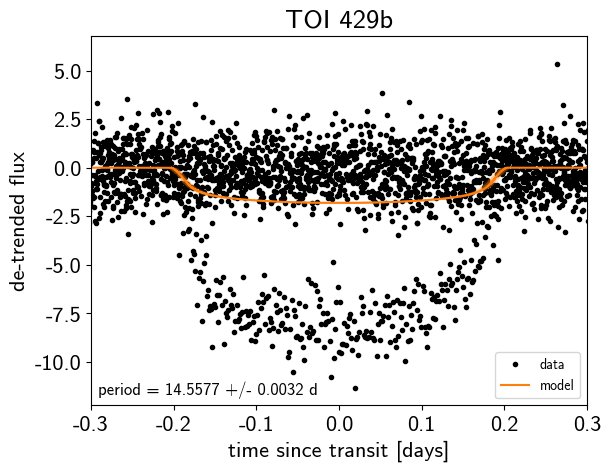

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

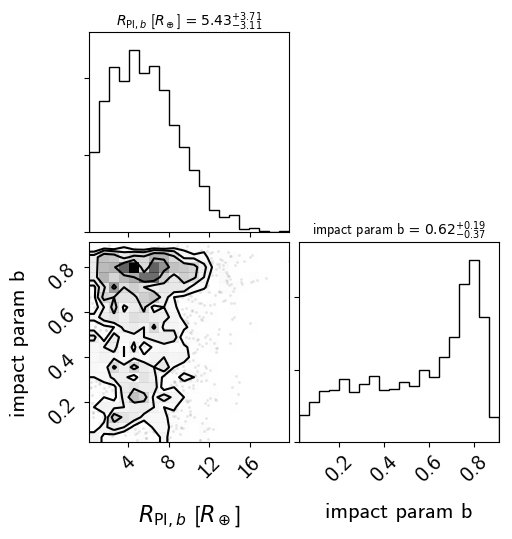

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

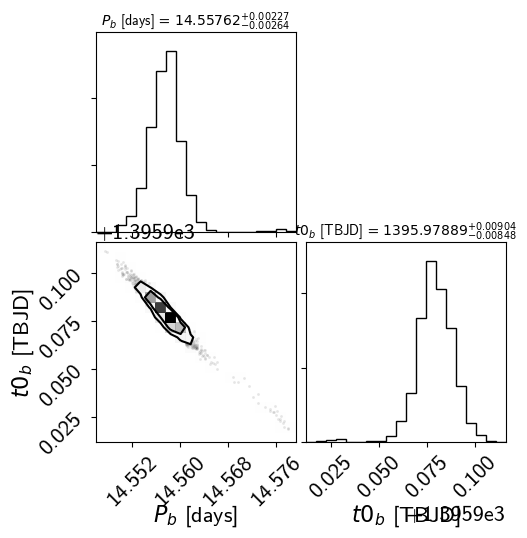

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

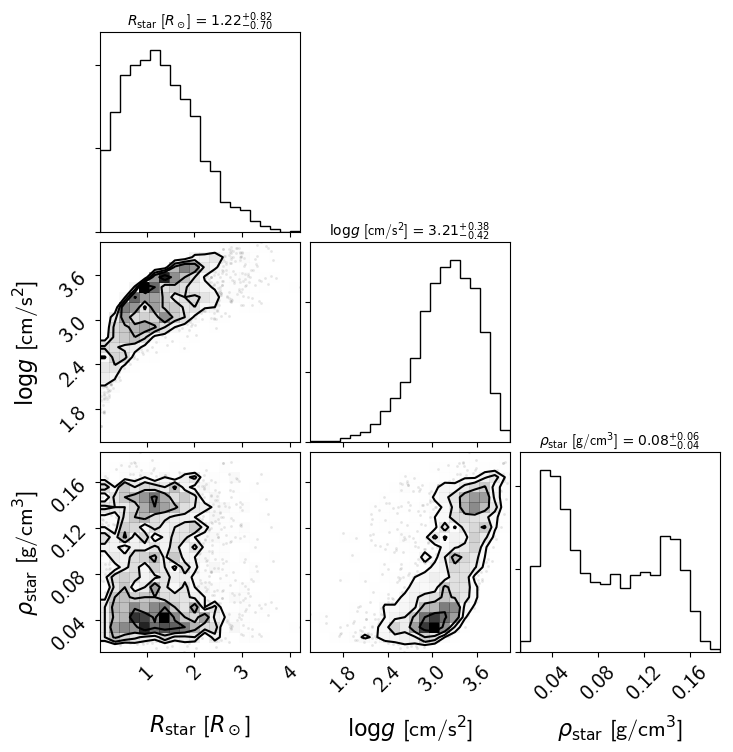

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3